In [2]:
import numpy as np
import pandas as pd
import uproot
import xgboost as xgb
import matplotlib.pyplot as plt
from xgbo import XgboRegressor
import os
from scipy.stats import norm
import matplotlib.mlab as mlab
import iminuit
import probfit
import probfit.pdf

In [3]:
def load_data(file_name, entrystop, isEE=False):

    root_file = uproot.open(file_name)

    # The branches we need for the regression
    branches_EB = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5',
            'iPhiMod2', 'iEtaMod20', 'iPhiMod20', 'genEnergy']

    branches_EE = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi',
            'genEnergy', 'iXSeed', 'iYSeed', 'preshowerEnergy']

    if isEE:
        branches = branches_EE + ["pt", "eta"]
    else:
        branches = branches_EB + ["pt", "eta"]

    if "Electron" in file_name:
        df = root_file['een_analyzer/ElectronTree'].pandas.df(branches, entrystop=entrystop).dropna()
    if "Photon" in file_name:
        df = root_file['een_analyzer/PhotonTree'].pandas.df(branches, entrystop=entrystop).dropna()
    print("Entries in ntuple:")
    print(len(df))
    print(df.shape)


    df.eval("clusertRawEnergyOverE5x5 = clusterRawEnergy/full5x5_e5x5", inplace=True)
    df.eval("w3x3OverE5x5             = full5x5_e3x3/full5x5_e5x5", inplace=True)
    df.eval("eMaxOverE5x5             = full5x5_eMax/full5x5_e5x5", inplace=True)
    df.eval("e2ndOverE5x5             = full5x5_e2nd/full5x5_e5x5", inplace=True)
    df.eval("eTopOverE5x5             = full5x5_eTop/full5x5_e5x5", inplace=True)
    df.eval("eBottomOverE5x5          = full5x5_eBottom/full5x5_e5x5", inplace=True)
    df.eval("eLeftOverE5x5            = full5x5_eLeft/full5x5_e5x5", inplace=True)
    df.eval("eRightOverE5x5           = full5x5_eRight/full5x5_e5x5", inplace=True)
    df.eval("e2x5MaxOverE5x5          = full5x5_e2x5Max/full5x5_e5x5", inplace=True)
    df.eval("e2x5TopOverE5x5          = full5x5_e2x5Top/full5x5_e5x5", inplace=True)
    df.eval("e2x5BottomOverE5x5       = full5x5_e2x5Bottom/full5x5_e5x5", inplace=True)
    df.eval("e2x5LeftOverE5x5         = full5x5_e2x5Left/full5x5_e5x5", inplace=True)
    df.eval("e2x5RightOverE5x5        = full5x5_e2x5Right/full5x5_e5x5", inplace=True)

    if isEE:
        df.eval("preshowerEnergyOverrawEnergy = preshowerEnergy/rawEnergy", inplace=True)

    # The target
    if isEE:
        df.eval("target = ( rawEnergy + preshowerEnergy )/genEnergy", inplace=True)
    else:
        df.eval("target = rawEnergy/genEnergy", inplace=True)

    return df


In [4]:
# The features
features_EB = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5', 'iPhiMod2',
        'iEtaMod20', 'iPhiMod20','pt','eta','target']

# EE
features_EE = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iXSeed', 'iYSeed', 'preshowerEnergyOverrawEnergy','pt','eta','target']


file_name = "/scratch/micheli/Electron/perfectIC-lowpt-EB-training.root"


isEE = '-EE-' in file_name

if isEE:
    features = features_EE
else:
    features = features_EB
DF= load_data(file_name, entrystop=1500000,isEE=isEE)



Entries in ntuple:
3428975
(3428975, 30)


In [5]:
DF=DF.query('pt>20')

#  Parameter

train-effrms-mean


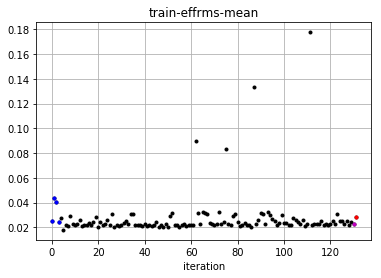

0.005657800000000001


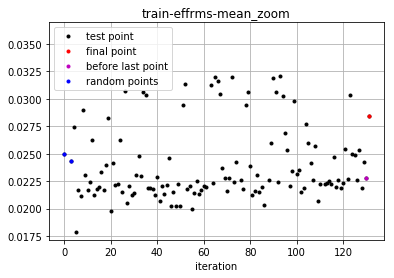

train-effrms-std


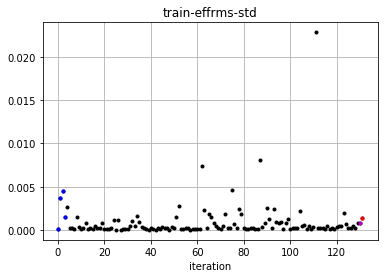

0.0005437105665431042


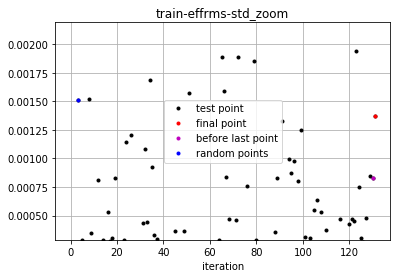

test-effrms-mean


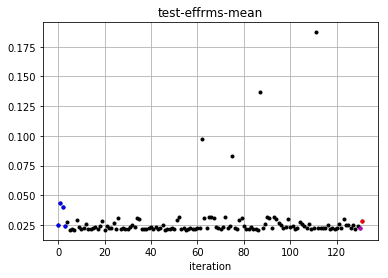

0.005608000000000002


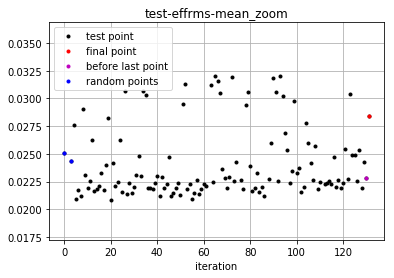

test-effrms-std


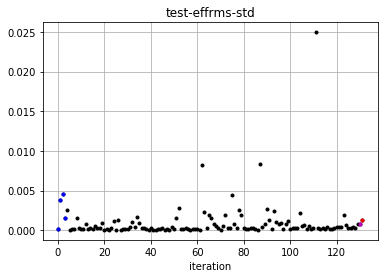

0.0005123864635529559


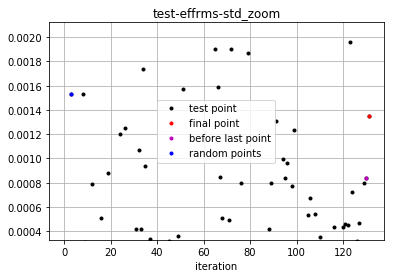

min_child_weight


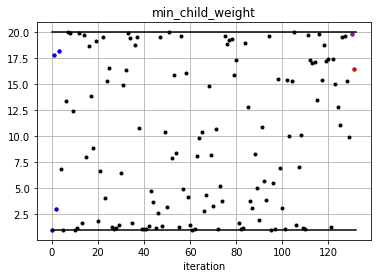

3.35244334672106


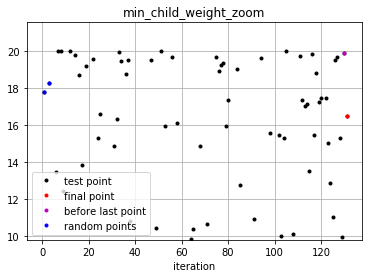

colsample_bytree


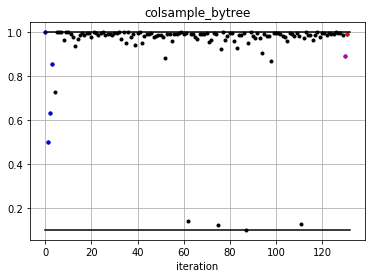

0.1003827919712762


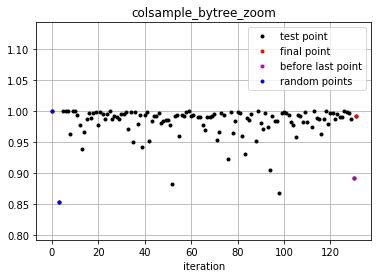

max_depth


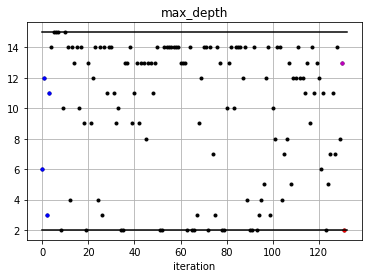

11


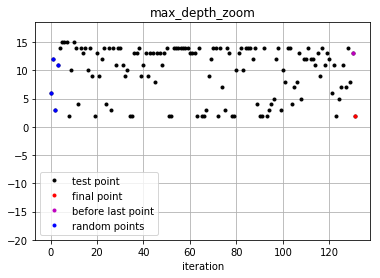

gamma


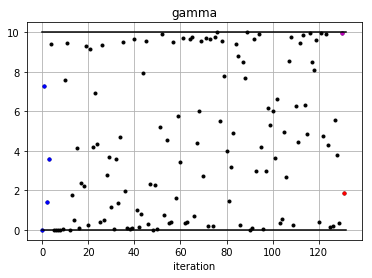

8.118872331123404


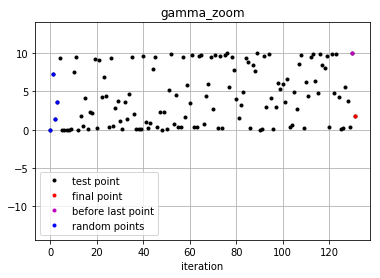

reg_lambda


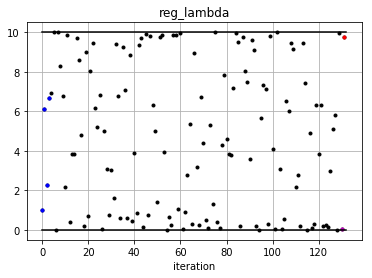

9.741135431880636


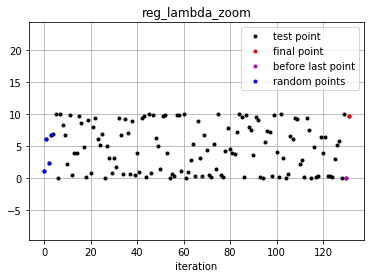

n_estimators


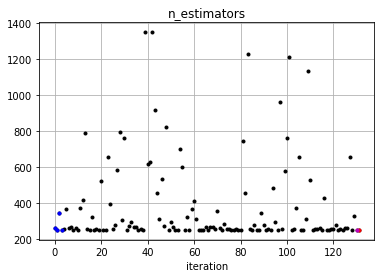

0


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=253, top=253.0
  'bottom=%s, top=%s') % (bottom, top))


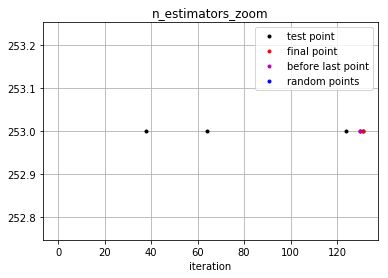

callback


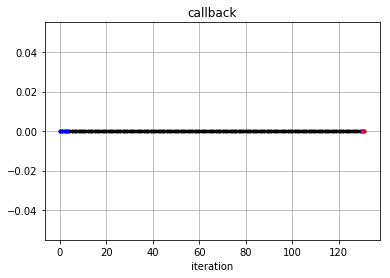

0


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


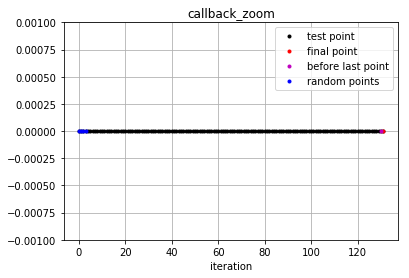

In [6]:
out_dir='/work/okiss/SemesterProject_2/xgbo/Energy_Regression_test/'
parameter=pd.read_csv(out_dir+'Electron_perfectIC-lowpt-EB_test2019049/summary.csv')
rangemax=np.array([20,1,15,10,10])
rangemin=np.array([1,0.1,2,0,0])
i=0
j=0
for para in parameter.columns:
    if i==0:
        para0=para
    else:
        print para
        plt.figure()
        plt.plot(parameter[para0],parameter[para],'k.',label='test point')
        plt.plot(parameter[para0].iloc[-1],parameter[para].iloc[-1],'r.',label='final point')
        plt.plot(parameter[para0].iloc[-2],parameter[para].iloc[-2],'m.',label='before last point')
        plt.plot(parameter[para0].iloc[:4],parameter[para].iloc[:4],'b.',label='random points')  
        plt.title(para)
        plt.xlabel('iteration')
        plt.grid()
        
        
        if 4<i<10:
            one =np.linspace(0,np.size(parameter[para0]),1000)
            plt.plot(one,np.ones_like(one)*rangemax[j],'k-',label='maximal range')
            plt.plot(one,np.ones_like(one)*rangemin[j],'k-',label='minimal range')
            j+=1
        #plt.legend()
        plt.savefig(os.path.join(out_dir+'plot', para+'_evolution'+'.png'))
        plt.show()
        plt.figure()
        plt.plot(parameter[para0],parameter[para],'k.',label='test point')
        plt.plot(parameter[para0].iloc[-1],parameter[para].iloc[-1],'r.',label='final point')
        plt.plot(parameter[para0].iloc[-2],parameter[para].iloc[-2],'m.',label='before last point')
        plt.plot(parameter[para0].iloc[:4],parameter[para].iloc[:4],'b.',label='random points') 
        plt.title(para+'_zoom')
        plt.xlabel('iteration')
        plt.grid()
        zoom=(parameter[para].iloc[-1]-parameter[para].iloc[-2])
        zoom=abs(zoom)
        plt.ylim(parameter[para].iloc[-1]-2*zoom,parameter[para].iloc[-1]+1.5*zoom)
        print(zoom)
        plt.legend()
        plt.savefig(os.path.join(out_dir+'plot', para+'_evolution_zoom'+'.png'))
        plt.show()
        
    i+=1

#  Data

Entries in ntuple:
3428975
(3428975, 30)


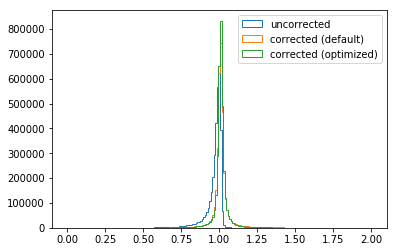

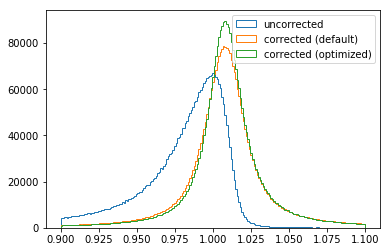

In [7]:
df_test  = load_data(file_name, isEE=isEE, entrystop=1500000)
X_test  = df_test[features_EB]
y_test  = df_test["target"]
xgtest  = xgb.DMatrix(X_test , label=y_test)

xgbo_default = xgb.Booster({'nthread':4}) #init model
#xgbo_default.load_model("Photon_perfectIC-highpt-EB/model_default/model.bin") # load data
xgbo_default.load_model(out_dir+"Electron_perfectIC-lowpt-EB_test20190124/model_default/model.bin")
xgbo_bo = xgb.Booster({'nthread':4}) #init model
#xgbo_bo.load_model("Photon_perfectIC-highpt-EB/model_optimized/model.bin") # load data
xgbo_bo.load_model(out_dir+"Electron_perfectIC-lowpt-EB_test20190124/model_optimized/model.bin") # load data

preds_default = xgbo_default.predict(xgtest)
preds_bo      = xgbo_bo.predict(xgtest)

# preds = 1.

# Etrue / Eraw after applying corrections
z_default = preds_default / (df_test['genEnergy']/df_test['rawEnergy'])
z_bo      = preds_bo / (df_test['genEnergy']/df_test['rawEnergy'])

bins = np.linspace(0.0, 2.0, 200)
bins_zoom = np.linspace(0.9, 1.1, 200)

plt.figure()
plt.hist(df_test['rawEnergy']/df_test['genEnergy'], bins=bins, histtype='step', label="uncorrected")
plt.hist(z_default, bins=bins, histtype='step', label='corrected (default)')
plt.hist(z_bo, bins=bins, histtype='step', label='corrected (optimized)')
plt.legend()
plt.savefig(os.path.join(out_dir+'plot','energy_comparaison'+'.png'))
plt.show()


plt.figure()
plt.hist(df_test['rawEnergy']/df_test['genEnergy'], bins=bins_zoom, histtype='step', label="uncorrected")
plt.hist(z_default, bins=bins_zoom, histtype='step', label='corrected (default)')
plt.hist(z_bo, bins=bins_zoom, histtype='step', label='corrected (optimized)')
plt.legend()
plt.savefig(os.path.join(out_dir+'plot','energy_comparaison_zoom'+'.png'))
plt.show()

In [8]:
data=pd.DataFrame()
data['eta']=df_test['eta']
data['pt']=df_test['pt']
data['target']=df_test['target']
data['z_default']=z_default
data['z_bo']=z_bo
print(data.columns)

Index([u'eta', u'pt', u'target', u'z_default', u'z_bo'], dtype='object')


# ETA

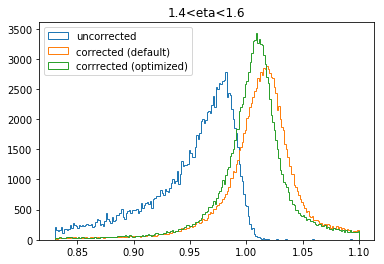

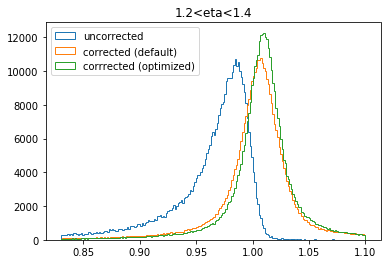

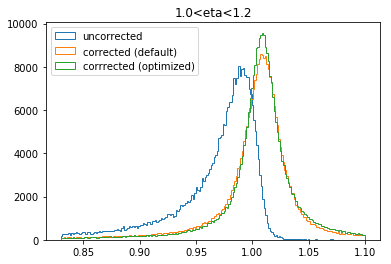

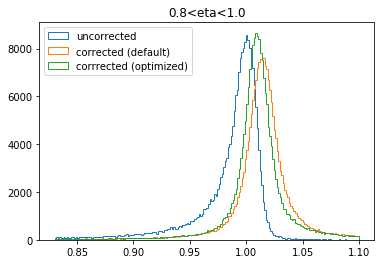

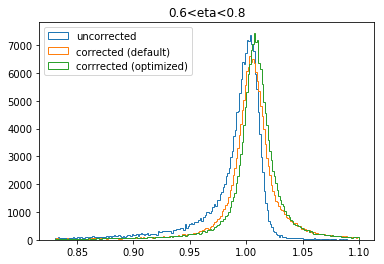

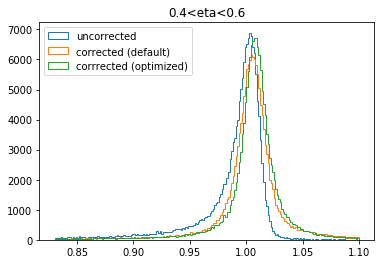

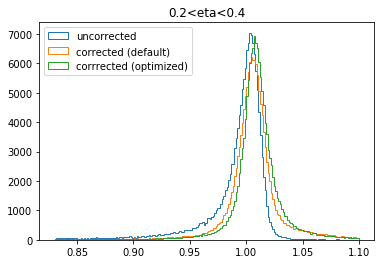

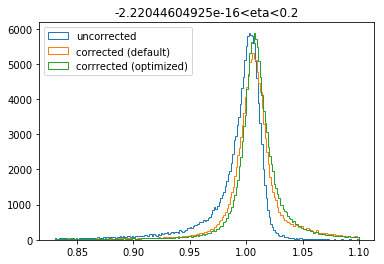

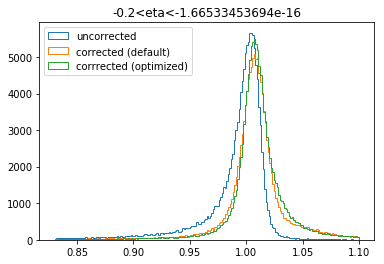

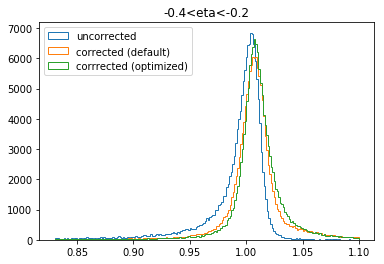

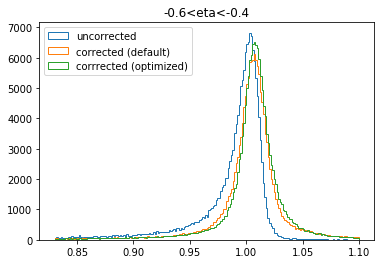

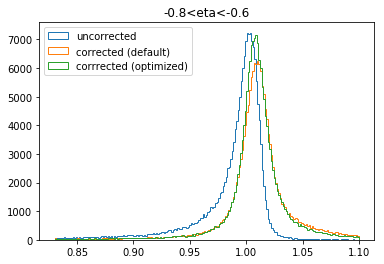

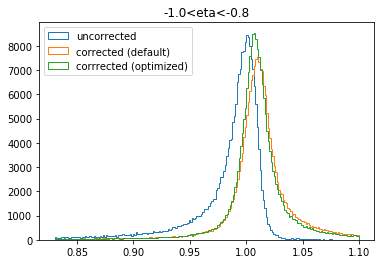

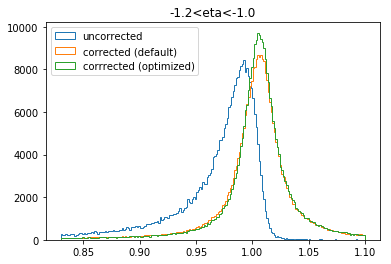

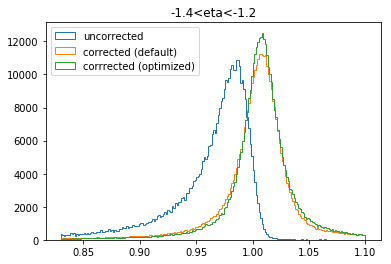

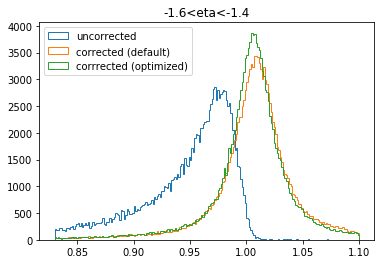

In [18]:
n=16
feat=[]
for i in range (n):
    a=1.4-0.2*i
    b=a+0.2
    eta[i]= (a+b)/2
    feat.append(str(a)+'<eta<'+str(b))
i=0
for para in feat:
    rmin = 0.83
    rmax = 1.1
    plt.figure()
    df=data.query(para).astype('double')
    dft=df.query(str(rmin)+'<target<'+str(rmax)).astype('double')
    dfd=df.query(str(rmin)+'<z_default<'+str(rmax)).astype('double')
    dfo=df.query(str(rmin)+'<z_bo<'+str(rmax)).astype('double')
    nbins = 200
    plt.hist(dft['target'],bins=nbins,histtype='step',label='uncorrected',density=0)
    plt.hist(dfd['z_default'],bins=nbins,histtype='step',label='corrected (default)',density=0)
    plt.hist(dfo['z_bo'],bins=nbins,histtype='step',label='corrrected (optimized)',density=0)
    plt.title(para)
    plt.legend(loc=2)
    plt.savefig(os.path.join(out_dir+'plot','split_in_eta_'+para+'.png'))
    
    plt.show()
    #plt.ylim([0,500])
    
    #surface_hist=sum(out[0][:]*np.diff(out[1][:]))
   
   
    
   

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.16516026391857228)


FCN = 1744.50854809 
 TOTAL NCALL = 663 
 NCALLS = 652 
 
 
 EDM = 528.938471322 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.711613 
 0.0107141 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.27601 
 0.160899 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00084 
 0.0151598 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.69767 
 0.600385 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.975889 
 0.00015089 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0130882 
 0.000102964 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.711613 & 0.0107141 & & & & & No\\
\hline
1 & alpha2 & 3.27601 & 0.160899 & & & & & No\\
\hline
2 & n & 1.00084 & 0.0151598 & & & & & No\\
\hline
3 & n2 & 1.69767 & 0.600385 & & & & & No\\
\hline
4 & mean & 0.975889 & 0.00015089 & & & & & No\\
\hline
5 & $\sigma$ & 0.0130882 & 0.000102964 & & & & & No\\
\hline
\end{tabular}

FCN = 684.044715627 
 TOTAL NCALL = 219 
 NCALLS = 208 
 
 
 EDM = 916140.472736 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.348459 
 0.00080108 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.32112 
 0.135094 
 
 
 
 
 No 
 
 
 2 
 n 
 2.72678 
 0.0059227 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.00699416 
 10.4174 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.978883 
 2.24328e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0114086 
 1.82008e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.348459 & 0.00080108 & & & & & No\\
\hline
1 & alpha2 & 4.32112 & 0.135094 & & & & & No\\
\hline
2 & n & 2.72678 & 0.0059227 & & & & & No\\
\hline
3 & n2 & 0.00699416 & 10.4174 & & & & & No\\
\hline
4 & mean & 0.978883 & 2.24328e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0114086 & 1.82008e-05 & & & & & No\\
\hline
\end{tabular}

1.4<eta<1.6


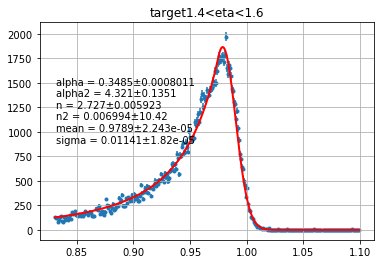

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.24355013049602425)


FCN = 1298.33688527 
 TOTAL NCALL = 588 
 NCALLS = 588 
 
 
 EDM = 1.23159219629e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.435448 
 0.00422019 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.69625 
 0.0294715 
 
 
 
 
 No 
 
 
 2 
 n 
 4.31352 
 0.084066 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.89859 
 0.103012 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.984951 
 7.26104e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0108873 
 4.81883e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.435448 & 0.00422019 & & & & & No\\
\hline
1 & alpha2 & 2.69625 & 0.0294715 & & & & & No\\
\hline
2 & n & 4.31352 & 0.084066 & & & & & No\\
\hline
3 & n2 & 1.89859 & 0.103012 & & & & & No\\
\hline
4 & mean & 0.984951 & 7.26104e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0108873 & 4.81883e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1298.33688521 
 TOTAL NCALL = 107 
 NCALLS = 107 
 
 
 EDM = 6.3148050792e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.435448 
 0.00421907 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.69625 
 0.0294711 
 
 
 
 
 No 
 
 
 2 
 n 
 4.31352 
 0.0840587 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.89859 
 0.103012 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.984951 
 7.25825e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0108874 
 4.81694e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.435448 & 0.00421907 & & & & & No\\
\hline
1 & alpha2 & 2.69625 & 0.0294711 & & & & & No\\
\hline
2 & n & 4.31352 & 0.0840587 & & & & & No\\
\hline
3 & n2 & 1.89859 & 0.103012 & & & & & No\\
\hline
4 & mean & 0.984951 & 7.25825e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0108874 & 4.81694e-05 & & & & & No\\
\hline
\end{tabular}

1.2<eta<1.4


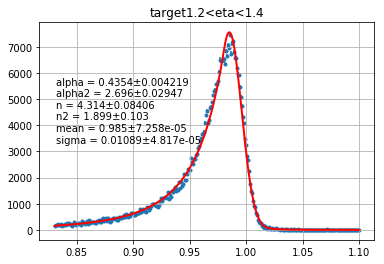

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.25116234225767703)


FCN = 1061.80501193 
 TOTAL NCALL = 608 
 NCALLS = 608 
 
 
 EDM = 1.00812122478e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.458915 
 0.00521217 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.55559 
 0.0312633 
 
 
 
 
 No 
 
 
 2 
 n 
 3.15928 
 0.055308 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.14591 
 0.120794 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.990678 
 8.26865e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0108173 
 5.65837e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.458915 & 0.00521217 & & & & & No\\
\hline
1 & alpha2 & 2.55559 & 0.0312633 & & & & & No\\
\hline
2 & n & 3.15928 & 0.055308 & & & & & No\\
\hline
3 & n2 & 2.14591 & 0.120794 & & & & & No\\
\hline
4 & mean & 0.990678 & 8.26865e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0108173 & 5.65837e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1061.80501193 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 8.71186356366e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.458915 
 0.00480707 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.55559 
 0.0308441 
 
 
 
 
 No 
 
 
 2 
 n 
 3.15928 
 0.0544583 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.14591 
 0.120531 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.990678 
 7.20289e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0108173 
 4.86465e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.458915 & 0.00480707 & & & & & No\\
\hline
1 & alpha2 & 2.55559 & 0.0308441 & & & & & No\\
\hline
2 & n & 3.15928 & 0.0544583 & & & & & No\\
\hline
3 & n2 & 2.14591 & 0.120531 & & & & & No\\
\hline
4 & mean & 0.990678 & 7.20289e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0108173 & 4.86465e-05 & & & & & No\\
\hline
\end{tabular}

1.0<eta<1.2


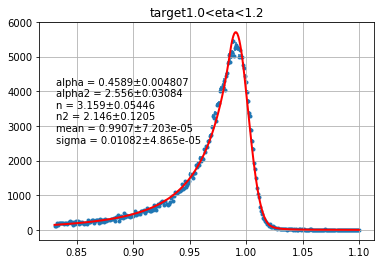

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.30001362148092986)


FCN = 597.77627941 
 TOTAL NCALL = 401 
 NCALLS = 401 
 
 
 EDM = 1.47708201046e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.708799 
 0.0070769 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.28453 
 0.0247839 
 
 
 
 
 No 
 
 
 2 
 n 
 2.45329 
 0.0291715 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.89881 
 0.0765252 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999645 
 5.27693e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00876963 
 4.32013e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.708799 & 0.0070769 & & & & & No\\
\hline
1 & alpha2 & 2.28453 & 0.0247839 & & & & & No\\
\hline
2 & n & 2.45329 & 0.0291715 & & & & & No\\
\hline
3 & n2 & 1.89881 & 0.0765252 & & & & & No\\
\hline
4 & mean & 0.999645 & 5.27693e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00876963 & 4.32013e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 597.77627941 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 1.39706952668e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.708799 
 0.0068104 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.28453 
 0.0244221 
 
 
 
 
 No 
 
 
 2 
 n 
 2.45329 
 0.0289655 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.89881 
 0.0761604 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999645 
 4.94692e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00876963 
 3.98988e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.708799 & 0.0068104 & & & & & No\\
\hline
1 & alpha2 & 2.28453 & 0.0244221 & & & & & No\\
\hline
2 & n & 2.45329 & 0.0289655 & & & & & No\\
\hline
3 & n2 & 1.89881 & 0.0761604 & & & & & No\\
\hline
4 & mean & 0.999645 & 4.94692e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00876963 & 3.98988e-05 & & & & & No\\
\hline
\end{tabular}

0.8<eta<1.0


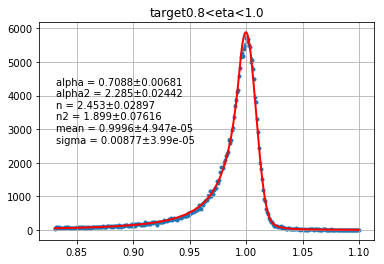

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.29182493110225105)


FCN = 557.738418657 
 TOTAL NCALL = 446 
 NCALLS = 446 
 
 
 EDM = 1.30834786741e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.769492 
 0.00850011 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.17693 
 0.0256493 
 
 
 
 
 No 
 
 
 2 
 n 
 2.23034 
 0.027648 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.85344 
 0.0741196 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00197 
 5.49364e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00853495 
 4.82345e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.769492 & 0.00850011 & & & & & No\\
\hline
1 & alpha2 & 2.17693 & 0.0256493 & & & & & No\\
\hline
2 & n & 2.23034 & 0.027648 & & & & & No\\
\hline
3 & n2 & 1.85344 & 0.0741196 & & & & & No\\
\hline
4 & mean & 1.00197 & 5.49364e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00853495 & 4.82345e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 557.738417738 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 3.89688809046e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.769492 
 0.0084993 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.17693 
 0.0256486 
 
 
 
 
 No 
 
 
 2 
 n 
 2.23034 
 0.0276469 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.85344 
 0.0741184 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00197 
 5.49282e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00853498 
 4.82272e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.769492 & 0.0084993 & & & & & No\\
\hline
1 & alpha2 & 2.17693 & 0.0256486 & & & & & No\\
\hline
2 & n & 2.23034 & 0.0276469 & & & & & No\\
\hline
3 & n2 & 1.85344 & 0.0741184 & & & & & No\\
\hline
4 & mean & 1.00197 & 5.49282e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00853498 & 4.82272e-05 & & & & & No\\
\hline
\end{tabular}

0.6<eta<0.8


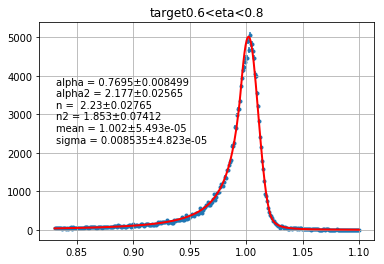

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2848797691120468)


FCN = 566.209650551 
 TOTAL NCALL = 441 
 NCALLS = 441 
 
 
 EDM = 1.56837288357e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.797101 
 0.00877261 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.37179 
 0.0271447 
 
 
 
 
 No 
 
 
 2 
 n 
 2.13285 
 0.0263969 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.49102 
 0.0678994 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00226 
 5.48643e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00843203 
 4.50416e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.797101 & 0.00877261 & & & & & No\\
\hline
1 & alpha2 & 2.37179 & 0.0271447 & & & & & No\\
\hline
2 & n & 2.13285 & 0.0263969 & & & & & No\\
\hline
3 & n2 & 1.49102 & 0.0678994 & & & & & No\\
\hline
4 & mean & 1.00226 & 5.48643e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00843203 & 4.50416e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 566.209650551 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 1.55336706443e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.797101 
 0.0084696 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.37179 
 0.0268298 
 
 
 
 
 No 
 
 
 2 
 n 
 2.13285 
 0.0261588 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.49102 
 0.0675857 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00226 
 5.17328e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00843203 
 4.19492e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.797101 & 0.0084696 & & & & & No\\
\hline
1 & alpha2 & 2.37179 & 0.0268298 & & & & & No\\
\hline
2 & n & 2.13285 & 0.0261588 & & & & & No\\
\hline
3 & n2 & 1.49102 & 0.0675857 & & & & & No\\
\hline
4 & mean & 1.00226 & 5.17328e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00843203 & 4.19492e-05 & & & & & No\\
\hline
\end{tabular}

0.4<eta<0.6


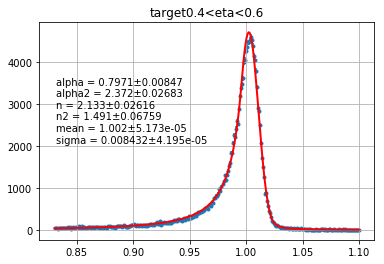

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2894876889355664)


FCN = 480.122479511 
 TOTAL NCALL = 415 
 NCALLS = 415 
 
 
 EDM = 3.10794672405e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.790176 
 0.00907376 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.21982 
 0.0277224 
 
 
 
 
 No 
 
 
 2 
 n 
 2.56809 
 0.0347231 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.88145 
 0.0807629 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00329 
 5.38462e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00806443 
 4.70857e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.790176 & 0.00907376 & & & & & No\\
\hline
1 & alpha2 & 2.21982 & 0.0277224 & & & & & No\\
\hline
2 & n & 2.56809 & 0.0347231 & & & & & No\\
\hline
3 & n2 & 1.88145 & 0.0807629 & & & & & No\\
\hline
4 & mean & 1.00329 & 5.38462e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00806443 & 4.70857e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 480.122479511 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 3.07283936012e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.790176 
 0.00871277 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.21982 
 0.0272652 
 
 
 
 
 No 
 
 
 2 
 n 
 2.56809 
 0.0344047 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.88145 
 0.0802853 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00329 
 5.07196e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00806443 
 4.36436e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.790176 & 0.00871277 & & & & & No\\
\hline
1 & alpha2 & 2.21982 & 0.0272652 & & & & & No\\
\hline
2 & n & 2.56809 & 0.0344047 & & & & & No\\
\hline
3 & n2 & 1.88145 & 0.0802853 & & & & & No\\
\hline
4 & mean & 1.00329 & 5.07196e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00806443 & 4.36436e-05 & & & & & No\\
\hline
\end{tabular}

0.2<eta<0.4


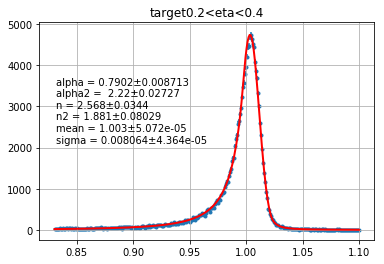

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.26674181945016334)


FCN = 400.958181294 
 TOTAL NCALL = 423 
 NCALLS = 423 
 
 
 EDM = 5.70525323363e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.761076 
 0.00921876 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.12001 
 0.026613 
 
 
 
 
 No 
 
 
 2 
 n 
 2.57323 
 0.0368065 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.96939 
 0.0819373 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00316 
 5.88997e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0082388 
 5.18161e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.761076 & 0.00921876 & & & & & No\\
\hline
1 & alpha2 & 2.12001 & 0.026613 & & & & & No\\
\hline
2 & n & 2.57323 & 0.0368065 & & & & & No\\
\hline
3 & n2 & 1.96939 & 0.0819373 & & & & & No\\
\hline
4 & mean & 1.00316 & 5.88997e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0082388 & 5.18161e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 400.958152917 
 TOTAL NCALL = 115 
 NCALLS = 115 
 
 
 EDM = 2.86505662566e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.761079 
 0.00921948 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.11998 
 0.0266057 
 
 
 
 
 No 
 
 
 2 
 n 
 2.57325 
 0.0368097 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.96922 
 0.0819017 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00316 
 5.89014e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00823883 
 5.18176e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.761079 & 0.00921948 & & & & & No\\
\hline
1 & alpha2 & 2.11998 & 0.0266057 & & & & & No\\
\hline
2 & n & 2.57325 & 0.0368097 & & & & & No\\
\hline
3 & n2 & 1.96922 & 0.0819017 & & & & & No\\
\hline
4 & mean & 1.00316 & 5.89014e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00823883 & 5.18176e-05 & & & & & No\\
\hline
\end{tabular}

-2.22044604925e-16<eta<0.2


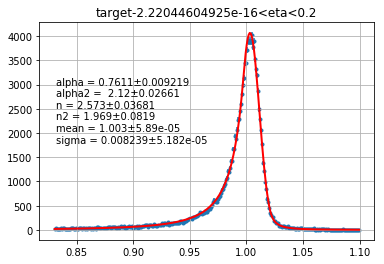

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.26225422567241435)


FCN = 412.469452079 
 TOTAL NCALL = 493 
 NCALLS = 493 
 
 
 EDM = 7.85800668177e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.805697 
 0.00998676 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.20223 
 0.0274002 
 
 
 
 
 No 
 
 
 2 
 n 
 2.33938 
 0.0336733 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.71631 
 0.0746752 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00289 
 6.04088e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00849749 
 5.28126e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.805697 & 0.00998676 & & & & & No\\
\hline
1 & alpha2 & 2.20223 & 0.0274002 & & & & & No\\
\hline
2 & n & 2.33938 & 0.0336733 & & & & & No\\
\hline
3 & n2 & 1.71631 & 0.0746752 & & & & & No\\
\hline
4 & mean & 1.00289 & 6.04088e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00849749 & 5.28126e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 412.469451974 
 TOTAL NCALL = 102 
 NCALLS = 102 
 
 
 EDM = 7.75262725605e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.805697 
 0.00998611 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.20223 
 0.0273999 
 
 
 
 
 No 
 
 
 2 
 n 
 2.33938 
 0.0336725 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.71631 
 0.0746747 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00289 
 6.04024e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00849751 
 5.28067e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.805697 & 0.00998611 & & & & & No\\
\hline
1 & alpha2 & 2.20223 & 0.0273999 & & & & & No\\
\hline
2 & n & 2.33938 & 0.0336725 & & & & & No\\
\hline
3 & n2 & 1.71631 & 0.0746747 & & & & & No\\
\hline
4 & mean & 1.00289 & 6.04024e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00849751 & 5.28067e-05 & & & & & No\\
\hline
\end{tabular}

-0.2<eta<-1.66533453694e-16


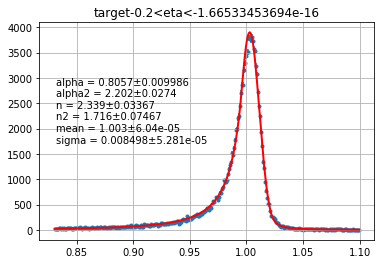

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2865082003381453)


FCN = 473.283278069 
 TOTAL NCALL = 416 
 NCALLS = 416 
 
 
 EDM = 4.95201527265e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.795458 
 0.00921405 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.18665 
 0.0280078 
 
 
 
 
 No 
 
 
 2 
 n 
 2.48913 
 0.0335003 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.9817 
 0.0857348 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00332 
 5.40556e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00805926 
 4.77175e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.795458 & 0.00921405 & & & & & No\\
\hline
1 & alpha2 & 2.18665 & 0.0280078 & & & & & No\\
\hline
2 & n & 2.48913 & 0.0335003 & & & & & No\\
\hline
3 & n2 & 1.9817 & 0.0857348 & & & & & No\\
\hline
4 & mean & 1.00332 & 5.40556e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00805926 & 4.77175e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 473.28327789 
 TOTAL NCALL = 102 
 NCALLS = 102 
 
 
 EDM = 3.15966552954e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.795458 
 0.00921334 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.18665 
 0.0280074 
 
 
 
 
 No 
 
 
 2 
 n 
 2.48913 
 0.0334993 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.9817 
 0.0857341 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00332 
 5.40489e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00805928 
 4.77113e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.795458 & 0.00921334 & & & & & No\\
\hline
1 & alpha2 & 2.18665 & 0.0280074 & & & & & No\\
\hline
2 & n & 2.48913 & 0.0334993 & & & & & No\\
\hline
3 & n2 & 1.9817 & 0.0857341 & & & & & No\\
\hline
4 & mean & 1.00332 & 5.40489e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00805928 & 4.77113e-05 & & & & & No\\
\hline
\end{tabular}

-0.4<eta<-0.2


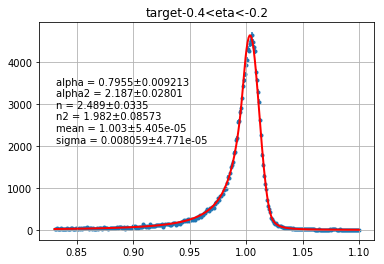

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.28028530670930346)


FCN = 535.841724458 
 TOTAL NCALL = 447 
 NCALLS = 447 
 
 
 EDM = 2.24613904023e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.76015 
 0.00907477 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.25323 
 0.0304437 
 
 
 
 
 No 
 
 
 2 
 n 
 2.12187 
 0.0268196 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.81392 
 0.0847762 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00227 
 5.99875e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00839848 
 5.2365e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.76015 & 0.00907477 & & & & & No\\
\hline
1 & alpha2 & 2.25323 & 0.0304437 & & & & & No\\
\hline
2 & n & 2.12187 & 0.0268196 & & & & & No\\
\hline
3 & n2 & 1.81392 & 0.0847762 & & & & & No\\
\hline
4 & mean & 1.00227 & 5.99875e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00839848 & 5.2365e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 535.841724424 
 TOTAL NCALL = 104 
 NCALLS = 104 
 
 
 EDM = 1.90817689695e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.76015 
 0.00907379 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.25323 
 0.030443 
 
 
 
 
 No 
 
 
 2 
 n 
 2.12187 
 0.0268185 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.81392 
 0.0847753 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00227 
 5.99771e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00839849 
 5.23557e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.76015 & 0.00907379 & & & & & No\\
\hline
1 & alpha2 & 2.25323 & 0.030443 & & & & & No\\
\hline
2 & n & 2.12187 & 0.0268185 & & & & & No\\
\hline
3 & n2 & 1.81392 & 0.0847753 & & & & & No\\
\hline
4 & mean & 1.00227 & 5.99771e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00839849 & 5.23557e-05 & & & & & No\\
\hline
\end{tabular}

-0.6<eta<-0.4


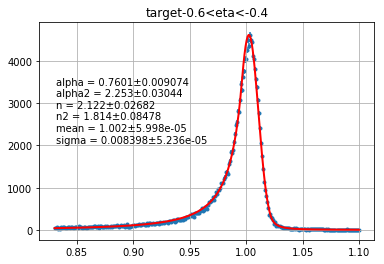

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2928466143724533)


FCN = 472.536840996 
 TOTAL NCALL = 442 
 NCALLS = 442 
 
 
 EDM = 2.86213157325e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.746128 
 0.00802003 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.1595 
 0.0243051 
 
 
 
 
 No 
 
 
 2 
 n 
 2.32457 
 0.0284128 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.86543 
 0.0708804 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00239 
 5.33954e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00834808 
 4.64044e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.746128 & 0.00802003 & & & & & No\\
\hline
1 & alpha2 & 2.1595 & 0.0243051 & & & & & No\\
\hline
2 & n & 2.32457 & 0.0284128 & & & & & No\\
\hline
3 & n2 & 1.86543 & 0.0708804 & & & & & No\\
\hline
4 & mean & 1.00239 & 5.33954e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00834808 & 4.64044e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 472.536839843 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 1.70925363345e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.746128 
 0.00801937 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.1595 
 0.0243045 
 
 
 
 
 No 
 
 
 2 
 n 
 2.32457 
 0.0284118 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.86543 
 0.0708792 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00239 
 5.33887e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00834811 
 4.63986e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.746128 & 0.00801937 & & & & & No\\
\hline
1 & alpha2 & 2.1595 & 0.0243045 & & & & & No\\
\hline
2 & n & 2.32457 & 0.0284118 & & & & & No\\
\hline
3 & n2 & 1.86543 & 0.0708792 & & & & & No\\
\hline
4 & mean & 1.00239 & 5.33887e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00834811 & 4.63986e-05 & & & & & No\\
\hline
\end{tabular}

-0.8<eta<-0.6


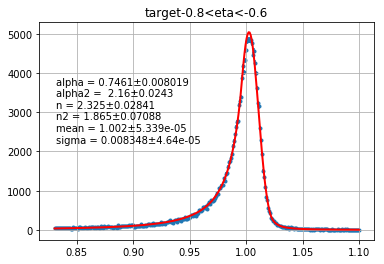

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2985940740342418)


FCN = 611.590920343 
 TOTAL NCALL = 402 
 NCALLS = 402 
 
 
 EDM = 4.12864330766e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.704912 
 0.00742884 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.26732 
 0.0259732 
 
 
 
 
 No 
 
 
 2 
 n 
 2.36068 
 0.0282426 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.8868 
 0.0775869 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999793 
 5.53631e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0086909 
 4.60048e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.704912 & 0.00742884 & & & & & No\\
\hline
1 & alpha2 & 2.26732 & 0.0259732 & & & & & No\\
\hline
2 & n & 2.36068 & 0.0282426 & & & & & No\\
\hline
3 & n2 & 1.8868 & 0.0775869 & & & & & No\\
\hline
4 & mean & 0.999793 & 5.53631e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0086909 & 4.60048e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 611.590918877 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 3.98201318118e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.704912 
 0.00742793 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.26732 
 0.0259725 
 
 
 
 
 No 
 
 
 2 
 n 
 2.36068 
 0.0282411 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.8868 
 0.0775859 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999793 
 5.53533e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00869094 
 4.59966e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.704912 & 0.00742793 & & & & & No\\
\hline
1 & alpha2 & 2.26732 & 0.0259725 & & & & & No\\
\hline
2 & n & 2.36068 & 0.0282411 & & & & & No\\
\hline
3 & n2 & 1.8868 & 0.0775859 & & & & & No\\
\hline
4 & mean & 0.999793 & 5.53533e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00869094 & 4.59966e-05 & & & & & No\\
\hline
\end{tabular}

-1.0<eta<-0.8


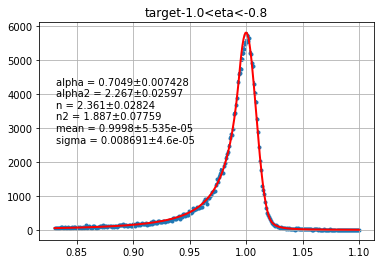

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.25823499597352095)


FCN = 1055.4319262 
 TOTAL NCALL = 515 
 NCALLS = 515 
 
 
 EDM = 4.21117334679e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.450031 
 0.00500392 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.63148 
 0.0307595 
 
 
 
 
 No 
 
 
 2 
 n 
 3.20191 
 0.0536753 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.68547 
 0.0940425 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.991979 
 7.92816e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103039 
 5.3692e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.450031 & 0.00500392 & & & & & No\\
\hline
1 & alpha2 & 2.63148 & 0.0307595 & & & & & No\\
\hline
2 & n & 3.20191 & 0.0536753 & & & & & No\\
\hline
3 & n2 & 1.68547 & 0.0940425 & & & & & No\\
\hline
4 & mean & 0.991979 & 7.92816e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103039 & 5.3692e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1055.43192563 
 TOTAL NCALL = 105 
 NCALLS = 105 
 
 
 EDM = 4.15416334991e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.450031 
 0.00500269 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.63148 
 0.0307587 
 
 
 
 
 No 
 
 
 2 
 n 
 3.20191 
 0.0536703 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.68547 
 0.0940411 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.991979 
 7.9254e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103039 
 5.36732e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.450031 & 0.00500269 & & & & & No\\
\hline
1 & alpha2 & 2.63148 & 0.0307587 & & & & & No\\
\hline
2 & n & 3.20191 & 0.0536703 & & & & & No\\
\hline
3 & n2 & 1.68547 & 0.0940411 & & & & & No\\
\hline
4 & mean & 0.991979 & 7.9254e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103039 & 5.36732e-05 & & & & & No\\
\hline
\end{tabular}

-1.2<eta<-1.0


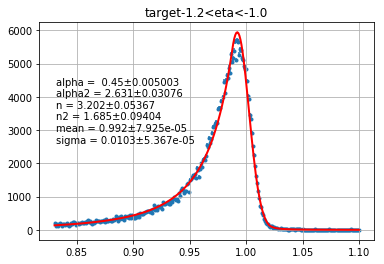

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.24535380612338636)


FCN = 1178.44315516 
 TOTAL NCALL = 586 
 NCALLS = 586 
 
 
 EDM = 1.56152867363e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.440706 
 0.00416004 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.74319 
 0.0284269 
 
 
 
 
 No 
 
 
 2 
 n 
 4.28154 
 0.0826463 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.75465 
 0.0951108 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.984601 
 7.07717e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110436 
 4.65727e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.440706 & 0.00416004 & & & & & No\\
\hline
1 & alpha2 & 2.74319 & 0.0284269 & & & & & No\\
\hline
2 & n & 4.28154 & 0.0826463 & & & & & No\\
\hline
3 & n2 & 1.75465 & 0.0951108 & & & & & No\\
\hline
4 & mean & 0.984601 & 7.07717e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110436 & 4.65727e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1178.44315516 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 1.48691646661e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.440706 
 0.00383961 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.74319 
 0.0282234 
 
 
 
 
 No 
 
 
 2 
 n 
 4.28154 
 0.0816326 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.75465 
 0.0949972 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.984601 
 6.1553e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110436 
 3.99014e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.440706 & 0.00383961 & & & & & No\\
\hline
1 & alpha2 & 2.74319 & 0.0282234 & & & & & No\\
\hline
2 & n & 4.28154 & 0.0816326 & & & & & No\\
\hline
3 & n2 & 1.75465 & 0.0949972 & & & & & No\\
\hline
4 & mean & 0.984601 & 6.1553e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110436 & 3.99014e-05 & & & & & No\\
\hline
\end{tabular}

-1.4<eta<-1.2


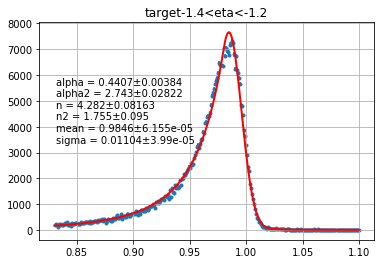

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.1814137121948454)


FCN = 777.018899507 
 TOTAL NCALL = 962 
 NCALLS = 962 
 
 
 EDM = 3.33266768261e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.288436 
 0.00585496 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.162 
 0.0743823 
 
 
 
 
 No 
 
 
 2 
 n 
 4.81128 
 0.275973 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.2509 
 0.202559 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.978772 
 0.000162194 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0111415 
 9.59714e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.288436 & 0.00585496 & & & & & No\\
\hline
1 & alpha2 & 3.162 & 0.0743823 & & & & & No\\
\hline
2 & n & 4.81128 & 0.275973 & & & & & No\\
\hline
3 & n2 & 1.2509 & 0.202559 & & & & & No\\
\hline
4 & mean & 0.978772 & 0.000162194 & & & & & No\\
\hline
5 & $\sigma$ & 0.0111415 & 9.59714e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 777.018899027 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 3.28382823916e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.288436 
 0.00585361 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.162 
 0.0743822 
 
 
 
 
 No 
 
 
 2 
 n 
 4.81128 
 0.275935 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.25091 
 0.20256 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.978772 
 0.000162151 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0111415 
 9.59469e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.288436 & 0.00585361 & & & & & No\\
\hline
1 & alpha2 & 3.162 & 0.0743822 & & & & & No\\
\hline
2 & n & 4.81128 & 0.275935 & & & & & No\\
\hline
3 & n2 & 1.25091 & 0.20256 & & & & & No\\
\hline
4 & mean & 0.978772 & 0.000162151 & & & & & No\\
\hline
5 & $\sigma$ & 0.0111415 & 9.59469e-05 & & & & & No\\
\hline
\end{tabular}

-1.6<eta<-1.4


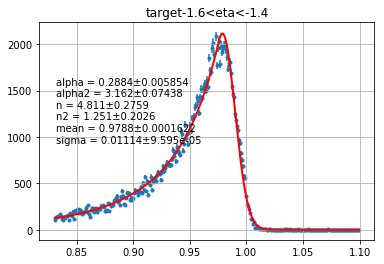

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2956758446356256)


FCN = 242.508367068 
 TOTAL NCALL = 377 
 NCALLS = 377 
 
 
 EDM = 9.50189728581e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08369 
 0.0176264 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.4612 
 0.0166379 
 
 
 
 
 No 
 
 
 2 
 n 
 3.23211 
 0.111556 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.32644 
 0.0333543 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01559 
 9.77605e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0183116 
 0.000134178 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08369 & 0.0176264 & & & & & No\\
\hline
1 & alpha2 & 1.4612 & 0.0166379 & & & & & No\\
\hline
2 & n & 3.23211 & 0.111556 & & & & & No\\
\hline
3 & n2 & 1.32644 & 0.0333543 & & & & & No\\
\hline
4 & mean & 1.01559 & 9.77605e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0183116 & 0.000134178 & & & & & No\\
\hline
\end{tabular}

FCN = 242.508363302 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 5.73422812361e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08369 
 0.017623 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.46121 
 0.0166374 
 
 
 
 
 No 
 
 
 2 
 n 
 3.23207 
 0.111532 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.32644 
 0.0333541 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01559 
 9.77553e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0183117 
 0.000134167 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08369 & 0.017623 & & & & & No\\
\hline
1 & alpha2 & 1.46121 & 0.0166374 & & & & & No\\
\hline
2 & n & 3.23207 & 0.111532 & & & & & No\\
\hline
3 & n2 & 1.32644 & 0.0333541 & & & & & No\\
\hline
4 & mean & 1.01559 & 9.77553e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0183117 & 0.000134167 & & & & & No\\
\hline
\end{tabular}

1.4<eta<1.6


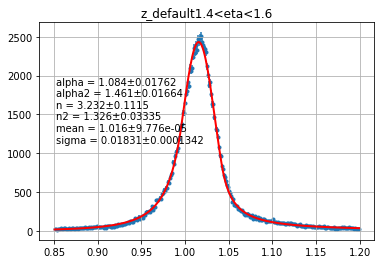

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4805964665578884)


FCN = 361.781808371 
 TOTAL NCALL = 430 
 NCALLS = 430 
 
 
 EDM = 3.22324360041e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23947 
 0.00943173 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.46203 
 0.00958636 
 
 
 
 
 No 
 
 
 2 
 n 
 2.1492 
 0.0323714 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.51157 
 0.019587 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00654 
 4.25164e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015919 
 5.97945e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23947 & 0.00943173 & & & & & No\\
\hline
1 & alpha2 & 1.46203 & 0.00958636 & & & & & No\\
\hline
2 & n & 2.1492 & 0.0323714 & & & & & No\\
\hline
3 & n2 & 1.51157 & 0.019587 & & & & & No\\
\hline
4 & mean & 1.00654 & 4.25164e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015919 & 5.97945e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 361.781808371 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 3.20429035077e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23947 
 0.00936838 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.46203 
 0.00952131 
 
 
 
 
 No 
 
 
 2 
 n 
 2.1492 
 0.0323296 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.51157 
 0.019531 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00654 
 4.24582e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015919 
 5.88928e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23947 & 0.00936838 & & & & & No\\
\hline
1 & alpha2 & 1.46203 & 0.00952131 & & & & & No\\
\hline
2 & n & 2.1492 & 0.0323296 & & & & & No\\
\hline
3 & n2 & 1.51157 & 0.019531 & & & & & No\\
\hline
4 & mean & 1.00654 & 4.24582e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015919 & 5.88928e-05 & & & & & No\\
\hline
\end{tabular}

1.2<eta<1.4


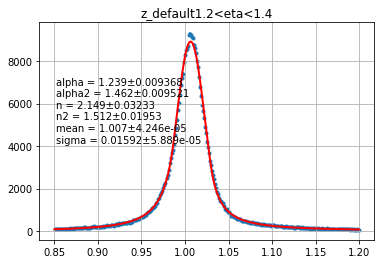

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4355668247726884)


FCN = 335.064143745 
 TOTAL NCALL = 392 
 NCALLS = 392 
 
 
 EDM = 2.64361265947e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.18422 
 0.0101987 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.38747 
 0.0107105 
 
 
 
 
 No 
 
 
 2 
 n 
 1.85519 
 0.0277792 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.71517 
 0.0237743 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00881 
 4.75151e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0148002 
 7.06547e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.18422 & 0.0101987 & & & & & No\\
\hline
1 & alpha2 & 1.38747 & 0.0107105 & & & & & No\\
\hline
2 & n & 1.85519 & 0.0277792 & & & & & No\\
\hline
3 & n2 & 1.71517 & 0.0237743 & & & & & No\\
\hline
4 & mean & 1.00881 & 4.75151e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0148002 & 7.06547e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 335.064138735 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 2.14267039336e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.18422 
 0.0101984 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.38747 
 0.0107097 
 
 
 
 
 No 
 
 
 2 
 n 
 1.8552 
 0.02778 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.71517 
 0.0237734 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00881 
 4.75148e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0148004 
 7.06469e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.18422 & 0.0101984 & & & & & No\\
\hline
1 & alpha2 & 1.38747 & 0.0107097 & & & & & No\\
\hline
2 & n & 1.8552 & 0.02778 & & & & & No\\
\hline
3 & n2 & 1.71517 & 0.0237734 & & & & & No\\
\hline
4 & mean & 1.00881 & 4.75148e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0148004 & 7.06469e-05 & & & & & No\\
\hline
\end{tabular}

1.0<eta<1.2


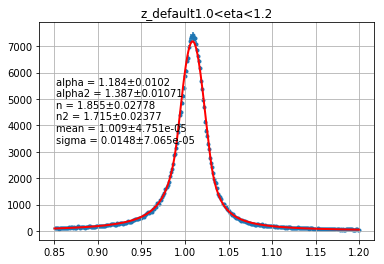

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4296835409685297)


FCN = 318.246466582 
 TOTAL NCALL = 397 
 NCALLS = 397 
 
 
 EDM = 7.13107138236e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.42999 
 0.0128301 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.25115 
 0.0107679 
 
 
 
 
 No 
 
 
 2 
 n 
 1.86422 
 0.0305145 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.95569 
 0.0263839 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01418 
 4.24431e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0117736 
 6.07467e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.42999 & 0.0128301 & & & & & No\\
\hline
1 & alpha2 & 1.25115 & 0.0107679 & & & & & No\\
\hline
2 & n & 1.86422 & 0.0305145 & & & & & No\\
\hline
3 & n2 & 1.95569 & 0.0263839 & & & & & No\\
\hline
4 & mean & 1.01418 & 4.24431e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0117736 & 6.07467e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 318.24646146 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 6.61766853445e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.42999 
 0.012829 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.25115 
 0.0107671 
 
 
 
 
 No 
 
 
 2 
 n 
 1.86422 
 0.0305134 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.9557 
 0.0263834 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01418 
 4.24432e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0117737 
 6.07393e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.42999 & 0.012829 & & & & & No\\
\hline
1 & alpha2 & 1.25115 & 0.0107671 & & & & & No\\
\hline
2 & n & 1.86422 & 0.0305134 & & & & & No\\
\hline
3 & n2 & 1.9557 & 0.0263834 & & & & & No\\
\hline
4 & mean & 1.01418 & 4.24432e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0117737 & 6.07393e-05 & & & & & No\\
\hline
\end{tabular}

0.8<eta<1.0


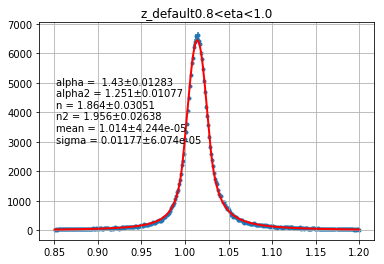

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.33811348472207686)


FCN = 274.40599207 
 TOTAL NCALL = 421 
 NCALLS = 421 
 
 
 EDM = 7.46643145471e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.33045 
 0.0136283 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.16274 
 0.0108371 
 
 
 
 
 No 
 
 
 2 
 n 
 1.9447 
 0.0336208 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.21675 
 0.0304594 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00488 
 4.52132e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109267 
 6.64985e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.33045 & 0.0136283 & & & & & No\\
\hline
1 & alpha2 & 1.16274 & 0.0108371 & & & & & No\\
\hline
2 & n & 1.9447 & 0.0336208 & & & & & No\\
\hline
3 & n2 & 2.21675 & 0.0304594 & & & & & No\\
\hline
4 & mean & 1.00488 & 4.52132e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109267 & 6.64985e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 274.405940425 
 TOTAL NCALL = 109 
 NCALLS = 109 
 
 
 EDM = 2.30413995261e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.33048 
 0.013631 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.16276 
 0.010837 
 
 
 
 
 No 
 
 
 2 
 n 
 1.9448 
 0.0336319 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.2168 
 0.0304614 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00488 
 4.52138e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109269 
 6.64971e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.33048 & 0.013631 & & & & & No\\
\hline
1 & alpha2 & 1.16276 & 0.010837 & & & & & No\\
\hline
2 & n & 1.9448 & 0.0336319 & & & & & No\\
\hline
3 & n2 & 2.2168 & 0.0304614 & & & & & No\\
\hline
4 & mean & 1.00488 & 4.52138e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109269 & 6.64971e-05 & & & & & No\\
\hline
\end{tabular}

0.6<eta<0.8


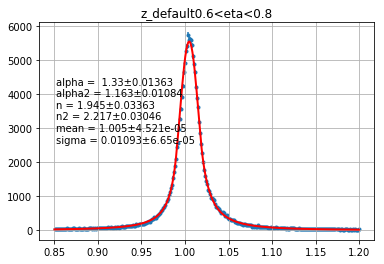

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.32209218724413036)


FCN = 274.875632011 
 TOTAL NCALL = 451 
 NCALLS = 451 
 
 
 EDM = 7.96792577982e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35707 
 0.0138293 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37025 
 0.0121364 
 
 
 
 
 No 
 
 
 2 
 n 
 1.79918 
 0.0318574 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.81957 
 0.0269126 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00495 
 4.48694e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110171 
 6.11294e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35707 & 0.0138293 & & & & & No\\
\hline
1 & alpha2 & 1.37025 & 0.0121364 & & & & & No\\
\hline
2 & n & 1.79918 & 0.0318574 & & & & & No\\
\hline
3 & n2 & 1.81957 & 0.0269126 & & & & & No\\
\hline
4 & mean & 1.00495 & 4.48694e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110171 & 6.11294e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 274.875631977 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = 7.63340146808e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35707 
 0.0138285 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37025 
 0.012136 
 
 
 
 
 No 
 
 
 2 
 n 
 1.79918 
 0.0318568 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.81957 
 0.0269123 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00495 
 4.48691e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110171 
 6.11232e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35707 & 0.0138285 & & & & & No\\
\hline
1 & alpha2 & 1.37025 & 0.012136 & & & & & No\\
\hline
2 & n & 1.79918 & 0.0318568 & & & & & No\\
\hline
3 & n2 & 1.81957 & 0.0269123 & & & & & No\\
\hline
4 & mean & 1.00495 & 4.48691e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110171 & 6.11232e-05 & & & & & No\\
\hline
\end{tabular}

0.4<eta<0.6


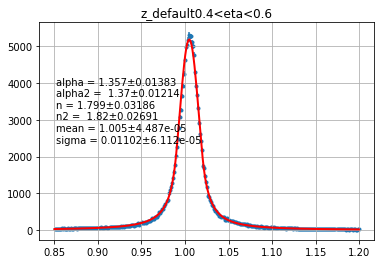

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.32434638812914)


FCN = 378.766477462 
 TOTAL NCALL = 416 
 NCALLS = 416 
 
 
 EDM = 5.04452440916e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37821 
 0.0157276 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.39391 
 0.0117998 
 
 
 
 
 No 
 
 
 2 
 n 
 2.2267 
 0.0443177 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.66618 
 0.0235441 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00538 
 4.28852e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0102349 
 5.77518e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37821 & 0.0157276 & & & & & No\\
\hline
1 & alpha2 & 1.39391 & 0.0117998 & & & & & No\\
\hline
2 & n & 2.2267 & 0.0443177 & & & & & No\\
\hline
3 & n2 & 1.66618 & 0.0235441 & & & & & No\\
\hline
4 & mean & 1.00538 & 4.28852e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0102349 & 5.77518e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 378.766477462 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 4.8758781029e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37821 
 0.0154848 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.39391 
 0.011705 
 
 
 
 
 No 
 
 
 2 
 n 
 2.2267 
 0.0440616 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.66618 
 0.0234984 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00538 
 4.27856e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0102349 
 5.63261e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37821 & 0.0154848 & & & & & No\\
\hline
1 & alpha2 & 1.39391 & 0.011705 & & & & & No\\
\hline
2 & n & 2.2267 & 0.0440616 & & & & & No\\
\hline
3 & n2 & 1.66618 & 0.0234984 & & & & & No\\
\hline
4 & mean & 1.00538 & 4.27856e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0102349 & 5.63261e-05 & & & & & No\\
\hline
\end{tabular}

0.2<eta<0.4


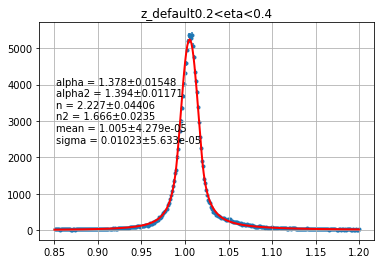

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.30523366103451693)


FCN = 387.250099142 
 TOTAL NCALL = 385 
 NCALLS = 385 
 
 
 EDM = 4.19601774673e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41 
 0.0170587 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.28832 
 0.0120109 
 
 
 
 
 No 
 
 
 2 
 n 
 1.94182 
 0.0409385 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.6982 
 0.0247521 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00583 
 4.78953e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0105566 
 6.68989e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41 & 0.0170587 & & & & & No\\
\hline
1 & alpha2 & 1.28832 & 0.0120109 & & & & & No\\
\hline
2 & n & 1.94182 & 0.0409385 & & & & & No\\
\hline
3 & n2 & 1.6982 & 0.0247521 & & & & & No\\
\hline
4 & mean & 1.00583 & 4.78953e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0105566 & 6.68989e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 387.250062519 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 5.33661870118e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41 
 0.0170558 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.28831 
 0.0120091 
 
 
 
 
 No 
 
 
 2 
 n 
 1.94182 
 0.0409338 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.69818 
 0.0247491 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00583 
 4.78946e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0105569 
 6.68899e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41 & 0.0170558 & & & & & No\\
\hline
1 & alpha2 & 1.28831 & 0.0120091 & & & & & No\\
\hline
2 & n & 1.94182 & 0.0409338 & & & & & No\\
\hline
3 & n2 & 1.69818 & 0.0247491 & & & & & No\\
\hline
4 & mean & 1.00583 & 4.78946e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0105569 & 6.68899e-05 & & & & & No\\
\hline
\end{tabular}

-2.22044604925e-16<eta<0.2


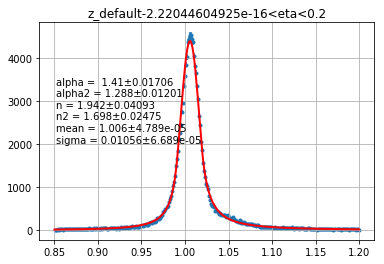

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.30723189923603594)


FCN = 331.885865298 
 TOTAL NCALL = 388 
 NCALLS = 388 
 
 
 EDM = 3.72580379689e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41295 
 0.0161362 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.28543 
 0.0124071 
 
 
 
 
 No 
 
 
 2 
 n 
 1.87563 
 0.0378062 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.63705 
 0.0244547 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00706 
 4.83021e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0105429 
 6.60981e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41295 & 0.0161362 & & & & & No\\
\hline
1 & alpha2 & 1.28543 & 0.0124071 & & & & & No\\
\hline
2 & n & 1.87563 & 0.0378062 & & & & & No\\
\hline
3 & n2 & 1.63705 & 0.0244547 & & & & & No\\
\hline
4 & mean & 1.00706 & 4.83021e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0105429 & 6.60981e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 331.885845067 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 1.70267647141e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41295 
 0.0161348 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.28542 
 0.0124055 
 
 
 
 
 No 
 
 
 2 
 n 
 1.87564 
 0.0378048 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.63703 
 0.024452 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00706 
 4.83019e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0105431 
 6.60914e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41295 & 0.0161348 & & & & & No\\
\hline
1 & alpha2 & 1.28542 & 0.0124055 & & & & & No\\
\hline
2 & n & 1.87564 & 0.0378048 & & & & & No\\
\hline
3 & n2 & 1.63703 & 0.024452 & & & & & No\\
\hline
4 & mean & 1.00706 & 4.83019e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0105431 & 6.60914e-05 & & & & & No\\
\hline
\end{tabular}

-0.2<eta<-1.66533453694e-16


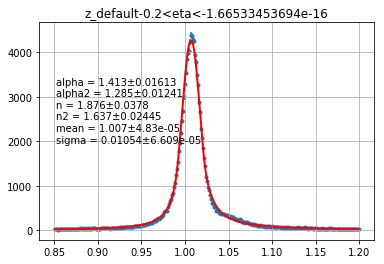

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3273619360373312)


FCN = 351.58987473 
 TOTAL NCALL = 402 
 NCALLS = 402 
 
 
 EDM = 1.87948534166e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37518 
 0.0155679 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37096 
 0.0120519 
 
 
 
 
 No 
 
 
 2 
 n 
 2.14336 
 0.0417132 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.67816 
 0.0239477 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00661 
 4.32912e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101806 
 5.94273e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37518 & 0.0155679 & & & & & No\\
\hline
1 & alpha2 & 1.37096 & 0.0120519 & & & & & No\\
\hline
2 & n & 2.14336 & 0.0417132 & & & & & No\\
\hline
3 & n2 & 1.67816 & 0.0239477 & & & & & No\\
\hline
4 & mean & 1.00661 & 4.32912e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101806 & 5.94273e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 351.589874078 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 1.81390594895e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37518 
 0.0155665 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37096 
 0.0120512 
 
 
 
 
 No 
 
 
 2 
 n 
 2.14336 
 0.0417116 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.67816 
 0.0239472 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00661 
 4.32907e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101806 
 5.94187e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37518 & 0.0155665 & & & & & No\\
\hline
1 & alpha2 & 1.37096 & 0.0120512 & & & & & No\\
\hline
2 & n & 2.14336 & 0.0417116 & & & & & No\\
\hline
3 & n2 & 1.67816 & 0.0239472 & & & & & No\\
\hline
4 & mean & 1.00661 & 4.32907e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101806 & 5.94187e-05 & & & & & No\\
\hline
\end{tabular}

-0.4<eta<-0.2


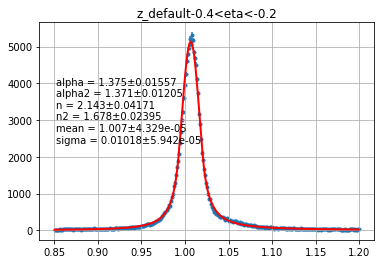

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.32459367546956674)


FCN = 289.321929176 
 TOTAL NCALL = 406 
 NCALLS = 406 
 
 
 EDM = 1.94652934204e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26316 
 0.0137004 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37496 
 0.0124189 
 
 
 
 
 No 
 
 
 2 
 n 
 1.87376 
 0.0323651 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.78227 
 0.026456 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00621 
 4.69475e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109163 
 6.63243e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26316 & 0.0137004 & & & & & No\\
\hline
1 & alpha2 & 1.37496 & 0.0124189 & & & & & No\\
\hline
2 & n & 1.87376 & 0.0323651 & & & & & No\\
\hline
3 & n2 & 1.78227 & 0.026456 & & & & & No\\
\hline
4 & mean & 1.00621 & 4.69475e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109163 & 6.63243e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 289.321929176 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 1.95010806067e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26316 
 0.0135481 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37496 
 0.0123222 
 
 
 
 
 No 
 
 
 2 
 n 
 1.87376 
 0.0322532 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.78227 
 0.0264098 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00621 
 4.68241e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109163 
 6.49723e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26316 & 0.0135481 & & & & & No\\
\hline
1 & alpha2 & 1.37496 & 0.0123222 & & & & & No\\
\hline
2 & n & 1.87376 & 0.0322532 & & & & & No\\
\hline
3 & n2 & 1.78227 & 0.0264098 & & & & & No\\
\hline
4 & mean & 1.00621 & 4.68241e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109163 & 6.49723e-05 & & & & & No\\
\hline
\end{tabular}

-0.6<eta<-0.4


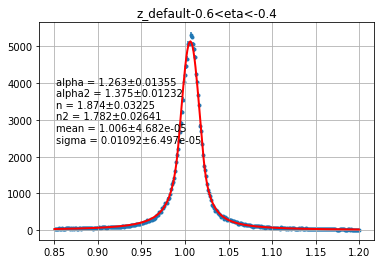

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.36122263182191267)


FCN = 349.791317192 
 TOTAL NCALL = 374 
 NCALLS = 374 
 
 
 EDM = 1.08701739448e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.3621 
 0.0149845 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.08416 
 0.0106624 
 
 
 
 
 No 
 
 
 2 
 n 
 1.90446 
 0.0348718 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.98985 
 0.0270152 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00883 
 4.79811e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109666 
 7.25073e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.3621 & 0.0149845 & & & & & No\\
\hline
1 & alpha2 & 1.08416 & 0.0106624 & & & & & No\\
\hline
2 & n & 1.90446 & 0.0348718 & & & & & No\\
\hline
3 & n2 & 1.98985 & 0.0270152 & & & & & No\\
\hline
4 & mean & 1.00883 & 4.79811e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109666 & 7.25073e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 349.791311692 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 5.36796604666e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.36209 
 0.0149797 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.08416 
 0.0106483 
 
 
 
 
 No 
 
 
 2 
 n 
 1.90445 
 0.0348684 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.98985 
 0.0269992 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00883 
 4.79616e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109667 
 7.24268e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.36209 & 0.0149797 & & & & & No\\
\hline
1 & alpha2 & 1.08416 & 0.0106483 & & & & & No\\
\hline
2 & n & 1.90445 & 0.0348684 & & & & & No\\
\hline
3 & n2 & 1.98985 & 0.0269992 & & & & & No\\
\hline
4 & mean & 1.00883 & 4.79616e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109667 & 7.24268e-05 & & & & & No\\
\hline
\end{tabular}

-0.8<eta<-0.6


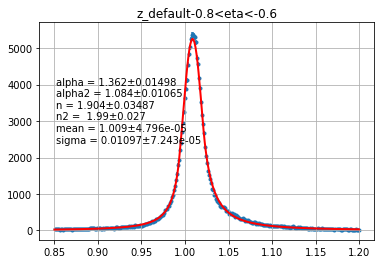

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.40605795863778926)


FCN = 343.569639377 
 TOTAL NCALL = 401 
 NCALLS = 401 
 
 
 EDM = 6.01182482786e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.45752 
 0.0138072 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.04058 
 0.00946797 
 
 
 
 
 No 
 
 
 2 
 n 
 1.71089 
 0.0290082 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.10877 
 0.0264221 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00944 
 4.51262e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0112524 
 6.57933e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.45752 & 0.0138072 & & & & & No\\
\hline
1 & alpha2 & 1.04058 & 0.00946797 & & & & & No\\
\hline
2 & n & 1.71089 & 0.0290082 & & & & & No\\
\hline
3 & n2 & 2.10877 & 0.0264221 & & & & & No\\
\hline
4 & mean & 1.00944 & 4.51262e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0112524 & 6.57933e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 343.569638428 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 5.06274831182e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.45752 
 0.0138059 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.04058 
 0.00946741 
 
 
 
 
 No 
 
 
 2 
 n 
 1.71088 
 0.0290068 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.10877 
 0.0264219 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00944 
 4.51262e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0112525 
 6.57841e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.45752 & 0.0138059 & & & & & No\\
\hline
1 & alpha2 & 1.04058 & 0.00946741 & & & & & No\\
\hline
2 & n & 1.71088 & 0.0290068 & & & & & No\\
\hline
3 & n2 & 2.10877 & 0.0264219 & & & & & No\\
\hline
4 & mean & 1.00944 & 4.51262e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0112525 & 6.57841e-05 & & & & & No\\
\hline
\end{tabular}

-1.0<eta<-0.8


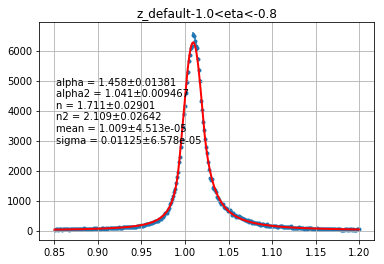

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.42364916060563496)


FCN = 309.448849562 
 TOTAL NCALL = 423 
 NCALLS = 423 
 
 
 EDM = 8.14824506765e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.21683 
 0.0110112 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.19818 
 0.00971076 
 
 
 
 
 No 
 
 
 2 
 n 
 1.95787 
 0.0306324 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.98769 
 0.0252408 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00568 
 4.72823e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0143419 
 7.54059e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.21683 & 0.0110112 & & & & & No\\
\hline
1 & alpha2 & 1.19818 & 0.00971076 & & & & & No\\
\hline
2 & n & 1.95787 & 0.0306324 & & & & & No\\
\hline
3 & n2 & 1.98769 & 0.0252408 & & & & & No\\
\hline
4 & mean & 1.00568 & 4.72823e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0143419 & 7.54059e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 309.448849562 
 TOTAL NCALL = 85 
 NCALLS = 85 
 
 
 EDM = 8.04096295745e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.21683 
 0.0108987 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.19818 
 0.00962237 
 
 
 
 
 No 
 
 
 2 
 n 
 1.95787 
 0.0305589 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.98769 
 0.0251983 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00568 
 4.72686e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0143419 
 7.38756e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.21683 & 0.0108987 & & & & & No\\
\hline
1 & alpha2 & 1.19818 & 0.00962237 & & & & & No\\
\hline
2 & n & 1.95787 & 0.0305589 & & & & & No\\
\hline
3 & n2 & 1.98769 & 0.0251983 & & & & & No\\
\hline
4 & mean & 1.00568 & 4.72686e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0143419 & 7.38756e-05 & & & & & No\\
\hline
\end{tabular}

-1.2<eta<-1.0


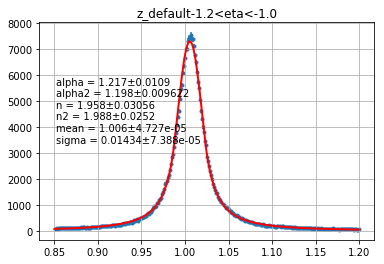

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4935661534974283)


FCN = 314.938462044 
 TOTAL NCALL = 442 
 NCALLS = 442 
 
 
 EDM = 5.47911350069e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.15722 
 0.00894742 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.53689 
 0.0091926 
 
 
 
 
 No 
 
 
 2 
 n 
 2.35827 
 0.0339417 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.3738 
 0.0169422 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00747 
 4.16091e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0150608 
 5.65583e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.15722 & 0.00894742 & & & & & No\\
\hline
1 & alpha2 & 1.53689 & 0.0091926 & & & & & No\\
\hline
2 & n & 2.35827 & 0.0339417 & & & & & No\\
\hline
3 & n2 & 1.3738 & 0.0169422 & & & & & No\\
\hline
4 & mean & 1.00747 & 4.16091e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0150608 & 5.65583e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 314.938462003 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = 5.07359505334e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.15722 
 0.00894696 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.53689 
 0.00919221 
 
 
 
 
 No 
 
 
 2 
 n 
 2.35827 
 0.0339414 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.3738 
 0.0169419 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00747 
 4.16082e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0150608 
 5.6552e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.15722 & 0.00894696 & & & & & No\\
\hline
1 & alpha2 & 1.53689 & 0.00919221 & & & & & No\\
\hline
2 & n & 2.35827 & 0.0339414 & & & & & No\\
\hline
3 & n2 & 1.3738 & 0.0169419 & & & & & No\\
\hline
4 & mean & 1.00747 & 4.16082e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0150608 & 5.6552e-05 & & & & & No\\
\hline
\end{tabular}

-1.4<eta<-1.2


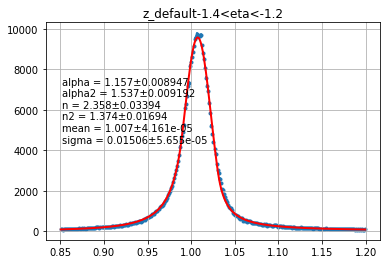

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.29496767209118274)


FCN = 264.772162445 
 TOTAL NCALL = 373 
 NCALLS = 373 
 
 
 EDM = 9.1490046203e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.20653 
 0.0182753 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18938 
 0.0151815 
 
 
 
 
 No 
 
 
 2 
 n 
 2.28382 
 0.0675401 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.97528 
 0.0434306 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00866 
 8.63014e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0179604 
 0.000142159 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.20653 & 0.0182753 & & & & & No\\
\hline
1 & alpha2 & 1.18938 & 0.0151815 & & & & & No\\
\hline
2 & n & 2.28382 & 0.0675401 & & & & & No\\
\hline
3 & n2 & 1.97528 & 0.0434306 & & & & & No\\
\hline
4 & mean & 1.00866 & 8.63014e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0179604 & 0.000142159 & & & & & No\\
\hline
\end{tabular}

FCN = 264.772159484 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 6.18775843145e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.20654 
 0.018274 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18939 
 0.0151814 
 
 
 
 
 No 
 
 
 2 
 n 
 2.28383 
 0.0675389 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.9753 
 0.0434327 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00866 
 8.63012e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0179606 
 0.000142147 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.20654 & 0.018274 & & & & & No\\
\hline
1 & alpha2 & 1.18939 & 0.0151814 & & & & & No\\
\hline
2 & n & 2.28383 & 0.0675389 & & & & & No\\
\hline
3 & n2 & 1.9753 & 0.0434327 & & & & & No\\
\hline
4 & mean & 1.00866 & 8.63012e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0179606 & 0.000142147 & & & & & No\\
\hline
\end{tabular}

-1.6<eta<-1.4


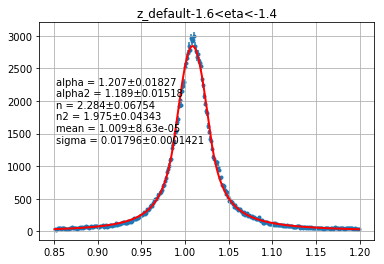

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.2743289462463813)


FCN = 325.707429537 
 TOTAL NCALL = 466 
 NCALLS = 466 
 
 
 EDM = 2.556827168e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.973711 
 0.0170845 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.26442 
 0.0155286 
 
 
 
 
 No 
 
 
 2 
 n 
 3.33419 
 0.103131 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.75705 
 0.0356408 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00883 
 9.11076e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0150695 
 0.00014155 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.973711 & 0.0170845 & & & & & No\\
\hline
1 & alpha2 & 1.26442 & 0.0155286 & & & & & No\\
\hline
2 & n & 3.33419 & 0.103131 & & & & & No\\
\hline
3 & n2 & 1.75705 & 0.0356408 & & & & & No\\
\hline
4 & mean & 1.00883 & 9.11076e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0150695 & 0.00014155 & & & & & No\\
\hline
\end{tabular}

FCN = 325.707429537 
 TOTAL NCALL = 89 
 NCALLS = 89 
 
 
 EDM = 2.51724099162e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.973711 
 0.016771 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.26442 
 0.0153308 
 
 
 
 
 No 
 
 
 2 
 n 
 3.33419 
 0.102849 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.75705 
 0.0355611 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00883 
 9.03609e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0150695 
 0.000136947 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.973711 & 0.016771 & & & & & No\\
\hline
1 & alpha2 & 1.26442 & 0.0153308 & & & & & No\\
\hline
2 & n & 3.33419 & 0.102849 & & & & & No\\
\hline
3 & n2 & 1.75705 & 0.0355611 & & & & & No\\
\hline
4 & mean & 1.00883 & 9.03609e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0150695 & 0.000136947 & & & & & No\\
\hline
\end{tabular}

1.4<eta<1.6


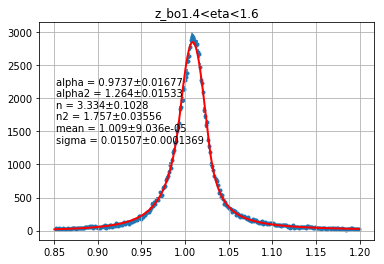

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.5268965048486863)


FCN = 301.1561653 
 TOTAL NCALL = 437 
 NCALLS = 437 
 
 
 EDM = 1.53242674839e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24009 
 0.00933287 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.19953 
 0.0081501 
 
 
 
 
 No 
 
 
 2 
 n 
 2.21883 
 0.0295249 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.14141 
 0.0233678 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0092 
 3.77e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0135232 
 5.71932e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24009 & 0.00933287 & & & & & No\\
\hline
1 & alpha2 & 1.19953 & 0.0081501 & & & & & No\\
\hline
2 & n & 2.21883 & 0.0295249 & & & & & No\\
\hline
3 & n2 & 2.14141 & 0.0233678 & & & & & No\\
\hline
4 & mean & 1.0092 & 3.77e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0135232 & 5.71932e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 301.156165296 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = 1.53204785744e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24009 
 0.00933174 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.19953 
 0.00814997 
 
 
 
 
 No 
 
 
 2 
 n 
 2.21883 
 0.0295243 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.14141 
 0.0233677 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0092 
 3.77003e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0135232 
 5.71844e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24009 & 0.00933174 & & & & & No\\
\hline
1 & alpha2 & 1.19953 & 0.00814997 & & & & & No\\
\hline
2 & n & 2.21883 & 0.0295243 & & & & & No\\
\hline
3 & n2 & 2.14141 & 0.0233677 & & & & & No\\
\hline
4 & mean & 1.0092 & 3.77003e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0135232 & 5.71844e-05 & & & & & No\\
\hline
\end{tabular}

1.2<eta<1.4


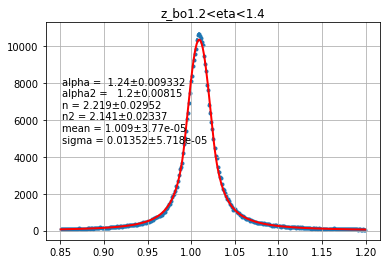

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4538281247356722)


FCN = 307.644659028 
 TOTAL NCALL = 471 
 NCALLS = 471 
 
 
 EDM = 1.48084076952e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.1992 
 0.0107076 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03779 
 0.0092054 
 
 
 
 
 No 
 
 
 2 
 n 
 1.84141 
 0.0251293 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.34139 
 0.0282373 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00824 
 4.44465e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.012509 
 7.58096e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.1992 & 0.0107076 & & & & & No\\
\hline
1 & alpha2 & 1.03779 & 0.0092054 & & & & & No\\
\hline
2 & n & 1.84141 & 0.0251293 & & & & & No\\
\hline
3 & n2 & 2.34139 & 0.0282373 & & & & & No\\
\hline
4 & mean & 1.00824 & 4.44465e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.012509 & 7.58096e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 307.644659028 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 1.47775608741e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.1992 
 0.0105392 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03779 
 0.00907831 
 
 
 
 
 No 
 
 
 2 
 n 
 1.84141 
 0.0250293 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.34139 
 0.0282016 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00824 
 4.44611e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.012509 
 7.36274e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.1992 & 0.0105392 & & & & & No\\
\hline
1 & alpha2 & 1.03779 & 0.00907831 & & & & & No\\
\hline
2 & n & 1.84141 & 0.0250293 & & & & & No\\
\hline
3 & n2 & 2.34139 & 0.0282016 & & & & & No\\
\hline
4 & mean & 1.00824 & 4.44611e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.012509 & 7.36274e-05 & & & & & No\\
\hline
\end{tabular}

1.0<eta<1.2


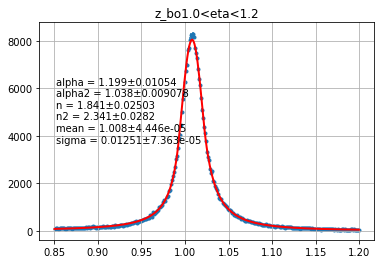

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.41198384668668103)


FCN = 306.794989438 
 TOTAL NCALL = 384 
 NCALLS = 384 
 
 
 EDM = 1.4536329035e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38891 
 0.0123236 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.27211 
 0.0104539 
 
 
 
 
 No 
 
 
 2 
 n 
 1.92981 
 0.0292831 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.76598 
 0.0214019 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00934 
 3.76355e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103632 
 5.43761e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38891 & 0.0123236 & & & & & No\\
\hline
1 & alpha2 & 1.27211 & 0.0104539 & & & & & No\\
\hline
2 & n & 1.92981 & 0.0292831 & & & & & No\\
\hline
3 & n2 & 1.76598 & 0.0214019 & & & & & No\\
\hline
4 & mean & 1.00934 & 3.76355e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103632 & 5.43761e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 306.794979137 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = 4.23491150325e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38891 
 0.0123228 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.27211 
 0.0104537 
 
 
 
 
 No 
 
 
 2 
 n 
 1.92981 
 0.0292813 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.76598 
 0.0214017 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00934 
 3.76355e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103633 
 5.43762e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38891 & 0.0123228 & & & & & No\\
\hline
1 & alpha2 & 1.27211 & 0.0104537 & & & & & No\\
\hline
2 & n & 1.92981 & 0.0292813 & & & & & No\\
\hline
3 & n2 & 1.76598 & 0.0214017 & & & & & No\\
\hline
4 & mean & 1.00934 & 3.76355e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103633 & 5.43762e-05 & & & & & No\\
\hline
\end{tabular}

0.8<eta<1.0


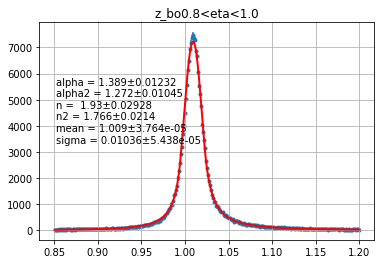

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3644563818973428)


FCN = 285.144707693 
 TOTAL NCALL = 400 
 NCALLS = 400 
 
 
 EDM = 4.38014897526e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.39082 
 0.0132475 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.12634 
 0.011859 
 
 
 
 
 No 
 
 
 2 
 n 
 1.74939 
 0.0276678 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.54992 
 0.0373947 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00805 
 4.31631e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0100702 
 6.50085e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.39082 & 0.0132475 & & & & & No\\
\hline
1 & alpha2 & 1.12634 & 0.011859 & & & & & No\\
\hline
2 & n & 1.74939 & 0.0276678 & & & & & No\\
\hline
3 & n2 & 2.54992 & 0.0373947 & & & & & No\\
\hline
4 & mean & 1.00805 & 4.31631e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0100702 & 6.50085e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 285.144686762 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 2.28722842413e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.39082 
 0.0132469 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.12633 
 0.0118577 
 
 
 
 
 No 
 
 
 2 
 n 
 1.74939 
 0.0276668 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.54991 
 0.0373904 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00805 
 4.31627e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0100703 
 6.5008e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.39082 & 0.0132469 & & & & & No\\
\hline
1 & alpha2 & 1.12633 & 0.0118577 & & & & & No\\
\hline
2 & n & 1.74939 & 0.0276668 & & & & & No\\
\hline
3 & n2 & 2.54991 & 0.0373904 & & & & & No\\
\hline
4 & mean & 1.00805 & 4.31627e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0100703 & 6.5008e-05 & & & & & No\\
\hline
\end{tabular}

0.6<eta<0.8


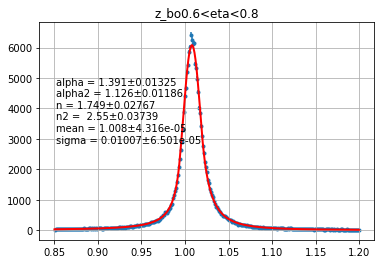

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3457852967069728)


FCN = 262.971809787 
 TOTAL NCALL = 454 
 NCALLS = 454 
 
 
 EDM = 2.87913077098e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37839 
 0.0133423 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.16343 
 0.0125091 
 
 
 
 
 No 
 
 
 2 
 n 
 1.70133 
 0.0270867 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.55148 
 0.0393317 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 4.33127e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00992775 
 6.48343e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37839 & 0.0133423 & & & & & No\\
\hline
1 & alpha2 & 1.16343 & 0.0125091 & & & & & No\\
\hline
2 & n & 1.70133 & 0.0270867 & & & & & No\\
\hline
3 & n2 & 2.55148 & 0.0393317 & & & & & No\\
\hline
4 & mean & 1.00766 & 4.33127e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00992775 & 6.48343e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 262.971809379 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 2.4704274966e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37839 
 0.0133411 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.16343 
 0.0125078 
 
 
 
 
 No 
 
 
 2 
 n 
 1.70133 
 0.0270859 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.55148 
 0.0393305 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 4.33126e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00992778 
 6.48232e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37839 & 0.0133411 & & & & & No\\
\hline
1 & alpha2 & 1.16343 & 0.0125078 & & & & & No\\
\hline
2 & n & 1.70133 & 0.0270859 & & & & & No\\
\hline
3 & n2 & 2.55148 & 0.0393305 & & & & & No\\
\hline
4 & mean & 1.00766 & 4.33126e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00992778 & 6.48232e-05 & & & & & No\\
\hline
\end{tabular}

0.4<eta<0.6


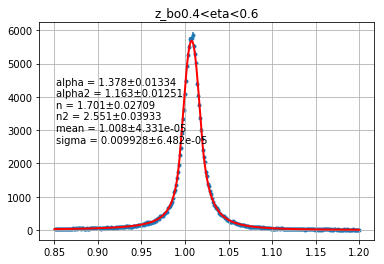

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3505171207226427)


FCN = 273.821530792 
 TOTAL NCALL = 415 
 NCALLS = 415 
 
 
 EDM = 1.24254394132e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.52729 
 0.0155103 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.13843 
 0.0119656 
 
 
 
 
 No 
 
 
 2 
 n 
 1.9365 
 0.036015 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.52712 
 0.0377482 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.008 
 4.22524e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00948846 
 5.86474e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.52729 & 0.0155103 & & & & & No\\
\hline
1 & alpha2 & 1.13843 & 0.0119656 & & & & & No\\
\hline
2 & n & 1.9365 & 0.036015 & & & & & No\\
\hline
3 & n2 & 2.52712 & 0.0377482 & & & & & No\\
\hline
4 & mean & 1.008 & 4.22524e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00948846 & 5.86474e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 273.82152913 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 1.07628013298e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.52729 
 0.0155083 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.13843 
 0.0119642 
 
 
 
 
 No 
 
 
 2 
 n 
 1.9365 
 0.0360128 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.52712 
 0.037747 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.008 
 4.2252e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00948851 
 5.86366e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.52729 & 0.0155083 & & & & & No\\
\hline
1 & alpha2 & 1.13843 & 0.0119642 & & & & & No\\
\hline
2 & n & 1.9365 & 0.0360128 & & & & & No\\
\hline
3 & n2 & 2.52712 & 0.037747 & & & & & No\\
\hline
4 & mean & 1.008 & 4.2252e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00948851 & 5.86366e-05 & & & & & No\\
\hline
\end{tabular}

0.2<eta<0.4


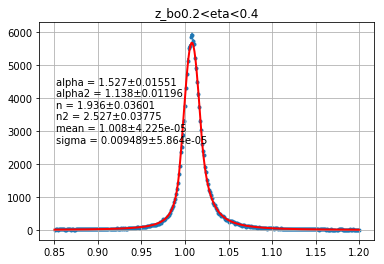

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3253550830435729)


FCN = 298.975584803 
 TOTAL NCALL = 443 
 NCALLS = 443 
 
 
 EDM = 3.77478119613e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.48594 
 0.0167971 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.05497 
 0.012812 
 
 
 
 
 No 
 
 
 2 
 n 
 1.86006 
 0.0361602 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.48946 
 0.0390294 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00759 
 4.92742e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00956026 
 7.25777e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.48594 & 0.0167971 & & & & & No\\
\hline
1 & alpha2 & 1.05497 & 0.012812 & & & & & No\\
\hline
2 & n & 1.86006 & 0.0361602 & & & & & No\\
\hline
3 & n2 & 2.48946 & 0.0390294 & & & & & No\\
\hline
4 & mean & 1.00759 & 4.92742e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00956026 & 7.25777e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 298.975584803 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 3.71294480684e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.48594 
 0.0164902 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.05497 
 0.0126007 
 
 
 
 
 No 
 
 
 2 
 n 
 1.86006 
 0.0359287 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.48946 
 0.0389231 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00759 
 4.91503e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00956026 
 7.03515e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.48594 & 0.0164902 & & & & & No\\
\hline
1 & alpha2 & 1.05497 & 0.0126007 & & & & & No\\
\hline
2 & n & 1.86006 & 0.0359287 & & & & & No\\
\hline
3 & n2 & 2.48946 & 0.0389231 & & & & & No\\
\hline
4 & mean & 1.00759 & 4.91503e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00956026 & 7.03515e-05 & & & & & No\\
\hline
\end{tabular}

-2.22044604925e-16<eta<0.2


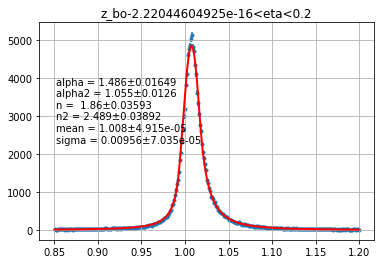

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.32129788958747113)


FCN = 244.601935951 
 TOTAL NCALL = 448 
 NCALLS = 448 
 
 
 EDM = 6.63702742586e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.50275 
 0.0167292 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.969461 
 0.0116298 
 
 
 
 
 No 
 
 
 2 
 n 
 1.76079 
 0.0343104 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.53791 
 0.0384314 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00749 
 5.21334e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00953008 
 7.31361e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.50275 & 0.0167292 & & & & & No\\
\hline
1 & alpha2 & 0.969461 & 0.0116298 & & & & & No\\
\hline
2 & n & 1.76079 & 0.0343104 & & & & & No\\
\hline
3 & n2 & 2.53791 & 0.0384314 & & & & & No\\
\hline
4 & mean & 1.00749 & 5.21334e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00953008 & 7.31361e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 244.601931673 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 2.35947936917e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.50275 
 0.0167268 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.969461 
 0.0116282 
 
 
 
 
 No 
 
 
 2 
 n 
 1.76079 
 0.0343081 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.53791 
 0.0384294 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00749 
 5.21316e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00953017 
 7.31219e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.50275 & 0.0167268 & & & & & No\\
\hline
1 & alpha2 & 0.969461 & 0.0116282 & & & & & No\\
\hline
2 & n & 1.76079 & 0.0343081 & & & & & No\\
\hline
3 & n2 & 2.53791 & 0.0384294 & & & & & No\\
\hline
4 & mean & 1.00749 & 5.21316e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00953017 & 7.31219e-05 & & & & & No\\
\hline
\end{tabular}

-0.2<eta<-1.66533453694e-16


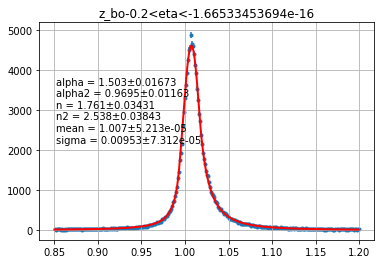

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3470513617078447)


FCN = 315.892148246 
 TOTAL NCALL = 415 
 NCALLS = 415 
 
 
 EDM = 1.11874396924e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.55612 
 0.016186 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03853 
 0.0119033 
 
 
 
 
 No 
 
 
 2 
 n 
 1.833 
 0.0348673 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.63436 
 0.0398283 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00792 
 4.73053e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00952523 
 6.56148e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.55612 & 0.016186 & & & & & No\\
\hline
1 & alpha2 & 1.03853 & 0.0119033 & & & & & No\\
\hline
2 & n & 1.833 & 0.0348673 & & & & & No\\
\hline
3 & n2 & 2.63436 & 0.0398283 & & & & & No\\
\hline
4 & mean & 1.00792 & 4.73053e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00952523 & 6.56148e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 315.892148246 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = 9.19301693012e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.55612 
 0.0159163 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03853 
 0.0117021 
 
 
 
 
 No 
 
 
 2 
 n 
 1.833 
 0.0346683 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.63436 
 0.0396999 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00792 
 4.70906e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00952523 
 6.36743e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.55612 & 0.0159163 & & & & & No\\
\hline
1 & alpha2 & 1.03853 & 0.0117021 & & & & & No\\
\hline
2 & n & 1.833 & 0.0346683 & & & & & No\\
\hline
3 & n2 & 2.63436 & 0.0396999 & & & & & No\\
\hline
4 & mean & 1.00792 & 4.70906e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00952523 & 6.36743e-05 & & & & & No\\
\hline
\end{tabular}

-0.4<eta<-0.2


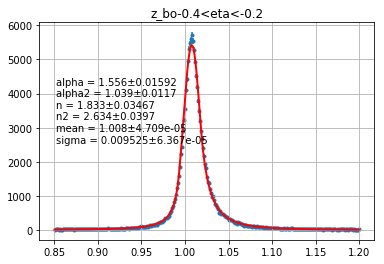

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.3430504941328826)


FCN = 264.027950677 
 TOTAL NCALL = 435 
 NCALLS = 435 
 
 
 EDM = 2.37456510825e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35836 
 0.0133683 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.13914 
 0.0124792 
 
 
 
 
 No 
 
 
 2 
 n 
 1.67535 
 0.0268302 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.49507 
 0.0382516 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00773 
 4.54731e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101933 
 6.92104e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35836 & 0.0133683 & & & & & No\\
\hline
1 & alpha2 & 1.13914 & 0.0124792 & & & & & No\\
\hline
2 & n & 1.67535 & 0.0268302 & & & & & No\\
\hline
3 & n2 & 2.49507 & 0.0382516 & & & & & No\\
\hline
4 & mean & 1.00773 & 4.54731e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101933 & 6.92104e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 264.027950672 
 TOTAL NCALL = 105 
 NCALLS = 105 
 
 
 EDM = 1.82968142054e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35836 
 0.0133672 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.13914 
 0.0124781 
 
 
 
 
 No 
 
 
 2 
 n 
 1.67535 
 0.0268296 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.49507 
 0.0382511 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00773 
 4.5473e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101933 
 6.91993e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35836 & 0.0133672 & & & & & No\\
\hline
1 & alpha2 & 1.13914 & 0.0124781 & & & & & No\\
\hline
2 & n & 1.67535 & 0.0268296 & & & & & No\\
\hline
3 & n2 & 2.49507 & 0.0382511 & & & & & No\\
\hline
4 & mean & 1.00773 & 4.5473e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101933 & 6.91993e-05 & & & & & No\\
\hline
\end{tabular}

-0.6<eta<-0.4


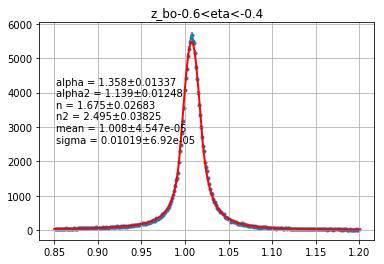

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.365487727790346)


FCN = 269.399156217 
 TOTAL NCALL = 402 
 NCALLS = 402 
 
 
 EDM = 2.57979631753e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41131 
 0.0138937 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.05967 
 0.0111309 
 
 
 
 
 No 
 
 
 2 
 n 
 1.78261 
 0.0291068 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.38752 
 0.0328565 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00793 
 4.43288e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00988505 
 6.61843e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41131 & 0.0138937 & & & & & No\\
\hline
1 & alpha2 & 1.05967 & 0.0111309 & & & & & No\\
\hline
2 & n & 1.78261 & 0.0291068 & & & & & No\\
\hline
3 & n2 & 2.38752 & 0.0328565 & & & & & No\\
\hline
4 & mean & 1.00793 & 4.43288e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00988505 & 6.61843e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 269.399155781 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 2.53611699079e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41131 
 0.0138922 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.05967 
 0.0111298 
 
 
 
 
 No 
 
 
 2 
 n 
 1.78261 
 0.0291058 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.38752 
 0.0328562 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00793 
 4.43285e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00988509 
 6.61718e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41131 & 0.0138922 & & & & & No\\
\hline
1 & alpha2 & 1.05967 & 0.0111298 & & & & & No\\
\hline
2 & n & 1.78261 & 0.0291058 & & & & & No\\
\hline
3 & n2 & 2.38752 & 0.0328562 & & & & & No\\
\hline
4 & mean & 1.00793 & 4.43285e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00988509 & 6.61718e-05 & & & & & No\\
\hline
\end{tabular}

-0.8<eta<-0.6


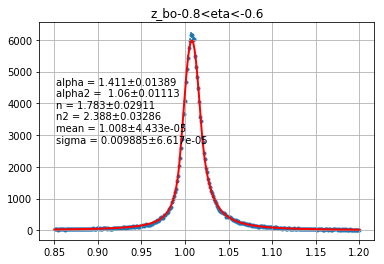

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4026646104148396)


FCN = 296.723503028 
 TOTAL NCALL = 441 
 NCALLS = 441 
 
 
 EDM = 7.28057720521e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41473 
 0.0128732 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.10255 
 0.00986492 
 
 
 
 
 No 
 
 
 2 
 n 
 1.85139 
 0.0286069 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.99655 
 0.0232824 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 4.02799e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101449 
 5.94798e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41473 & 0.0128732 & & & & & No\\
\hline
1 & alpha2 & 1.10255 & 0.00986492 & & & & & No\\
\hline
2 & n & 1.85139 & 0.0286069 & & & & & No\\
\hline
3 & n2 & 1.99655 & 0.0232824 & & & & & No\\
\hline
4 & mean & 1.00766 & 4.02799e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101449 & 5.94798e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 296.723502957 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 6.57026731552e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41473 
 0.0128731 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.10255 
 0.00986497 
 
 
 
 
 No 
 
 
 2 
 n 
 1.85139 
 0.0286068 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.99655 
 0.0232824 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 4.02804e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101449 
 5.94806e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41473 & 0.0128731 & & & & & No\\
\hline
1 & alpha2 & 1.10255 & 0.00986497 & & & & & No\\
\hline
2 & n & 1.85139 & 0.0286068 & & & & & No\\
\hline
3 & n2 & 1.99655 & 0.0232824 & & & & & No\\
\hline
4 & mean & 1.00766 & 4.02804e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101449 & 5.94806e-05 & & & & & No\\
\hline
\end{tabular}

-1.0<eta<-0.8


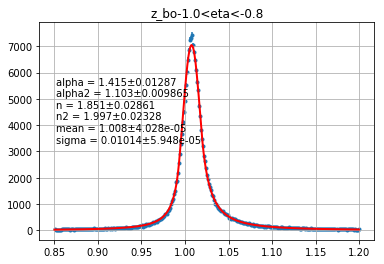

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.4394253246928577)


FCN = 322.357489038 
 TOTAL NCALL = 467 
 NCALLS = 467 
 
 
 EDM = 2.26322882086e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23365 
 0.0106161 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03825 
 0.00908373 
 
 
 
 
 No 
 
 
 2 
 n 
 1.90246 
 0.0265402 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.50598 
 0.0309418 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00581 
 4.42329e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0127208 
 7.26459e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23365 & 0.0106161 & & & & & No\\
\hline
1 & alpha2 & 1.03825 & 0.00908373 & & & & & No\\
\hline
2 & n & 1.90246 & 0.0265402 & & & & & No\\
\hline
3 & n2 & 2.50598 & 0.0309418 & & & & & No\\
\hline
4 & mean & 1.00581 & 4.42329e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0127208 & 7.26459e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 322.357489038 
 TOTAL NCALL = 94 
 NCALLS = 94 
 
 
 EDM = 2.26880632733e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23365 
 0.0104636 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03825 
 0.00896112 
 
 
 
 
 No 
 
 
 2 
 n 
 1.90246 
 0.026453 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.50598 
 0.0309013 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00581 
 4.42324e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0127208 
 7.06316e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23365 & 0.0104636 & & & & & No\\
\hline
1 & alpha2 & 1.03825 & 0.00896112 & & & & & No\\
\hline
2 & n & 1.90246 & 0.026453 & & & & & No\\
\hline
3 & n2 & 2.50598 & 0.0309013 & & & & & No\\
\hline
4 & mean & 1.00581 & 4.42324e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0127208 & 7.06316e-05 & & & & & No\\
\hline
\end{tabular}

-1.2<eta<-1.0


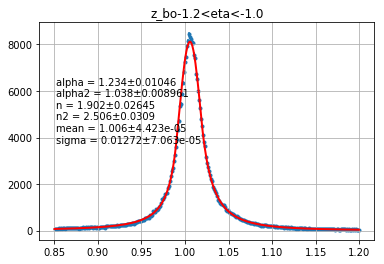

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.5213115531790239)


FCN = 327.47957721 
 TOTAL NCALL = 449 
 NCALLS = 449 
 
 
 EDM = 2.65703167418e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.27204 
 0.00952813 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18208 
 0.0083582 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22671 
 0.0304502 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.20237 
 0.0245745 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 3.82596e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0138416 
 5.90623e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.27204 & 0.00952813 & & & & & No\\
\hline
1 & alpha2 & 1.18208 & 0.0083582 & & & & & No\\
\hline
2 & n & 2.22671 & 0.0304502 & & & & & No\\
\hline
3 & n2 & 2.20237 & 0.0245745 & & & & & No\\
\hline
4 & mean & 1.00766 & 3.82596e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0138416 & 5.90623e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 327.479577198 
 TOTAL NCALL = 102 
 NCALLS = 102 
 
 
 EDM = 2.53872216972e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.27204 
 0.0095281 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18208 
 0.00835821 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22671 
 0.0304502 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.20237 
 0.0245745 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00766 
 3.82597e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0138416 
 5.90625e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.27204 & 0.0095281 & & & & & No\\
\hline
1 & alpha2 & 1.18208 & 0.00835821 & & & & & No\\
\hline
2 & n & 2.22671 & 0.0304502 & & & & & No\\
\hline
3 & n2 & 2.20237 & 0.0245745 & & & & & No\\
\hline
4 & mean & 1.00766 & 3.82597e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0138416 & 5.90625e-05 & & & & & No\\
\hline
\end{tabular}

-1.4<eta<-1.2


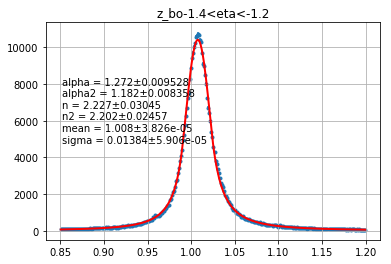

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:81: SmallIntegralWarning: (1.0, 1.0, 6.0, 4.0, 0.97, -0.28931971878301177)


FCN = 308.262780529 
 TOTAL NCALL = 423 
 NCALLS = 423 
 
 
 EDM = 5.13745383211e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.18042 
 0.017165 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.09519 
 0.0150661 
 
 
 
 
 No 
 
 
 2 
 n 
 2.1708 
 0.0561034 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.65713 
 0.0590465 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00645 
 7.94919e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0161105 
 0.000137869 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.18042 & 0.017165 & & & & & No\\
\hline
1 & alpha2 & 1.09519 & 0.0150661 & & & & & No\\
\hline
2 & n & 2.1708 & 0.0561034 & & & & & No\\
\hline
3 & n2 & 2.65713 & 0.0590465 & & & & & No\\
\hline
4 & mean & 1.00645 & 7.94919e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0161105 & 0.000137869 & & & & & No\\
\hline
\end{tabular}

FCN = 308.262734561 
 TOTAL NCALL = 95 
 NCALLS = 95 
 
 
 EDM = 5.40642659535e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.18044 
 0.0171698 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.0952 
 0.0150656 
 
 
 
 
 No 
 
 
 2 
 n 
 2.1709 
 0.0561304 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.65718 
 0.0590504 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00645 
 7.94947e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0161106 
 0.000137854 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.18044 & 0.0171698 & & & & & No\\
\hline
1 & alpha2 & 1.0952 & 0.0150656 & & & & & No\\
\hline
2 & n & 2.1709 & 0.0561304 & & & & & No\\
\hline
3 & n2 & 2.65718 & 0.0590504 & & & & & No\\
\hline
4 & mean & 1.00645 & 7.94947e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0161106 & 0.000137854 & & & & & No\\
\hline
\end{tabular}

-1.6<eta<-1.4


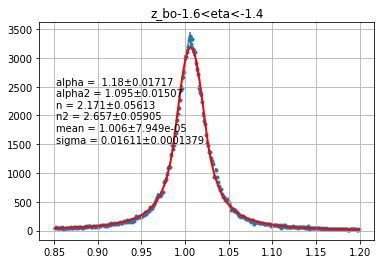

In [62]:
Tipe=['target','z_default','z_bo']
n=16

mean_eta_un=np.zeros((n))
mean_eta_de=np.zeros((n))
mean_eta_bo=np.zeros((n))

mean_err_eta_un=np.zeros((n))
mean_err_eta_de=np.zeros((n))
mean_err_eta_bo=np.zeros((n))

sigma_eta_un=np.zeros((n))
sigma_eta_de=np.zeros((n))
sigma_eta_bo=np.zeros((n))

sigma_err_eta_un=np.zeros((n))
sigma_err_eta_de=np.zeros((n))
sigma_err_eta_bo=np.zeros((n))

feat=[]
eta=np.zeros((n))
nbins=300
for i in range (n):
    a=1.4-0.2*i
    b=a+0.2
    eta[i]= (a+b)/2
    feat.append(str(a)+'<eta<'+str(b))
i=0
for tipe in Tipe:
    for para in feat:
        if tipe=='target':
            rmin = 0.83
            rmax = 1.1
        else:
            rmin=0.85
            rmax=1.2
        df=data.query(para).astype('double')
        df=df[tipe]
        bound_DCB=[rmin, rmax]
        normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
        binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
        for j in range(2):
        #first step
            if j==0: 
                pars_dcb = dict(mean  = 0.97, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 6,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
                           
        #optimize parameter withoptimized start parameter
            else:
                pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
            minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
            minuit.migrad() #optimized parameter
     
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
        binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
        if tipe=='target':
            mean_eta_un[i]=minuit.values['mean']
            mean_err_eta_un[i]=minuit.errors['mean']
            sigma_eta_un[i]=minuit.values['sigma']
            sigma_err_eta_un[i]=minuit.errors['sigma']
        if tipe=='z_default':
            mean_eta_de[i]=minuit.values['mean']
            mean_err_eta_de[i]=minuit.errors['mean']
            sigma_eta_de[i]=minuit.values['sigma']
            sigma_err_eta_de[i]=minuit.errors['sigma']       
        if tipe=='z_bo':
            mean_eta_bo[i]=minuit.values['mean']
            mean_err_eta_bo[i]=minuit.errors['mean']
            sigma_eta_bo[i]=minuit.values['sigma']
            sigma_err_eta_bo[i]=minuit.errors['sigma'] 
        print(para)
    
        i+=1
        if i==16:
            i=0
        
        plt.title(tipe+para)
        plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
        plt.show()
np.savetxt('eta_parameter.csv', (mean_eta_un,sigma_eta_un,mean_eta_de,sigma_eta_de,mean_eta_bo,sigma_eta_bo), delimiter=',')

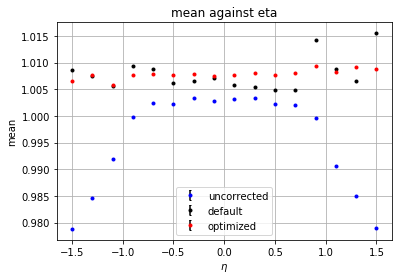

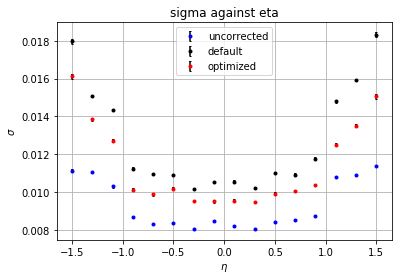

In [63]:
plt.figure()
plt.errorbar(eta,mean_eta_un, yerr=mean_err_eta_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(eta,mean_eta_de, yerr=mean_err_eta_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(eta,mean_eta_bo, yerr=mean_err_eta_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('mean against eta')
plt.xlabel('$\eta$')
plt.ylabel('mean')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','mean_against_eta'+'.png'))

plt.show()

plt.figure()
plt.errorbar(eta,sigma_eta_un, yerr=sigma_err_eta_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(eta,sigma_eta_de, yerr=sigma_err_eta_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(eta,sigma_eta_bo, yerr=sigma_err_eta_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('sigma against eta')
plt.xlabel('$\eta$')
plt.ylabel('$\sigma$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','sigma_against_eta'+'.png'))

plt.show()

#  PT

0


<Figure size 432x288 with 0 Axes>

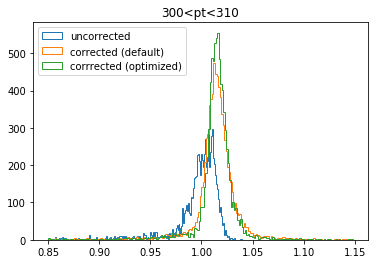

1


<Figure size 432x288 with 0 Axes>

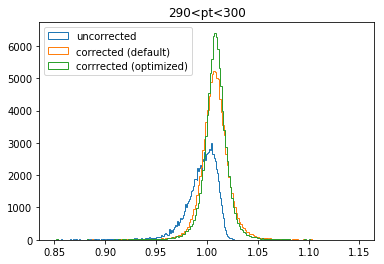

2


<Figure size 432x288 with 0 Axes>

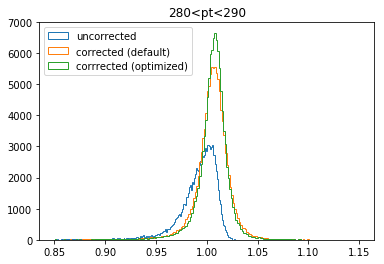

3


<Figure size 432x288 with 0 Axes>

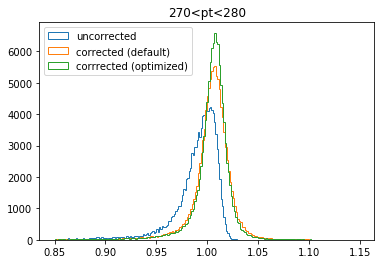

4


<Figure size 432x288 with 0 Axes>

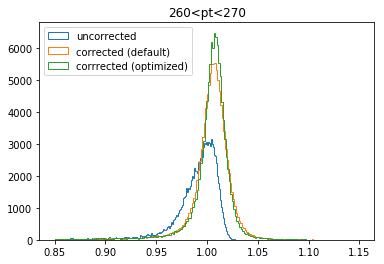

5


<Figure size 432x288 with 0 Axes>

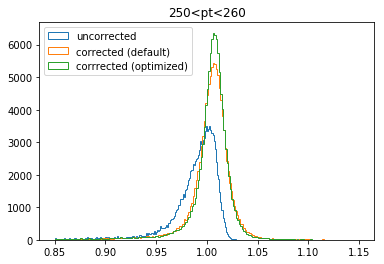

6


<Figure size 432x288 with 0 Axes>

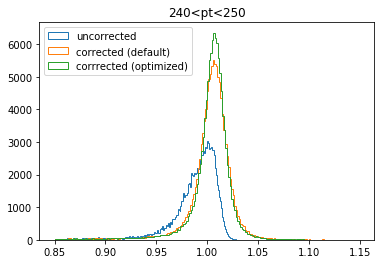

7


<Figure size 432x288 with 0 Axes>

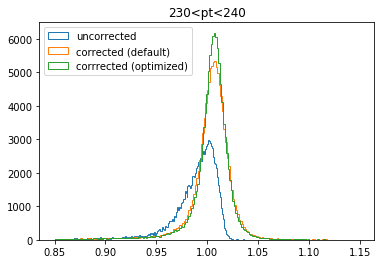

8


<Figure size 432x288 with 0 Axes>

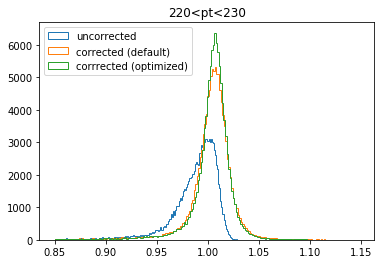

9


<Figure size 432x288 with 0 Axes>

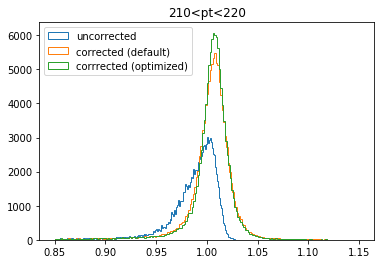

10


<Figure size 432x288 with 0 Axes>

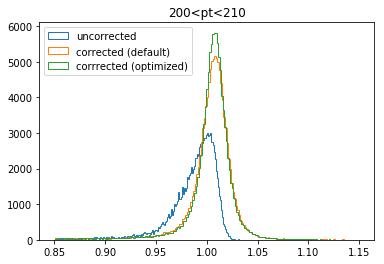

11


<Figure size 432x288 with 0 Axes>

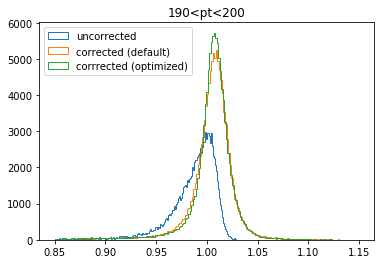

12


<Figure size 432x288 with 0 Axes>

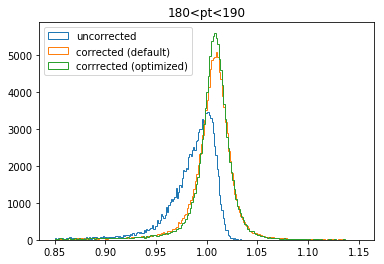

13


<Figure size 432x288 with 0 Axes>

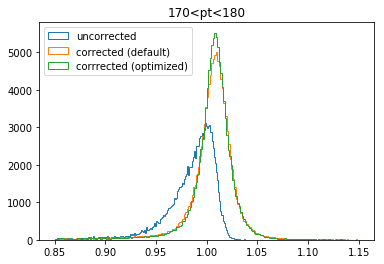

14


<Figure size 432x288 with 0 Axes>

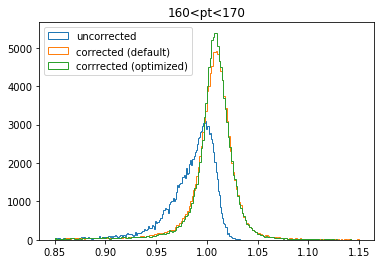

15


<Figure size 432x288 with 0 Axes>

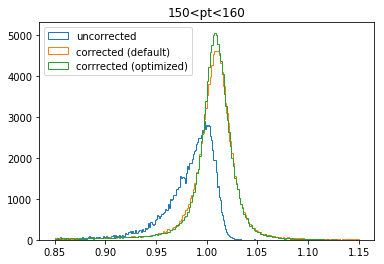

16


<Figure size 432x288 with 0 Axes>

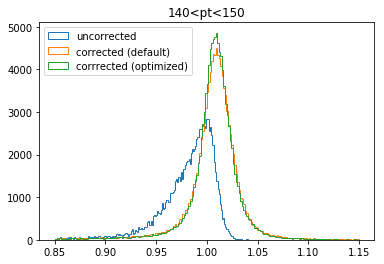

17


<Figure size 432x288 with 0 Axes>

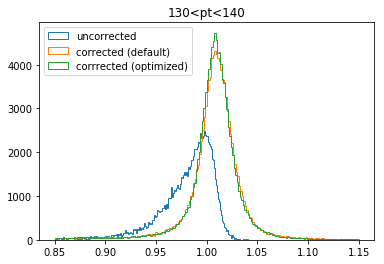

18


<Figure size 432x288 with 0 Axes>

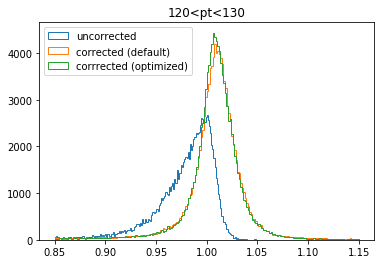

19


<Figure size 432x288 with 0 Axes>

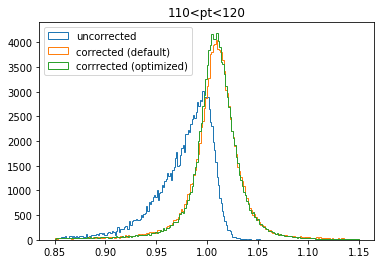

20


<Figure size 432x288 with 0 Axes>

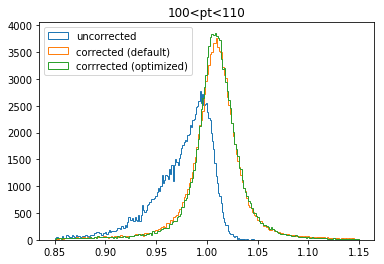

21


<Figure size 432x288 with 0 Axes>

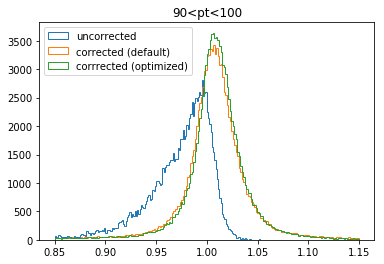

22


<Figure size 432x288 with 0 Axes>

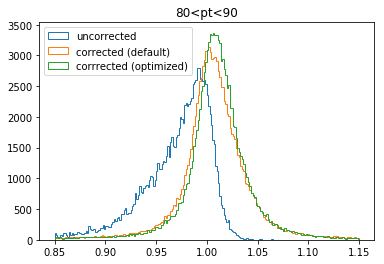

23


<Figure size 432x288 with 0 Axes>

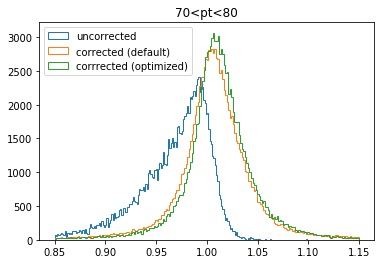

24


<Figure size 432x288 with 0 Axes>

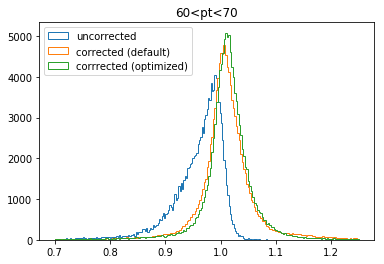

25


<Figure size 432x288 with 0 Axes>

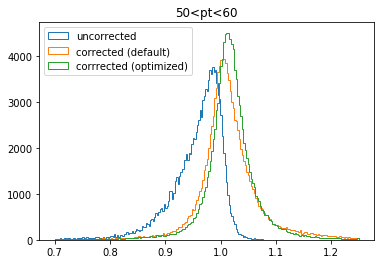

26


<Figure size 432x288 with 0 Axes>

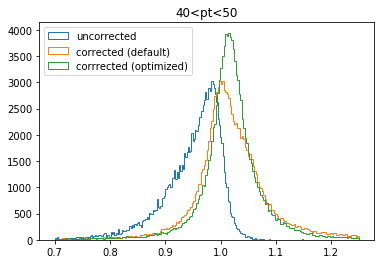

27


<Figure size 432x288 with 0 Axes>

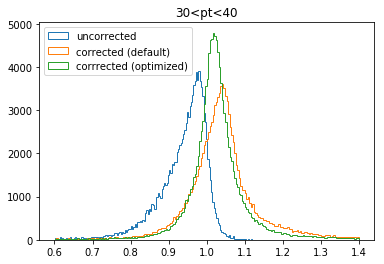

28


<Figure size 432x288 with 0 Axes>

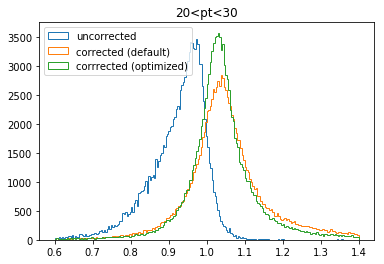

In [21]:
n=29
pt=np.zeros((n))
mean_pt=np.zeros((n))
err_mean_pt=np.zeros((n))
sigma_pt=np.zeros((n))
err_sigma_pt=np.zeros((n))

feat_pt=[]
for i in range (n):
    a=300-10*i
    b=a+10
    pt[i]= (a+b)/2
    feat_pt.append(str(a)+'<pt<'+str(b))
i=0

for para in feat_pt:
    plt.figure()
    df=DF.query(para).astype('double')
    if i<=23:
        rmin = 0.85
        rmax = 1.15
    elif 23<i<27:
        rmin=0.7
        rmax=1.25
    else:
        rmin=0.6
        rmax=1.4
    plt.figure()
    df=data.query(para).astype('double')
    dft=df.query(str(rmin)+'<target<'+str(rmax)).astype('double')
    dfd=df.query(str(rmin)+'<z_default<'+str(rmax)).astype('double')
    dfo=df.query(str(rmin)+'<z_bo<'+str(rmax)).astype('double')
    nbins = 200
    plt.hist(dft['target'],bins=nbins,histtype='step',label='uncorrected',density=0)
    plt.hist(dfd['z_default'],bins=nbins,histtype='step',label='corrected (default)',density=0)
    plt.hist(dfo['z_bo'],bins=nbins,histtype='step',label='corrrected (optimized)',density=0)
    plt.title(para)
    plt.legend(loc=2)
    plt.savefig(os.path.join(out_dir+'plot','split_in_pt_'+para+'.png'))
    print(i)
    plt.show()
    i+=1

In [32]:
Tipe=['target','z_default','z_bo']
n=29

mean_pt_un=np.zeros((n))
mean_pt_de=np.zeros((n))
mean_pt_bo=np.zeros((n))

mean_err_pt_un=np.zeros((n))
mean_err_pt_de=np.zeros((n))
mean_err_pt_bo=np.zeros((n))

sigma_pt_un=np.zeros((n))
sigma_pt_de=np.zeros((n))
sigma_pt_bo=np.zeros((n))

sigma_err_pt_un=np.zeros((n))
sigma_err_pt_de=np.zeros((n))
sigma_err_pt_bo=np.zeros((n))

pt=np.zeros((n))
feat_pt=[]
for i in range (n):
    a=300-10*i
    b=a+10
    pt[i]= (a+b)/2
    feat_pt.append(str(a)+'<pt<'+str(b))
nbins=200

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.8065073949895543, 2.8872661165554323, 0.9004079131786037, 9.389139822779528, 1.0023110597796268, 0.013)


FCN = 807.075360924 
 TOTAL NCALL = 537 
 NCALLS = 537 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.8417 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.47806 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00089 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.0773 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0019 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.8417 & nan & & & & & No\\
\hline
1 & alpha2 & 5.47806 & nan & & & & & No\\
\hline
2 & n & 1.00089 & nan & & & & & No\\
\hline
3 & n2 & 14.0773 & nan & & & & & No\\
\hline
4 & mean & 1.0019 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 595.029922856 
 TOTAL NCALL = 28 
 NCALLS = 28 
 
 
 EDM = 3.16631842472e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.8417 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 5.47806 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00089 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 14.0773 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0019 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0104446 
 0.000106622 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.8417 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 5.47806 & 1 & & & & & Yes\\
\hline
2 & n & 1.00089 & 1 & & & & & Yes\\
\hline
3 & n2 & 14.0773 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0019 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0104446 & 0.000106622 & & & & & No\\
\hline
\end{tabular}

FCN = 594.742759937 
 TOTAL NCALL = 71 
 NCALLS = 71 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.84127 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.53429 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00048 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.1454 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00191 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0104437 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.84127 & nan & & & & & No\\
\hline
1 & alpha2 & 5.53429 & nan & & & & & No\\
\hline
2 & n & 1.00048 & nan & & & & & No\\
\hline
3 & n2 & 14.1454 & nan & & & & & No\\
\hline
4 & mean & 1.00191 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0104437 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 588.486104559 
 TOTAL NCALL = 72 
 NCALLS = 72 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.77222 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.8214 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00048 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 23.96 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00191 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0104437 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.77222 & nan & & & & & No\\
\hline
1 & alpha2 & 5.8214 & nan & & & & & No\\
\hline
2 & n & 1.00048 & nan & & & & & No\\
\hline
3 & n2 & 23.96 & nan & & & & & No\\
\hline
4 & mean & 1.00191 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0104437 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 524.838305297 
 TOTAL NCALL = 185 
 NCALLS = 185 
 
 
 EDM = 7.00807119606e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.2547 
 0.050753 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 300.357 
 54.4462 
 
 
 
 
 No 
 
 
 2 
 n 
 1.82495 
 0.116568 
 
 
 
 
 No 
 
 
 3 
 n2 
 23.96 
 1 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0038 
 0.000170796 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00928913 
 0.000137032 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.2547 & 0.050753 & & & & & No\\
\hline
1 & alpha2 & 300.357 & 54.4462 & & & & & No\\
\hline
2 & n & 1.82495 & 0.116568 & & & & & No\\
\hline
3 & n2 & 23.96 & 1 & & & & & No\\
\hline
4 & mean & 1.0038 & 0.000170796 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00928913 & 0.000137032 & & & & & No\\
\hline
\end{tabular}

300<pt<310
0


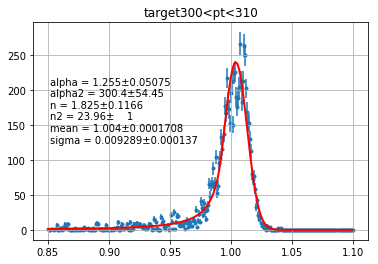

FCN = 4384.06462298 
 TOTAL NCALL = 379 
 NCALLS = 379 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.60027 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.86225 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 2.69859 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.801 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.996609 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.60027 & nan & & & & & No\\
\hline
1 & alpha2 & 5.86225 & nan & & & & & No\\
\hline
2 & n & 2.69859 & nan & & & & & No\\
\hline
3 & n2 & 14.801 & nan & & & & & No\\
\hline
4 & mean & 0.996609 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.6002681634108298, 5.862245376477742, 2.698587939436908, 14.801035847345828, 0.9966087912864976, -0.03272442548074237)


FCN = 3467.84924958 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 1.60193362095e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.60027 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 5.86225 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.69859 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 14.801 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.996609 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0114989 
 3.20729e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.60027 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 5.86225 & 1 & & & & & Yes\\
\hline
2 & n & 2.69859 & 1 & & & & & Yes\\
\hline
3 & n2 & 14.801 & 1 & & & & & Yes\\
\hline
4 & mean & 0.996609 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0114989 & 3.20729e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 2344.37301484 
 TOTAL NCALL = 106 
 NCALLS = 106 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.880059 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 46.1732 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 4.25914 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 51.6219 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999427 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00919382 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.880059 & nan & & & & & No\\
\hline
1 & alpha2 & 46.1732 & nan & & & & & No\\
\hline
2 & n & 4.25914 & nan & & & & & No\\
\hline
3 & n2 & 51.6219 & nan & & & & & No\\
\hline
4 & mean & 0.999427 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00919382 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 2063.71064692 
 TOTAL NCALL = 59 
 NCALLS = 59 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.818834 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 46.1732 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 6.94164 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 51.6219 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999427 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.00919382 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.818834 & nan & & & & & No\\
\hline
1 & alpha2 & 46.1732 & nan & & & & & No\\
\hline
2 & n & 6.94164 & nan & & & & & No\\
\hline
3 & n2 & 51.6219 & nan & & & & & No\\
\hline
4 & mean & 0.999427 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.00919382 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1907.55317253 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.653253 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 46.1732 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 9.20868 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 51.6219 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0011 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00831512 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.653253 & nan & & & & & No\\
\hline
1 & alpha2 & 46.1732 & nan & & & & & No\\
\hline
2 & n & 9.20868 & nan & & & & & No\\
\hline
3 & n2 & 51.6219 & nan & & & & & No\\
\hline
4 & mean & 1.0011 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00831512 & nan & & & & & No\\
\hline
\end{tabular}

290<pt<300
1


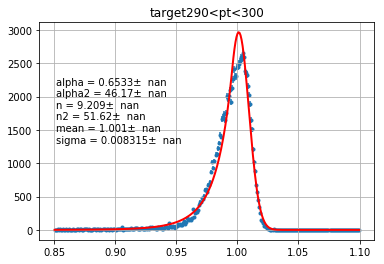

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.032316600044568, 1.4324478365913098, -13.221561334164594, 5.952214275596709, 0.9955744668734436, 0.013)


FCN = 4210.93827953 
 TOTAL NCALL = 337 
 NCALLS = 337 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.22478 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.45168 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.30071 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 10.1827 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.995737 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.22478 & nan & & & & & No\\
\hline
1 & alpha2 & 5.45168 & nan & & & & & No\\
\hline
2 & n & 3.30071 & nan & & & & & No\\
\hline
3 & n2 & 10.1827 & nan & & & & & No\\
\hline
4 & mean & 0.995737 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 3456.47908199 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 5.78430265942e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.22478 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 5.45168 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.30071 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 10.1827 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.995737 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0116646 
 3.17488e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.22478 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 5.45168 & 1 & & & & & Yes\\
\hline
2 & n & 3.30071 & 1 & & & & & Yes\\
\hline
3 & n2 & 10.1827 & 1 & & & & & Yes\\
\hline
4 & mean & 0.995737 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0116646 & 3.17488e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 3216.15333173 
 TOTAL NCALL = 57 
 NCALLS = 57 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.16961 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.58037 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 2.93857 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 12.614 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.996018 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.01167 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.16961 & nan & & & & & No\\
\hline
1 & alpha2 & 5.58037 & nan & & & & & No\\
\hline
2 & n & 2.93857 & nan & & & & & No\\
\hline
3 & n2 & 12.614 & nan & & & & & No\\
\hline
4 & mean & 0.996018 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.01167 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 3150.92047023 
 TOTAL NCALL = 69 
 NCALLS = 69 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.07008 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 7.05701 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.79593 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 46.4979 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.996018 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.01167 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.07008 & nan & & & & & No\\
\hline
1 & alpha2 & 7.05701 & nan & & & & & No\\
\hline
2 & n & 3.79593 & nan & & & & & No\\
\hline
3 & n2 & 46.4979 & nan & & & & & No\\
\hline
4 & mean & 0.996018 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.01167 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2803.82418494 
 TOTAL NCALL = 120 
 NCALLS = 109 
 
 
 EDM = 9587.07241779 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.06866 
 0.0698486 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 7.41073 
 2.73703 
 
 
 
 
 No 
 
 
 2 
 n 
 3.79433 
 0.569354 
 
 
 
 
 No 
 
 
 3 
 n2 
 46.4979 
 2.25504e+06 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.997036 
 0.000180765 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0109363 
 0.000119982 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.06866 & 0.0698486 & & & & & No\\
\hline
1 & alpha2 & 7.41073 & 2.73703 & & & & & No\\
\hline
2 & n & 3.79433 & 0.569354 & & & & & No\\
\hline
3 & n2 & 46.4979 & 2.25504e+06 & & & & & No\\
\hline
4 & mean & 0.997036 & 0.000180765 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0109363 & 0.000119982 & & & & & No\\
\hline
\end{tabular}

280<pt<290
2


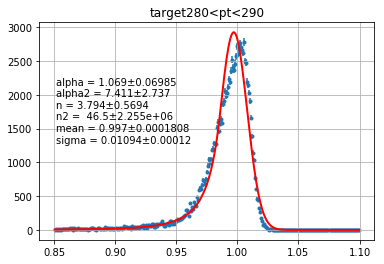

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -1.444665850808951, 4.0, 0.99, 0.013)


FCN = 3981.75856154 
 TOTAL NCALL = 564 
 NCALLS = 564 
 
 
 EDM = 5.07116617674e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.1902 
 0.0119114 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.25582 
 0.250931 
 
 
 
 
 No 
 
 
 2 
 n 
 2.76748 
 0.0659447 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.454906 
 0.611933 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.99571 
 4.99035e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.1902 & 0.0119114 & & & & & No\\
\hline
1 & alpha2 & 4.25582 & 0.250931 & & & & & No\\
\hline
2 & n & 2.76748 & 0.0659447 & & & & & No\\
\hline
3 & n2 & 0.454906 & 0.611933 & & & & & No\\
\hline
4 & mean & 0.99571 & 4.99035e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 3222.51042192 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 7.5201467497e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.1902 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 4.25582 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.76748 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 0.454906 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.99571 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0116397 
 3.21553e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.1902 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 4.25582 & 1 & & & & & Yes\\
\hline
2 & n & 2.76748 & 1 & & & & & Yes\\
\hline
3 & n2 & 0.454906 & 1 & & & & & Yes\\
\hline
4 & mean & 0.99571 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0116397 & 3.21553e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1454.4221206 
 TOTAL NCALL = 351 
 NCALLS = 351 
 
 
 EDM = 6.99059887212e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.512811 
 0.00789712 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.87598 
 0.18356 
 
 
 
 
 No 
 
 
 2 
 n 
 7.68896 
 0.285356 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.12526 
 0.499206 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00089 
 9.60859e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00819965 
 6.17875e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.512811 & 0.00789712 & & & & & No\\
\hline
1 & alpha2 & 3.87598 & 0.18356 & & & & & No\\
\hline
2 & n & 7.68896 & 0.285356 & & & & & No\\
\hline
3 & n2 & 1.12526 & 0.499206 & & & & & No\\
\hline
4 & mean & 1.00089 & 9.60859e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00819965 & 6.17875e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1454.42212035 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 1.6382522137e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.512811 
 0.00376951 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.87598 
 0.183458 
 
 
 
 
 No 
 
 
 2 
 n 
 7.68892 
 0.237519 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.12531 
 0.499343 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00089 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.00819965 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.512811 & 0.00376951 & & & & & No\\
\hline
1 & alpha2 & 3.87598 & 0.183458 & & & & & No\\
\hline
2 & n & 7.68892 & 0.237519 & & & & & No\\
\hline
3 & n2 & 1.12531 & 0.499343 & & & & & No\\
\hline
4 & mean & 1.00089 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.00819965 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1454.42212035 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 4.03371984254e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.512811 
 0.00498672 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.87598 
 0.183063 
 
 
 
 
 No 
 
 
 2 
 n 
 7.68892 
 0.263152 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.12531 
 0.498236 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00089 
 5.03127e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00819965 
 2.61604e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.512811 & 0.00498672 & & & & & No\\
\hline
1 & alpha2 & 3.87598 & 0.183063 & & & & & No\\
\hline
2 & n & 7.68892 & 0.263152 & & & & & No\\
\hline
3 & n2 & 1.12531 & 0.498236 & & & & & No\\
\hline
4 & mean & 1.00089 & 5.03127e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00819965 & 2.61604e-05 & & & & & No\\
\hline
\end{tabular}

270<pt<280
3


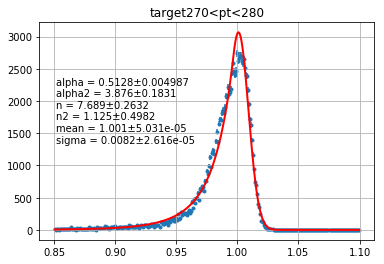

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, 0.26433616054453424, 4.0, 0.99, 0.013)


FCN = 3902.16175607 
 TOTAL NCALL = 328 
 NCALLS = 328 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.21515 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.38407 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 2.55828 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.9431 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.995402 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.21515 & nan & & & & & No\\
\hline
1 & alpha2 & 5.38407 & nan & & & & & No\\
\hline
2 & n & 2.55828 & nan & & & & & No\\
\hline
3 & n2 & 14.9431 & nan & & & & & No\\
\hline
4 & mean & 0.995402 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 3351.16705354 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 1.45954176536e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.21515 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 5.38407 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.55828 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 14.9431 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.995402 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0118265 
 3.29777e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.21515 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 5.38407 & 1 & & & & & Yes\\
\hline
2 & n & 2.55828 & 1 & & & & & Yes\\
\hline
3 & n2 & 14.9431 & 1 & & & & & Yes\\
\hline
4 & mean & 0.995402 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0118265 & 3.29777e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 2805.04144208 
 TOTAL NCALL = 73 
 NCALLS = 73 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.07336 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 6.23598 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 2.43554 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 33.0163 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.997477 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0108762 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.07336 & nan & & & & & No\\
\hline
1 & alpha2 & 6.23598 & nan & & & & & No\\
\hline
2 & n & 2.43554 & nan & & & & & No\\
\hline
3 & n2 & 33.0163 & nan & & & & & No\\
\hline
4 & mean & 0.997477 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0108762 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 2430.89049771 
 TOTAL NCALL = 95 
 NCALLS = 95 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.892424 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 6.54199 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.47349 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 66.9231 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.997477 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0108762 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.892424 & nan & & & & & No\\
\hline
1 & alpha2 & 6.54199 & nan & & & & & No\\
\hline
2 & n & 3.47349 & nan & & & & & No\\
\hline
3 & n2 & 66.9231 & nan & & & & & No\\
\hline
4 & mean & 0.997477 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0108762 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1781.83549265 
 TOTAL NCALL = 142 
 NCALLS = 142 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.587685 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 6.70958 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 5.01193 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 66.9231 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999961 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00865487 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.587685 & nan & & & & & No\\
\hline
1 & alpha2 & 6.70958 & nan & & & & & No\\
\hline
2 & n & 5.01193 & nan & & & & & No\\
\hline
3 & n2 & 66.9231 & nan & & & & & No\\
\hline
4 & mean & 0.999961 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00865487 & nan & & & & & No\\
\hline
\end{tabular}

260<pt<270
4


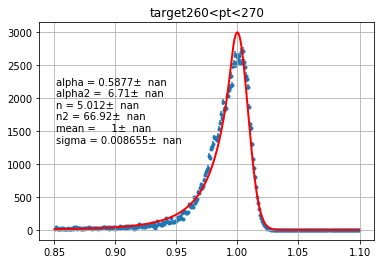

FCN = 3896.5580497 
 TOTAL NCALL = 315 
 NCALLS = 304 
 
 
 EDM = 0.602318491303 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.13197 
 8.75309 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.21369 
 8.73745 
 
 
 
 
 No 
 
 
 2 
 n 
 2.71605 
 8.7533 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.28153 
 0.707107 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.995226 
 0.126825 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.13197 & 8.75309 & & & & & No\\
\hline
1 & alpha2 & 4.21369 & 8.73745 & & & & & No\\
\hline
2 & n & 2.71605 & 8.7533 & & & & & No\\
\hline
3 & n2 & 4.28153 & 0.707107 & & & & & No\\
\hline
4 & mean & 0.995226 & 0.126825 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.131965830655353, 4.213689462107229, 2.716046711184858, 4.281529183466824, 0.9952261650359395, -0.030107561566965577)


FCN = 3325.92186084 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 2.02235166354e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.13197 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 4.21369 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.71605 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4.28153 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.995226 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.011798 
 3.31177e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.13197 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 4.21369 & 1 & & & & & Yes\\
\hline
2 & n & 2.71605 & 1 & & & & & Yes\\
\hline
3 & n2 & 4.28153 & 1 & & & & & Yes\\
\hline
4 & mean & 0.995226 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.011798 & 3.31177e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1672.92059944 
 TOTAL NCALL = 341 
 NCALLS = 341 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.504391 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 125.183 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 6.76504 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 -382.558 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00047 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00832389 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.504391 & nan & & & & & No\\
\hline
1 & alpha2 & 125.183 & nan & & & & & No\\
\hline
2 & n & 6.76504 & nan & & & & & No\\
\hline
3 & n2 & -382.558 & nan & & & & & No\\
\hline
4 & mean & 1.00047 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00832389 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 1672.87932289 
 TOTAL NCALL = 67 
 NCALLS = 67 
 
 
 EDM = 1.08287089051e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.504473 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 125.183 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 6.78886 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 -382.558 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00047 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.00832389 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.504473 & 0 & & & & & No\\
\hline
1 & alpha2 & 125.183 & 0 & & & & & No\\
\hline
2 & n & 6.78886 & 0 & & & & & No\\
\hline
3 & n2 & -382.558 & 0 & & & & & No\\
\hline
4 & mean & 1.00047 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.00832389 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1672.85887519 
 TOTAL NCALL = 84 
 NCALLS = 84 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.504665 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 125.183 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 6.79719 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 -382.558 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00047 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00832932 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.504665 & nan & & & & & No\\
\hline
1 & alpha2 & 125.183 & nan & & & & & No\\
\hline
2 & n & 6.79719 & nan & & & & & No\\
\hline
3 & n2 & -382.558 & nan & & & & & No\\
\hline
4 & mean & 1.00047 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00832932 & nan & & & & & No\\
\hline
\end{tabular}

250<pt<260
5


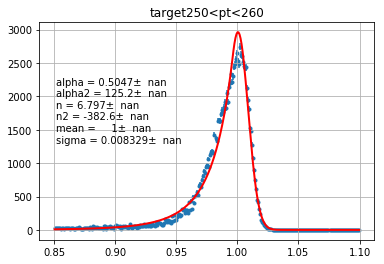

FCN = 3681.76085802 
 TOTAL NCALL = 293 
 NCALLS = 293 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.07418 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.24525 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.15023 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 15.4632 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.995003 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.07418 & nan & & & & & No\\
\hline
1 & alpha2 & 5.24525 & nan & & & & & No\\
\hline
2 & n & 3.15023 & nan & & & & & No\\
\hline
3 & n2 & 15.4632 & nan & & & & & No\\
\hline
4 & mean & 0.995003 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0741831826987784, 5.245245665562717, 3.150226558979607, 15.463240479868544, 0.9950033557327074, -0.028902727763082454)


FCN = 3238.91053231 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 4.67733078497e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.07418 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 5.24525 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.15023 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 15.4632 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.995003 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0119563 
 3.29625e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.07418 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 5.24525 & 1 & & & & & Yes\\
\hline
2 & n & 3.15023 & 1 & & & & & Yes\\
\hline
3 & n2 & 15.4632 & 1 & & & & & Yes\\
\hline
4 & mean & 0.995003 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0119563 & 3.29625e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 3073.03492542 
 TOTAL NCALL = 55 
 NCALLS = 55 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.03188 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.38306 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 2.87666 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 20.1232 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.995321 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0119625 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.03188 & nan & & & & & No\\
\hline
1 & alpha2 & 5.38306 & nan & & & & & No\\
\hline
2 & n & 2.87666 & nan & & & & & No\\
\hline
3 & n2 & 20.1232 & nan & & & & & No\\
\hline
4 & mean & 0.995321 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0119625 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 3030.30364372 
 TOTAL NCALL = 67 
 NCALLS = 67 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.969726 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 6.71154 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.46364 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 58.6678 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.995321 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0119625 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.969726 & nan & & & & & No\\
\hline
1 & alpha2 & 6.71154 & nan & & & & & No\\
\hline
2 & n & 3.46364 & nan & & & & & No\\
\hline
3 & n2 & 58.6678 & nan & & & & & No\\
\hline
4 & mean & 0.995321 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0119625 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2792.07160338 
 TOTAL NCALL = 120 
 NCALLS = 109 
 
 
 EDM = 8447.79736933 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.968243 
 0.0619211 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 7.09109 
 1.70846 
 
 
 
 
 No 
 
 
 2 
 n 
 3.46635 
 0.437369 
 
 
 
 
 No 
 
 
 3 
 n2 
 58.6678 
 1.22344e+06 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.996191 
 0.000228272 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0112752 
 0.00015033 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.968243 & 0.0619211 & & & & & No\\
\hline
1 & alpha2 & 7.09109 & 1.70846 & & & & & No\\
\hline
2 & n & 3.46635 & 0.437369 & & & & & No\\
\hline
3 & n2 & 58.6678 & 1.22344e+06 & & & & & No\\
\hline
4 & mean & 0.996191 & 0.000228272 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0112752 & 0.00015033 & & & & & No\\
\hline
\end{tabular}

240<pt<250
6


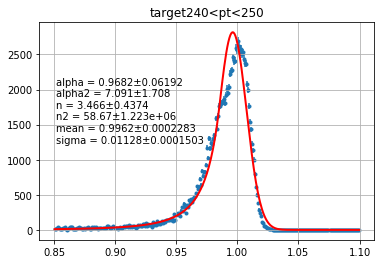

FCN = 3784.86427921 
 TOTAL NCALL = 321 
 NCALLS = 321 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.04534 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.25084 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.14221 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 15.5279 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.995024 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.04534 & nan & & & & & No\\
\hline
1 & alpha2 & 5.25084 & nan & & & & & No\\
\hline
2 & n & 3.14221 & nan & & & & & No\\
\hline
3 & n2 & 15.5279 & nan & & & & & No\\
\hline
4 & mean & 0.995024 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0453440199981898, 5.25083641128333, 3.142207072703832, 15.527873377229971, 0.9950236710268496, -0.029485316645728565)


FCN = 3288.42733372 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 9.83542979822e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.04534 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 5.25084 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.14221 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 15.5279 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.995024 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0118765 
 3.33416e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.04534 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 5.25084 & 1 & & & & & Yes\\
\hline
2 & n & 3.14221 & 1 & & & & & Yes\\
\hline
3 & n2 & 15.5279 & 1 & & & & & Yes\\
\hline
4 & mean & 0.995024 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0118765 & 3.33416e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 3092.6537758 
 TOTAL NCALL = 57 
 NCALLS = 57 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.00076 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.3911 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 2.8465 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 20.2415 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.995384 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0118829 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.00076 & nan & & & & & No\\
\hline
1 & alpha2 & 5.3911 & nan & & & & & No\\
\hline
2 & n & 2.8465 & nan & & & & & No\\
\hline
3 & n2 & 20.2415 & nan & & & & & No\\
\hline
4 & mean & 0.995384 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0118829 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 3043.09639511 
 TOTAL NCALL = 67 
 NCALLS = 67 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.937214 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 6.71349 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.4646 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 57.7684 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.995384 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0118829 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.937214 & nan & & & & & No\\
\hline
1 & alpha2 & 6.71349 & nan & & & & & No\\
\hline
2 & n & 3.4646 & nan & & & & & No\\
\hline
3 & n2 & 57.7684 & nan & & & & & No\\
\hline
4 & mean & 0.995384 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0118829 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2753.75067127 
 TOTAL NCALL = 120 
 NCALLS = 109 
 
 
 EDM = 8639.89463556 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.935546 
 0.0596917 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 7.09802 
 1.81666 
 
 
 
 
 No 
 
 
 2 
 n 
 3.46831 
 0.453972 
 
 
 
 
 No 
 
 
 3 
 n2 
 57.7684 
 1.22158e+06 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.996352 
 0.000210286 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0111053 
 0.000132168 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.935546 & 0.0596917 & & & & & No\\
\hline
1 & alpha2 & 7.09802 & 1.81666 & & & & & No\\
\hline
2 & n & 3.46831 & 0.453972 & & & & & No\\
\hline
3 & n2 & 57.7684 & 1.22158e+06 & & & & & No\\
\hline
4 & mean & 0.996352 & 0.000210286 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0111053 & 0.000132168 & & & & & No\\
\hline
\end{tabular}

230<pt<240
7


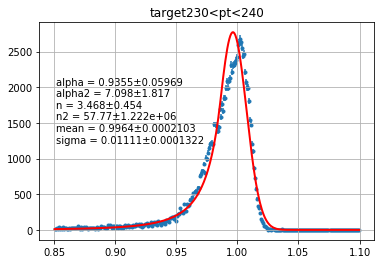

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -6.005084907781384, 4.0, 0.99, 0.013)


FCN = 3319.44134334 
 TOTAL NCALL = 318 
 NCALLS = 307 
 
 
 EDM = 0.0199246969295 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.96227 
 237.125 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.18468 
 237.037 
 
 
 
 
 No 
 
 
 2 
 n 
 3.65272 
 237.125 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.61257 
 1.47723 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994784 
 0.152603 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.96227 & 237.125 & & & & & No\\
\hline
1 & alpha2 & 4.18468 & 237.037 & & & & & No\\
\hline
2 & n & 3.65272 & 237.125 & & & & & No\\
\hline
3 & n2 & 7.61257 & 1.47723 & & & & & No\\
\hline
4 & mean & 0.994784 & 0.152603 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2943.91200874 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.1825416313e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.96227 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 4.18468 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.65272 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 7.61257 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.994784 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0120322 
 3.33292e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.96227 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 4.18468 & 1 & & & & & Yes\\
\hline
2 & n & 3.65272 & 1 & & & & & Yes\\
\hline
3 & n2 & 7.61257 & 1 & & & & & Yes\\
\hline
4 & mean & 0.994784 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0120322 & 3.33292e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1540.75664279 
 TOTAL NCALL = 465 
 NCALLS = 465 
 
 
 EDM = 1.67469723486e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.469821 
 0.00698054 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.41315 
 0.184502 
 
 
 
 
 No 
 
 
 2 
 n 
 9.16369 
 0.401701 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.31427 
 2.76794 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999856 
 0.000101971 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00869781 
 6.53435e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.469821 & 0.00698054 & & & & & No\\
\hline
1 & alpha2 & 3.41315 & 0.184502 & & & & & No\\
\hline
2 & n & 9.16369 & 0.401701 & & & & & No\\
\hline
3 & n2 & 5.31427 & 2.76794 & & & & & No\\
\hline
4 & mean & 0.999856 & 0.000101971 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00869781 & 6.53435e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1540.7566347 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 4.71564037751e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.469824 
 0.00343264 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.41324 
 0.183635 
 
 
 
 
 No 
 
 
 2 
 n 
 9.1641 
 0.344309 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.31356 
 2.76546 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999856 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.00869781 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.469824 & 0.00343264 & & & & & No\\
\hline
1 & alpha2 & 3.41324 & 0.183635 & & & & & No\\
\hline
2 & n & 9.1641 & 0.344309 & & & & & No\\
\hline
3 & n2 & 5.31356 & 2.76546 & & & & & No\\
\hline
4 & mean & 0.999856 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.00869781 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1540.7566347 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 7.37320537157e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.469824 
 0.00451956 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.41324 
 0.183727 
 
 
 
 
 No 
 
 
 2 
 n 
 9.1641 
 0.379784 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.31356 
 2.76577 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999856 
 5.42375e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00869781 
 2.80083e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.469824 & 0.00451956 & & & & & No\\
\hline
1 & alpha2 & 3.41324 & 0.183727 & & & & & No\\
\hline
2 & n & 9.1641 & 0.379784 & & & & & No\\
\hline
3 & n2 & 5.31356 & 2.76577 & & & & & No\\
\hline
4 & mean & 0.999856 & 5.42375e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00869781 & 2.80083e-05 & & & & & No\\
\hline
\end{tabular}

220<pt<230
8


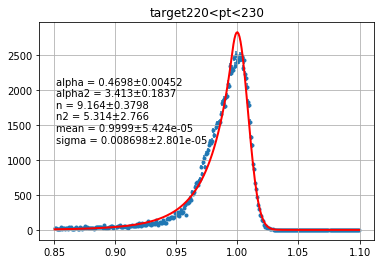

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -7.18272221762189, 4.0, 0.99, 0.013)


FCN = 3604.45329623 
 TOTAL NCALL = 311 
 NCALLS = 311 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.964428 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.33426 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.54785 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 15.8623 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994888 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.964428 & nan & & & & & No\\
\hline
1 & alpha2 & 5.33426 & nan & & & & & No\\
\hline
2 & n & 3.54785 & nan & & & & & No\\
\hline
3 & n2 & 15.8623 & nan & & & & & No\\
\hline
4 & mean & 0.994888 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 3175.47707575 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 4.75506604152e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.964428 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 5.33426 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.54785 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 15.8623 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.994888 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0119605 
 3.33327e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.964428 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 5.33426 & 1 & & & & & Yes\\
\hline
2 & n & 3.54785 & 1 & & & & & Yes\\
\hline
3 & n2 & 15.8623 & 1 & & & & & Yes\\
\hline
4 & mean & 0.994888 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0119605 & 3.33327e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 2574.39751885 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.846619 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 6.22328 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.12923 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 37.9295 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.997347 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0108248 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.846619 & nan & & & & & No\\
\hline
1 & alpha2 & 6.22328 & nan & & & & & No\\
\hline
2 & n & 3.12923 & nan & & & & & No\\
\hline
3 & n2 & 37.9295 & nan & & & & & No\\
\hline
4 & mean & 0.997347 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0108248 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 2220.50593586 
 TOTAL NCALL = 119 
 NCALLS = 119 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.70418 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 6.54637 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 4.79446 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 120.035 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.997347 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0108248 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.70418 & nan & & & & & No\\
\hline
1 & alpha2 & 6.54637 & nan & & & & & No\\
\hline
2 & n & 4.79446 & nan & & & & & No\\
\hline
3 & n2 & 120.035 & nan & & & & & No\\
\hline
4 & mean & 0.997347 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0108248 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1998.9444066 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.665923 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 8.68152 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 4.48219 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 120.36 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.997503 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0100067 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.665923 & nan & & & & & No\\
\hline
1 & alpha2 & 8.68152 & nan & & & & & No\\
\hline
2 & n & 4.48219 & nan & & & & & No\\
\hline
3 & n2 & 120.36 & nan & & & & & No\\
\hline
4 & mean & 0.997503 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0100067 & nan & & & & & No\\
\hline
\end{tabular}

210<pt<220
9


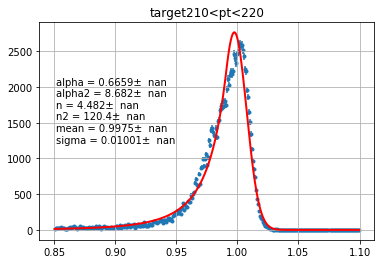

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -4.864368065261294, 4.0, 0.99, 0.013)


FCN = 3239.42321286 
 TOTAL NCALL = 407 
 NCALLS = 407 
 
 
 EDM = 1.48530200055e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.925835 
 0.00935671 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.54493 
 0.244664 
 
 
 
 
 No 
 
 
 2 
 n 
 3.48926 
 0.0871992 
 
 
 
 
 No 
 
 
 3 
 n2 
 21.9145 
 53.3177 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994534 
 5.56395e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.925835 & 0.00935671 & & & & & No\\
\hline
1 & alpha2 & 3.54493 & 0.244664 & & & & & No\\
\hline
2 & n & 3.48926 & 0.0871992 & & & & & No\\
\hline
3 & n2 & 21.9145 & 53.3177 & & & & & No\\
\hline
4 & mean & 0.994534 & 5.56395e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2869.59104756 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.10411159059e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.925835 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 3.54493 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.48926 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 21.9145 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.994534 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0120209 
 3.39464e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.925835 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 3.54493 & 1 & & & & & Yes\\
\hline
2 & n & 3.48926 & 1 & & & & & Yes\\
\hline
3 & n2 & 21.9145 & 1 & & & & & Yes\\
\hline
4 & mean & 0.994534 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0120209 & 3.39464e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 2347.77369009 
 TOTAL NCALL = 150 
 NCALLS = 139 
 
 
 EDM = 3044.49461517 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.824517 
 0.0246829 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.64118 
 0.420523 
 
 
 
 
 No 
 
 
 2 
 n 
 3.09356 
 0.120093 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.90928 
 8.46157 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.996878 
 0.000170739 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0109199 
 0.000131634 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.824517 & 0.0246829 & & & & & No\\
\hline
1 & alpha2 & 3.64118 & 0.420523 & & & & & No\\
\hline
2 & n & 3.09356 & 0.120093 & & & & & No\\
\hline
3 & n2 & 3.90928 & 8.46157 & & & & & No\\
\hline
4 & mean & 0.996878 & 0.000170739 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0109199 & 0.000131634 & & & & & No\\
\hline
\end{tabular}

FCN = 2037.29041334 
 TOTAL NCALL = 227 
 NCALLS = 227 
 
 
 EDM = 1.39755784923e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.668892 
 0.00551937 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.662 
 0.151163 
 
 
 
 
 No 
 
 
 2 
 n 
 5.114 
 0.135377 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.61413 
 1.19632 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.996878 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0109199 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.668892 & 0.00551937 & & & & & No\\
\hline
1 & alpha2 & 3.662 & 0.151163 & & & & & No\\
\hline
2 & n & 5.114 & 0.135377 & & & & & No\\
\hline
3 & n2 & 2.61413 & 1.19632 & & & & & No\\
\hline
4 & mean & 0.996878 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0109199 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1541.90042712 
 TOTAL NCALL = 359 
 NCALLS = 359 
 
 
 EDM = 4.47178539728e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.464541 
 0.00693761 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.43298 
 0.152839 
 
 
 
 
 No 
 
 
 2 
 n 
 7.83265 
 0.306856 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.54666 
 0.829678 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.999561 
 0.000102852 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00873494 
 6.59902e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.464541 & 0.00693761 & & & & & No\\
\hline
1 & alpha2 & 3.43298 & 0.152839 & & & & & No\\
\hline
2 & n & 7.83265 & 0.306856 & & & & & No\\
\hline
3 & n2 & 2.54666 & 0.829678 & & & & & No\\
\hline
4 & mean & 0.999561 & 0.000102852 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00873494 & 6.59902e-05 & & & & & No\\
\hline
\end{tabular}

200<pt<210
10


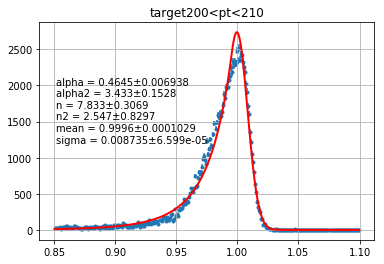

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -4.8576099515554425, 4.0, 0.99, 0.013)


FCN = 2923.0685961 
 TOTAL NCALL = 310 
 NCALLS = 310 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.836881 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.26896 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 4.50193 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 16.2862 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994569 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.836881 & nan & & & & & No\\
\hline
1 & alpha2 & 5.26896 & nan & & & & & No\\
\hline
2 & n & 4.50193 & nan & & & & & No\\
\hline
3 & n2 & 16.2862 & nan & & & & & No\\
\hline
4 & mean & 0.994569 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2545.60345863 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.04505752802e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.836881 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 5.26896 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.50193 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 16.2862 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.994569 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0120255 
 3.34424e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.836881 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 5.26896 & 1 & & & & & Yes\\
\hline
2 & n & 4.50193 & 1 & & & & & Yes\\
\hline
3 & n2 & 16.2862 & 1 & & & & & Yes\\
\hline
4 & mean & 0.994569 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0120255 & 3.34424e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 2384.11247738 
 TOTAL NCALL = 57 
 NCALLS = 57 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.80826 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.39208 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.99365 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 20.7077 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994862 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0120299 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.80826 & nan & & & & & No\\
\hline
1 & alpha2 & 5.39208 & nan & & & & & No\\
\hline
2 & n & 3.99365 & nan & & & & & No\\
\hline
3 & n2 & 20.7077 & nan & & & & & No\\
\hline
4 & mean & 0.994862 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0120299 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 2364.10362161 
 TOTAL NCALL = 51 
 NCALLS = 51 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.776115 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 6.90711 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 4.57113 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 56.8635 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994862 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0120299 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.776115 & nan & & & & & No\\
\hline
1 & alpha2 & 6.90711 & nan & & & & & No\\
\hline
2 & n & 4.57113 & nan & & & & & No\\
\hline
3 & n2 & 56.8635 & nan & & & & & No\\
\hline
4 & mean & 0.994862 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0120299 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2364.10362161 
 TOTAL NCALL = 119 
 NCALLS = 119 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.776115 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 6.90711 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 4.57113 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 192.857 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994862 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0120299 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.776115 & nan & & & & & No\\
\hline
1 & alpha2 & 6.90711 & nan & & & & & No\\
\hline
2 & n & 4.57113 & nan & & & & & No\\
\hline
3 & n2 & 192.857 & nan & & & & & No\\
\hline
4 & mean & 0.994862 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0120299 & nan & & & & & No\\
\hline
\end{tabular}

190<pt<200
11


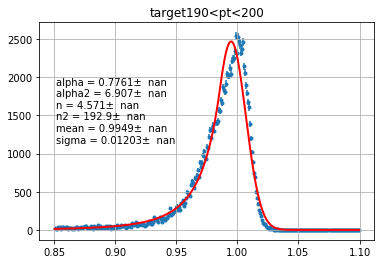

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -3.6564245892867433, 4.0, 0.99, 0.013)


FCN = 2776.34508364 
 TOTAL NCALL = 378 
 NCALLS = 367 
 
 
 EDM = 85.9918266483 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.790207 
 0.00635114 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.39306 
 1.89499 
 
 
 
 
 No 
 
 
 2 
 n 
 4.80799 
 0.120229 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.286337 
 4.10556 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994299 
 5.4322e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.790207 & 0.00635114 & & & & & No\\
\hline
1 & alpha2 & 4.39306 & 1.89499 & & & & & No\\
\hline
2 & n & 4.80799 & 0.120229 & & & & & No\\
\hline
3 & n2 & 0.286337 & 4.10556 & & & & & No\\
\hline
4 & mean & 0.994299 & 5.4322e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2491.0307025 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.37517727446e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.790207 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 4.39306 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.80799 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 0.286337 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.994299 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0121467 
 3.39349e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.790207 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 4.39306 & 1 & & & & & Yes\\
\hline
2 & n & 4.80799 & 1 & & & & & Yes\\
\hline
3 & n2 & 0.286337 & 1 & & & & & Yes\\
\hline
4 & mean & 0.994299 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0121467 & 3.39349e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1816.60412531 
 TOTAL NCALL = 156 
 NCALLS = 145 
 
 
 EDM = 21019.5594485 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.640243 
 0.00137404 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.83575 
 1.30129 
 
 
 
 
 No 
 
 
 2 
 n 
 3.93875 
 0.0203581 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.0580511 
 14.3298 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.997351 
 2.25599e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.010005 
 1.50698e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.640243 & 0.00137404 & & & & & No\\
\hline
1 & alpha2 & 4.83575 & 1.30129 & & & & & No\\
\hline
2 & n & 3.93875 & 0.0203581 & & & & & No\\
\hline
3 & n2 & 0.0580511 & 14.3298 & & & & & No\\
\hline
4 & mean & 0.997351 & 2.25599e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.010005 & 1.50698e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1815.62850225 
 TOTAL NCALL = 126 
 NCALLS = 126 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.640243 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.83575 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.93875 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.00176449 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.997351 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.010005 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.640243 & nan & & & & & No\\
\hline
1 & alpha2 & 4.83575 & nan & & & & & No\\
\hline
2 & n & 3.93875 & nan & & & & & No\\
\hline
3 & n2 & 0.00176449 & nan & & & & & No\\
\hline
4 & mean & 0.997351 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.010005 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1815.62850225 
 TOTAL NCALL = 94 
 NCALLS = 94 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.640243 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.83575 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 3.93875 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.00176449 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.997351 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.010005 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.640243 & nan & & & & & No\\
\hline
1 & alpha2 & 4.83575 & nan & & & & & No\\
\hline
2 & n & 3.93875 & nan & & & & & No\\
\hline
3 & n2 & 0.00176449 & nan & & & & & No\\
\hline
4 & mean & 0.997351 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.010005 & nan & & & & & No\\
\hline
\end{tabular}

180<pt<190
12


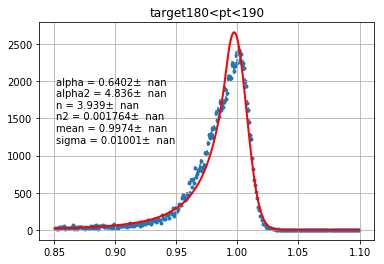

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -3.0121674600116766, 4.0, 0.99, 0.013)


FCN = 2299.61459686 
 TOTAL NCALL = 302 
 NCALLS = 291 
 
 
 EDM = 0.23563864481 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.721521 
 13.4455 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.41875 
 13.4386 
 
 
 
 
 No 
 
 
 2 
 n 
 6.07774 
 13.4472 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.70486 
 0.707107 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994287 
 0.13741 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.721521 & 13.4455 & & & & & No\\
\hline
1 & alpha2 & 3.41875 & 13.4386 & & & & & No\\
\hline
2 & n & 6.07774 & 13.4472 & & & & & No\\
\hline
3 & n2 & 6.70486 & 0.707107 & & & & & No\\
\hline
4 & mean & 0.994287 & 0.13741 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2045.82178672 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 8.57773731949e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.721521 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 3.41875 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 6.07774 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 6.70486 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.994287 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0121983 
 3.39448e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.721521 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 3.41875 & 1 & & & & & Yes\\
\hline
2 & n & 6.07774 & 1 & & & & & Yes\\
\hline
3 & n2 & 6.70486 & 1 & & & & & Yes\\
\hline
4 & mean & 0.994287 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0121983 & 3.39448e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1015.0323475 
 TOTAL NCALL = 368 
 NCALLS = 368 
 
 
 EDM = 9.62108172052e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.405422 
 0.00603312 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.7555 
 0.0897695 
 
 
 
 
 No 
 
 
 2 
 n 
 15.9582 
 1.26168 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.32856 
 0.836683 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.998973 
 0.000109478 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0090925 
 7.29297e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.405422 & 0.00603312 & & & & & No\\
\hline
1 & alpha2 & 2.7555 & 0.0897695 & & & & & No\\
\hline
2 & n & 15.9582 & 1.26168 & & & & & No\\
\hline
3 & n2 & 4.32856 & 0.836683 & & & & & No\\
\hline
4 & mean & 0.998973 & 0.000109478 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0090925 & 7.29297e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1015.03234488 
 TOTAL NCALL = 56 
 NCALLS = 56 
 
 
 EDM = 5.33488826204e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.405423 
 0.00304649 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.75553 
 0.0852978 
 
 
 
 
 No 
 
 
 2 
 n 
 15.9589 
 1.11348 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.32828 
 0.828931 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.998973 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0090925 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.405423 & 0.00304649 & & & & & No\\
\hline
1 & alpha2 & 2.75553 & 0.0852978 & & & & & No\\
\hline
2 & n & 15.9589 & 1.11348 & & & & & No\\
\hline
3 & n2 & 4.32828 & 0.828931 & & & & & No\\
\hline
4 & mean & 0.998973 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0090925 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1015.03234488 
 TOTAL NCALL = 88 
 NCALLS = 88 
 
 
 EDM = 7.07034151944e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.405423 
 0.0054026 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.75553 
 0.0879513 
 
 
 
 
 No 
 
 
 2 
 n 
 15.9589 
 1.25383 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.32828 
 0.833494 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.998973 
 9.38604e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0090925 
 6.07572e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.405423 & 0.0054026 & & & & & No\\
\hline
1 & alpha2 & 2.75553 & 0.0879513 & & & & & No\\
\hline
2 & n & 15.9589 & 1.25383 & & & & & No\\
\hline
3 & n2 & 4.32828 & 0.833494 & & & & & No\\
\hline
4 & mean & 0.998973 & 9.38604e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0090925 & 6.07572e-05 & & & & & No\\
\hline
\end{tabular}

170<pt<180
13


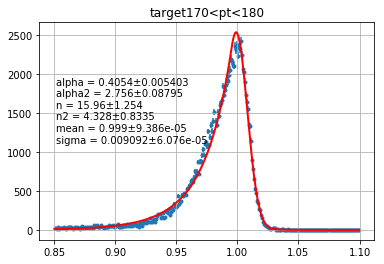

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -2.3204675339355862, 4.0, 0.99, 0.013)


FCN = 2280.93040242 
 TOTAL NCALL = 412 
 NCALLS = 401 
 
 
 EDM = 2.80357104479 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.690709 
 0.00720959 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.99742 
 0.532475 
 
 
 
 
 No 
 
 
 2 
 n 
 6.48358 
 0.274625 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.31742 
 2.84298 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994001 
 5.97518e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.690709 & 0.00720959 & & & & & No\\
\hline
1 & alpha2 & 3.99742 & 0.532475 & & & & & No\\
\hline
2 & n & 6.48358 & 0.274625 & & & & & No\\
\hline
3 & n2 & 1.31742 & 2.84298 & & & & & No\\
\hline
4 & mean & 0.994001 & 5.97518e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2055.56345968 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 7.63365173931e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.690709 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 3.99742 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 6.48358 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.31742 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.994001 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0122501 
 3.37522e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.690709 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 3.99742 & 1 & & & & & Yes\\
\hline
2 & n & 6.48358 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.31742 & 1 & & & & & Yes\\
\hline
4 & mean & 0.994001 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0122501 & 3.37522e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 2055.56345968 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 348.890759346 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.690709 
 0.0397673 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.99742 
 0.331379 
 
 
 
 
 No 
 
 
 2 
 n 
 6.48358 
 1.70773 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.31742 
 1.97371 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994001 
 0.000118129 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0122501 
 4.93724e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.690709 & 0.0397673 & & & & & No\\
\hline
1 & alpha2 & 3.99742 & 0.331379 & & & & & No\\
\hline
2 & n & 6.48358 & 1.70773 & & & & & No\\
\hline
3 & n2 & 1.31742 & 1.97371 & & & & & No\\
\hline
4 & mean & 0.994001 & 0.000118129 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0122501 & 4.93724e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 2029.4318374 
 TOTAL NCALL = 80 
 NCALLS = 69 
 
 
 EDM = 57.4059332555 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.721155 
 0.0138081 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.01884 
 0.357577 
 
 
 
 
 No 
 
 
 2 
 n 
 5.05612 
 0.542729 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.16089 
 2.12772 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994001 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0122501 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.721155 & 0.0138081 & & & & & No\\
\hline
1 & alpha2 & 4.01884 & 0.357577 & & & & & No\\
\hline
2 & n & 5.05612 & 0.542729 & & & & & No\\
\hline
3 & n2 & 1.16089 & 2.12772 & & & & & No\\
\hline
4 & mean & 0.994001 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0122501 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1178.56057778 
 TOTAL NCALL = 355 
 NCALLS = 355 
 
 
 EDM = 2.02137874837e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.427269 
 0.00590923 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.59071 
 0.178597 
 
 
 
 
 No 
 
 
 2 
 n 
 13.4654 
 0.923461 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.51521 
 0.602037 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.998094 
 0.000103224 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00959606 
 6.61279e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.427269 & 0.00590923 & & & & & No\\
\hline
1 & alpha2 & 3.59071 & 0.178597 & & & & & No\\
\hline
2 & n & 13.4654 & 0.923461 & & & & & No\\
\hline
3 & n2 & 1.51521 & 0.602037 & & & & & No\\
\hline
4 & mean & 0.998094 & 0.000103224 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00959606 & 6.61279e-05 & & & & & No\\
\hline
\end{tabular}

160<pt<170
14


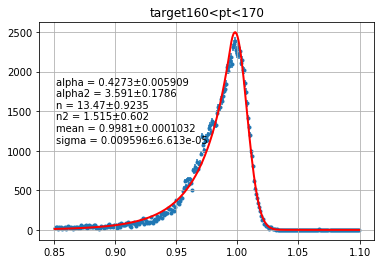

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -1.8146482319357187, 4.0, 0.99, 0.013)


FCN = 2097.3393519 
 TOTAL NCALL = 335 
 NCALLS = 324 
 
 
 EDM = 18.9341042994 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.633762 
 0.00498523 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 4.54905 
 1.41869 
 
 
 
 
 No 
 
 
 2 
 n 
 7.80588 
 0.274543 
 
 
 
 
 No 
 
 
 3 
 n2 
 15.8387 
 0.417157 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.993989 
 5.94994e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.633762 & 0.00498523 & & & & & No\\
\hline
1 & alpha2 & 4.54905 & 1.41869 & & & & & No\\
\hline
2 & n & 7.80588 & 0.274543 & & & & & No\\
\hline
3 & n2 & 15.8387 & 0.417157 & & & & & No\\
\hline
4 & mean & 0.993989 & 5.94994e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1882.83127001 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 6.19606967705e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.633762 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 4.54905 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 7.80588 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 15.8387 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.993989 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0122646 
 3.39558e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.633762 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 4.54905 & 1 & & & & & Yes\\
\hline
2 & n & 7.80588 & 1 & & & & & Yes\\
\hline
3 & n2 & 15.8387 & 1 & & & & & Yes\\
\hline
4 & mean & 0.993989 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0122646 & 3.39558e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 959.360574269 
 TOTAL NCALL = 554 
 NCALLS = 554 
 
 
 EDM = 2.1311594766e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.373003 
 0.005453 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.89884 
 0.101413 
 
 
 
 
 No 
 
 
 2 
 n 
 25.6156 
 3.3682 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.31062 
 0.976736 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.998536 
 0.000111977 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00928724 
 7.2536e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.373003 & 0.005453 & & & & & No\\
\hline
1 & alpha2 & 2.89884 & 0.101413 & & & & & No\\
\hline
2 & n & 25.6156 & 3.3682 & & & & & No\\
\hline
3 & n2 & 4.31062 & 0.976736 & & & & & No\\
\hline
4 & mean & 0.998536 & 0.000111977 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00928724 & 7.2536e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 959.36057342 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 5.20592901207e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.373004 
 0.00285166 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.89881 
 0.0983442 
 
 
 
 
 No 
 
 
 2 
 n 
 25.6163 
 2.99944 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.31031 
 0.973024 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.998536 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.00928724 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.373004 & 0.00285166 & & & & & No\\
\hline
1 & alpha2 & 2.89881 & 0.0983442 & & & & & No\\
\hline
2 & n & 25.6163 & 2.99944 & & & & & No\\
\hline
3 & n2 & 4.31031 & 0.973024 & & & & & No\\
\hline
4 & mean & 0.998536 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.00928724 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 959.360573405 
 TOTAL NCALL = 105 
 NCALLS = 105 
 
 
 EDM = 1.26476629087e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.373004 
 0.00545131 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.89881 
 0.101392 
 
 
 
 
 No 
 
 
 2 
 n 
 25.6163 
 3.36876 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.31031 
 0.976363 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.998536 
 0.000111915 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00928724 
 7.24942e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.373004 & 0.00545131 & & & & & No\\
\hline
1 & alpha2 & 2.89881 & 0.101392 & & & & & No\\
\hline
2 & n & 25.6163 & 3.36876 & & & & & No\\
\hline
3 & n2 & 4.31031 & 0.976363 & & & & & No\\
\hline
4 & mean & 0.998536 & 0.000111915 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00928724 & 7.24942e-05 & & & & & No\\
\hline
\end{tabular}

150<pt<160
15


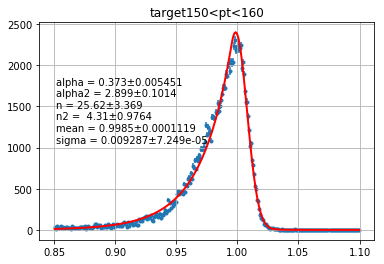

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -1.2653706771444195, 4.0, 0.99, 0.013)


FCN = 1635.31165034 
 TOTAL NCALL = 699 
 NCALLS = 688 
 
 
 EDM = 8.28069860722 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.56245 
 0.00590945 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.25415 
 0.239783 
 
 
 
 
 No 
 
 
 2 
 n 
 13.7338 
 1.20948 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.58685 
 3.93688 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.993865 
 6.4317e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.56245 & 0.00590945 & & & & & No\\
\hline
1 & alpha2 & 3.25415 & 0.239783 & & & & & No\\
\hline
2 & n & 13.7338 & 1.20948 & & & & & No\\
\hline
3 & n2 & 4.58685 & 3.93688 & & & & & No\\
\hline
4 & mean & 0.993865 & 6.4317e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1522.62051324 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.07621566407e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.56245 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 3.25415 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 13.7338 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4.58685 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.993865 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0124693 
 3.42225e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.56245 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 3.25415 & 1 & & & & & Yes\\
\hline
2 & n & 13.7338 & 1 & & & & & Yes\\
\hline
3 & n2 & 4.58685 & 1 & & & & & Yes\\
\hline
4 & mean & 0.993865 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0124693 & 3.42225e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1511.62368934 
 TOTAL NCALL = 108 
 NCALLS = 97 
 
 
 EDM = 2999.33578717 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.566315 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.2628 
 0.156542 
 
 
 
 
 No 
 
 
 2 
 n 
 12.3882 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.3013 
 3.64577 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.993872 
 5.3794e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0124523 
 3.62289e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.566315 & nan & & & & & No\\
\hline
1 & alpha2 & 3.2628 & 0.156542 & & & & & No\\
\hline
2 & n & 12.3882 & nan & & & & & No\\
\hline
3 & n2 & 4.3013 & 3.64577 & & & & & No\\
\hline
4 & mean & 0.993872 & 5.3794e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0124523 & 3.62289e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1502.41548632 
 TOTAL NCALL = 76 
 NCALLS = 65 
 
 
 EDM = 55.9219490946 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.579186 
 0.00962677 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.30393 
 0.198297 
 
 
 
 
 No 
 
 
 2 
 n 
 9.41743 
 1.76128 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.41721 
 3.60941 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.993872 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0124523 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.579186 & 0.00962677 & & & & & No\\
\hline
1 & alpha2 & 3.30393 & 0.198297 & & & & & No\\
\hline
2 & n & 9.41743 & 1.76128 & & & & & No\\
\hline
3 & n2 & 3.41721 & 3.60941 & & & & & No\\
\hline
4 & mean & 0.993872 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0124523 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1022.13561525 
 TOTAL NCALL = 451 
 NCALLS = 451 
 
 
 EDM = 1.07008120272e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.379295 
 0.0055479 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.85925 
 0.10393 
 
 
 
 
 No 
 
 
 2 
 n 
 109.547 
 61.6027 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.71026 
 0.788474 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.997354 
 0.000120717 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.010155 
 7.97862e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.379295 & 0.0055479 & & & & & No\\
\hline
1 & alpha2 & 2.85925 & 0.10393 & & & & & No\\
\hline
2 & n & 109.547 & 61.6027 & & & & & No\\
\hline
3 & n2 & 3.71026 & 0.788474 & & & & & No\\
\hline
4 & mean & 0.997354 & 0.000120717 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.010155 & 7.97862e-05 & & & & & No\\
\hline
\end{tabular}

140<pt<150
16


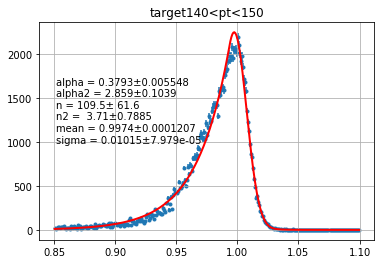

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -0.7439740067182878, 4.0, 0.99, 0.013)


FCN = 1487.13397829 
 TOTAL NCALL = 303 
 NCALLS = 303 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.535453 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.3526 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 12.8629 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 21.8047 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.993682 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.535453 & nan & & & & & No\\
\hline
1 & alpha2 & 5.3526 & nan & & & & & No\\
\hline
2 & n & 12.8629 & nan & & & & & No\\
\hline
3 & n2 & 21.8047 & nan & & & & & No\\
\hline
4 & mean & 0.993682 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1401.50154336 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 2.12935986956e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.535453 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 5.3526 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 12.8629 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 21.8047 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.993682 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0125339 
 3.46071e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.535453 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 5.3526 & 1 & & & & & Yes\\
\hline
2 & n & 12.8629 & 1 & & & & & Yes\\
\hline
3 & n2 & 21.8047 & 1 & & & & & Yes\\
\hline
4 & mean & 0.993682 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0125339 & 3.46071e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1309.10593614 
 TOTAL NCALL = 76 
 NCALLS = 76 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.52128 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 5.68316 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 8.9275 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 36.3096 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994291 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0122977 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.52128 & nan & & & & & No\\
\hline
1 & alpha2 & 5.68316 & nan & & & & & No\\
\hline
2 & n & 8.9275 & nan & & & & & No\\
\hline
3 & n2 & 36.3096 & nan & & & & & No\\
\hline
4 & mean & 0.994291 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0122977 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 1276.77387935 
 TOTAL NCALL = 74 
 NCALLS = 74 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.499368 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 12.0258 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 14.0063 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 36.3096 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.994291 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0122977 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.499368 & nan & & & & & No\\
\hline
1 & alpha2 & 12.0258 & nan & & & & & No\\
\hline
2 & n & 14.0063 & nan & & & & & No\\
\hline
3 & n2 & 36.3096 & nan & & & & & No\\
\hline
4 & mean & 0.994291 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0122977 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1163.21977692 
 TOTAL NCALL = 72 
 NCALLS = 72 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.480938 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 12.0258 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 10.3151 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 36.3096 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.995065 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0115375 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.480938 & nan & & & & & No\\
\hline
1 & alpha2 & 12.0258 & nan & & & & & No\\
\hline
2 & n & 10.3151 & nan & & & & & No\\
\hline
3 & n2 & 36.3096 & nan & & & & & No\\
\hline
4 & mean & 0.995065 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0115375 & nan & & & & & No\\
\hline
\end{tabular}

130<pt<140
17


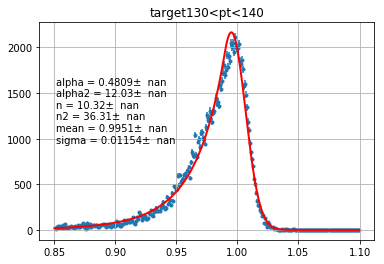

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -0.4196152018630688, 4.0, 0.99, 0.013)


FCN = 1321.20537014 
 TOTAL NCALL = 262 
 NCALLS = 262 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.496743 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 7.36796 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 15.4241 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 26.2724 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.993391 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.496743 & nan & & & & & No\\
\hline
1 & alpha2 & 7.36796 & nan & & & & & No\\
\hline
2 & n & 15.4241 & nan & & & & & No\\
\hline
3 & n2 & 26.2724 & nan & & & & & No\\
\hline
4 & mean & 0.993391 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1271.90721386 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 1.97721006173e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.496743 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 7.36796 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 15.4241 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 26.2724 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.993391 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0126446 
 3.50188e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.496743 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 7.36796 & 1 & & & & & Yes\\
\hline
2 & n & 15.4241 & 1 & & & & & Yes\\
\hline
3 & n2 & 26.2724 & 1 & & & & & Yes\\
\hline
4 & mean & 0.993391 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0126446 & 3.50188e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 901.077459299 
 TOTAL NCALL = 512 
 NCALLS = 501 
 
 
 EDM = 0.0508300435329 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.352021 
 0.00485934 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.05873 
 0.0600595 
 
 
 
 
 No 
 
 
 2 
 n 
 116.79 
 30.5224 
 
 
 
 
 No 
 
 
 3 
 n2 
 31.3018 
 7.56608 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.996655 
 0.000127666 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0103505 
 9.4118e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.352021 & 0.00485934 & & & & & No\\
\hline
1 & alpha2 & 2.05873 & 0.0600595 & & & & & No\\
\hline
2 & n & 116.79 & 30.5224 & & & & & No\\
\hline
3 & n2 & 31.3018 & 7.56608 & & & & & No\\
\hline
4 & mean & 0.996655 & 0.000127666 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0103505 & 9.4118e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 901.077459299 
 TOTAL NCALL = 66 
 NCALLS = 55 
 
 
 EDM = 300.234474132 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.352021 
 0.0012567 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.05873 
 0.479024 
 
 
 
 
 No 
 
 
 2 
 n 
 116.79 
 23.5798 
 
 
 
 
 No 
 
 
 3 
 n2 
 31.3018 
 220.322 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.996655 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0103505 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.352021 & 0.0012567 & & & & & No\\
\hline
1 & alpha2 & 2.05873 & 0.479024 & & & & & No\\
\hline
2 & n & 116.79 & 23.5798 & & & & & No\\
\hline
3 & n2 & 31.3018 & 220.322 & & & & & No\\
\hline
4 & mean & 0.996655 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0103505 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 901.077459299 
 TOTAL NCALL = 97 
 NCALLS = 86 
 
 
 EDM = 263.071864818 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.352021 
 0.00156316 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.05873 
 0.44861 
 
 
 
 
 No 
 
 
 2 
 n 
 116.79 
 23.8395 
 
 
 
 
 No 
 
 
 3 
 n2 
 31.3018 
 206.717 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.996655 
 6.25656e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0103505 
 3.70779e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.352021 & 0.00156316 & & & & & No\\
\hline
1 & alpha2 & 2.05873 & 0.44861 & & & & & No\\
\hline
2 & n & 116.79 & 23.8395 & & & & & No\\
\hline
3 & n2 & 31.3018 & 206.717 & & & & & No\\
\hline
4 & mean & 0.996655 & 6.25656e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0103505 & 3.70779e-05 & & & & & No\\
\hline
\end{tabular}

120<pt<130
18


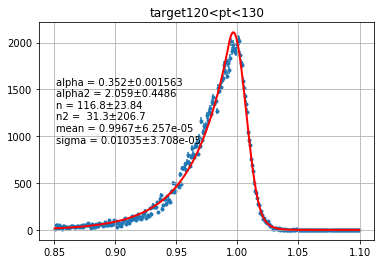

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -1.2448424171502932, 4.0, 0.99, 0.013)


FCN = 1181.6338675 
 TOTAL NCALL = 495 
 NCALLS = 484 
 
 
 EDM = 0.637414478566 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.433764 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 10.8231 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 111.329 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 32.8554 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.993137 
 0 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.433764 & 0 & & & & & No\\
\hline
1 & alpha2 & 10.8231 & 0 & & & & & No\\
\hline
2 & n & 111.329 & 0 & & & & & No\\
\hline
3 & n2 & 32.8554 & 0 & & & & & No\\
\hline
4 & mean & 0.993137 & 0 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1168.67823717 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 1.82819876297e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.433764 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 10.8231 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 111.329 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 32.8554 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.993137 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0128213 
 3.47229e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.433764 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 10.8231 & 1 & & & & & Yes\\
\hline
2 & n & 111.329 & 1 & & & & & Yes\\
\hline
3 & n2 & 32.8554 & 1 & & & & & Yes\\
\hline
4 & mean & 0.993137 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0128213 & 3.47229e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1152.27173456 
 TOTAL NCALL = 79 
 NCALLS = 79 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.426625 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 10.8231 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 117.177 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 32.8554 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.99343 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0127956 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.426625 & nan & & & & & No\\
\hline
1 & alpha2 & 10.8231 & nan & & & & & No\\
\hline
2 & n & 117.177 & nan & & & & & No\\
\hline
3 & n2 & 32.8554 & nan & & & & & No\\
\hline
4 & mean & 0.99343 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0127956 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 1152.27173456 
 TOTAL NCALL = 70 
 NCALLS = 59 
 
 
 EDM = 1.04746207743 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.426625 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 10.8231 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 117.177 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 32.8554 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.99343 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0127956 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.426625 & 0 & & & & & No\\
\hline
1 & alpha2 & 10.8231 & 0 & & & & & No\\
\hline
2 & n & 117.177 & 0 & & & & & No\\
\hline
3 & n2 & 32.8554 & 0 & & & & & No\\
\hline
4 & mean & 0.99343 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0127956 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1152.27173456 
 TOTAL NCALL = 82 
 NCALLS = 71 
 
 
 EDM = 7.69253018816 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.426625 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 10.8231 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 117.177 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 32.8554 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.99343 
 0 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0127956 
 0 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.426625 & 0 & & & & & No\\
\hline
1 & alpha2 & 10.8231 & 0 & & & & & No\\
\hline
2 & n & 117.177 & 0 & & & & & No\\
\hline
3 & n2 & 32.8554 & 0 & & & & & No\\
\hline
4 & mean & 0.99343 & 0 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0127956 & 0 & & & & & No\\
\hline
\end{tabular}

110<pt<120
19


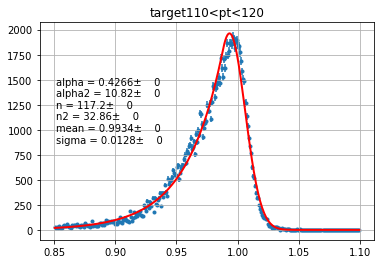

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -1.8493313150794766, 4.0, 0.99, 0.013)


FCN = 1038.32898549 
 TOTAL NCALL = 294 
 NCALLS = 294 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.41273 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 38.2202 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 115.213 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 149.614 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992752 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.41273 & nan & & & & & No\\
\hline
1 & alpha2 & 38.2202 & nan & & & & & No\\
\hline
2 & n & 115.213 & nan & & & & & No\\
\hline
3 & n2 & 149.614 & nan & & & & & No\\
\hline
4 & mean & 0.992752 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1035.24675098 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 7.25852573365e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.41273 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 38.2202 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 115.213 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 149.614 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.992752 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0129107 
 3.57711e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.41273 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 38.2202 & 1 & & & & & Yes\\
\hline
2 & n & 115.213 & 1 & & & & & Yes\\
\hline
3 & n2 & 149.614 & 1 & & & & & Yes\\
\hline
4 & mean & 0.992752 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0129107 & 3.57711e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1035.24675098 
 TOTAL NCALL = 84 
 NCALLS = 73 
 
 
 EDM = 3.06547208099 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.41273 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 38.2202 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 115.213 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 149.614 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992752 
 0 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0129107 
 0 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.41273 & 0 & & & & & No\\
\hline
1 & alpha2 & 38.2202 & 0 & & & & & No\\
\hline
2 & n & 115.213 & 0 & & & & & No\\
\hline
3 & n2 & 149.614 & 0 & & & & & No\\
\hline
4 & mean & 0.992752 & 0 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0129107 & 0 & & & & & No\\
\hline
\end{tabular}

FCN = 1035.24675098 
 TOTAL NCALL = 72 
 NCALLS = 61 
 
 
 EDM = 2.57473687274 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.41273 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 38.2202 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 115.213 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 149.614 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992752 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0129107 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.41273 & 0 & & & & & No\\
\hline
1 & alpha2 & 38.2202 & 0 & & & & & No\\
\hline
2 & n & 115.213 & 0 & & & & & No\\
\hline
3 & n2 & 149.614 & 0 & & & & & No\\
\hline
4 & mean & 0.992752 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0129107 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1035.24675098 
 TOTAL NCALL = 84 
 NCALLS = 73 
 
 
 EDM = 3.06547208099 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.41273 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 38.2202 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 115.213 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 149.614 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992752 
 0 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0129107 
 0 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.41273 & 0 & & & & & No\\
\hline
1 & alpha2 & 38.2202 & 0 & & & & & No\\
\hline
2 & n & 115.213 & 0 & & & & & No\\
\hline
3 & n2 & 149.614 & 0 & & & & & No\\
\hline
4 & mean & 0.992752 & 0 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0129107 & 0 & & & & & No\\
\hline
\end{tabular}

100<pt<110
20


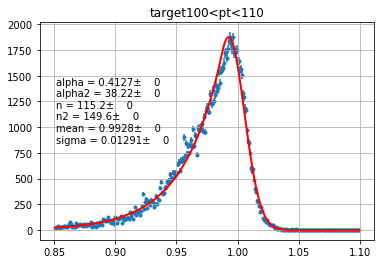

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -2.657551784945376, 4.0, 0.99, 0.013)


FCN = 953.288619329 
 TOTAL NCALL = 410 
 NCALLS = 399 
 
 
 EDM = 42862.2586285 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.390597 
 0.00141165 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 13.6916 
 0.0712963 
 
 
 
 
 No 
 
 
 2 
 n 
 72.6235 
 4.02158 
 
 
 
 
 No 
 
 
 3 
 n2 
 74.64 
 1 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992398 
 6.15701e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.390597 & 0.00141165 & & & & & No\\
\hline
1 & alpha2 & 13.6916 & 0.0712963 & & & & & No\\
\hline
2 & n & 72.6235 & 4.02158 & & & & & No\\
\hline
3 & n2 & 74.64 & 1 & & & & & No\\
\hline
4 & mean & 0.992398 & 6.15701e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 946.948198467 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 9.1095726242e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.390597 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 13.6916 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 72.6235 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 74.64 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.992398 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0131301 
 3.68423e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.390597 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 13.6916 & 1 & & & & & Yes\\
\hline
2 & n & 72.6235 & 1 & & & & & Yes\\
\hline
3 & n2 & 74.64 & 1 & & & & & Yes\\
\hline
4 & mean & 0.992398 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0131301 & 3.68423e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 933.517018311 
 TOTAL NCALL = 118 
 NCALLS = 107 
 
 
 EDM = 13698905065.7 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.393404 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 13.6916 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 112.804 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 74.64 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992405 
 0 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0131774 
 0 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.393404 & 0 & & & & & No\\
\hline
1 & alpha2 & 13.6916 & 0 & & & & & No\\
\hline
2 & n & 112.804 & 0 & & & & & No\\
\hline
3 & n2 & 74.64 & 0 & & & & & No\\
\hline
4 & mean & 0.992405 & 0 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0131774 & 0 & & & & & No\\
\hline
\end{tabular}

FCN = 933.517018311 
 TOTAL NCALL = 66 
 NCALLS = 55 
 
 
 EDM = 3.1213195451 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.393404 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 13.6916 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 112.804 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 74.64 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992405 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0131774 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.393404 & 0 & & & & & No\\
\hline
1 & alpha2 & 13.6916 & 0 & & & & & No\\
\hline
2 & n & 112.804 & 0 & & & & & No\\
\hline
3 & n2 & 74.64 & 0 & & & & & No\\
\hline
4 & mean & 0.992405 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0131774 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 933.517018311 
 TOTAL NCALL = 78 
 NCALLS = 67 
 
 
 EDM = 3.8845640913 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.393404 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 13.6916 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 112.804 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 74.64 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992405 
 0 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0131774 
 0 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.393404 & 0 & & & & & No\\
\hline
1 & alpha2 & 13.6916 & 0 & & & & & No\\
\hline
2 & n & 112.804 & 0 & & & & & No\\
\hline
3 & n2 & 74.64 & 0 & & & & & No\\
\hline
4 & mean & 0.992405 & 0 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0131774 & 0 & & & & & No\\
\hline
\end{tabular}

90<pt<100
21


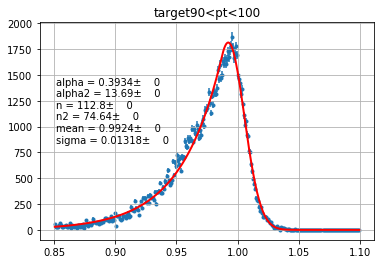

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -3.9961497370488974, 4.0, 0.99, 0.013)


FCN = 1412.65660468 
 TOTAL NCALL = 333 
 NCALLS = 333 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.349477 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 17.8337 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 62.7436 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 100.237 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992427 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.349477 & nan & & & & & No\\
\hline
1 & alpha2 & 17.8337 & nan & & & & & No\\
\hline
2 & n & 62.7436 & nan & & & & & No\\
\hline
3 & n2 & 100.237 & nan & & & & & No\\
\hline
4 & mean & 0.992427 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1366.13078981 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 2.84190660085e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.349477 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 17.8337 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 62.7436 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 100.237 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.992427 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0133655 
 3.87774e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.349477 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 17.8337 & 1 & & & & & Yes\\
\hline
2 & n & 62.7436 & 1 & & & & & Yes\\
\hline
3 & n2 & 100.237 & 1 & & & & & Yes\\
\hline
4 & mean & 0.992427 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0133655 & 3.87774e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1286.61972941 
 TOTAL NCALL = 118 
 NCALLS = 107 
 
 
 EDM = 4622870892.44 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.364117 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 17.8337 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 109.496 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 100.237 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992084 
 0 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013517 
 0 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.364117 & 0 & & & & & No\\
\hline
1 & alpha2 & 17.8337 & 0 & & & & & No\\
\hline
2 & n & 109.496 & 0 & & & & & No\\
\hline
3 & n2 & 100.237 & 0 & & & & & No\\
\hline
4 & mean & 0.992084 & 0 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013517 & 0 & & & & & No\\
\hline
\end{tabular}

FCN = 1286.61972941 
 TOTAL NCALL = 66 
 NCALLS = 55 
 
 
 EDM = 4.05714867218 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.364117 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 17.8337 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 109.496 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 100.237 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992084 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.013517 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.364117 & 0 & & & & & No\\
\hline
1 & alpha2 & 17.8337 & 0 & & & & & No\\
\hline
2 & n & 109.496 & 0 & & & & & No\\
\hline
3 & n2 & 100.237 & 0 & & & & & No\\
\hline
4 & mean & 0.992084 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.013517 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1286.61972941 
 TOTAL NCALL = 78 
 NCALLS = 67 
 
 
 EDM = 20.8175857883 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.364117 
 0 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 17.8337 
 0 
 
 
 
 
 No 
 
 
 2 
 n 
 109.496 
 0 
 
 
 
 
 No 
 
 
 3 
 n2 
 100.237 
 0 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.992084 
 0 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013517 
 0 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.364117 & 0 & & & & & No\\
\hline
1 & alpha2 & 17.8337 & 0 & & & & & No\\
\hline
2 & n & 109.496 & 0 & & & & & No\\
\hline
3 & n2 & 100.237 & 0 & & & & & No\\
\hline
4 & mean & 0.992084 & 0 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013517 & 0 & & & & & No\\
\hline
\end{tabular}

80<pt<90
22


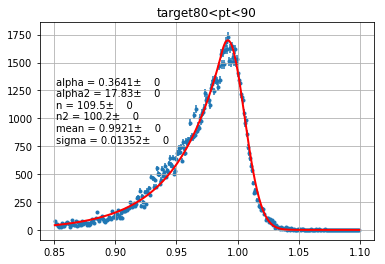

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:90: SmallIntegralWarning: (1.0, 1.0, -5.293893325627334, 4.0, 0.99, 0.013)


FCN = 882.268798342 
 TOTAL NCALL = 529 
 NCALLS = 529 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.321796 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.57346 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 119.603 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 80.1463 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.991257 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.013 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.321796 & nan & & & & & No\\
\hline
1 & alpha2 & 1.57346 & nan & & & & & No\\
\hline
2 & n & 119.603 & nan & & & & & No\\
\hline
3 & n2 & 80.1463 & nan & & & & & No\\
\hline
4 & mean & 0.991257 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.013 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 880.435941757 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 8.86124498798e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.321796 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.57346 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 119.603 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 80.1463 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 0.991257 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0130802 
 4.20607e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.321796 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.57346 & 1 & & & & & Yes\\
\hline
2 & n & 119.603 & 1 & & & & & Yes\\
\hline
3 & n2 & 80.1463 & 1 & & & & & Yes\\
\hline
4 & mean & 0.991257 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0130802 & 4.20607e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 880.435941757 
 TOTAL NCALL = 94 
 NCALLS = 94 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.321796 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.57346 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 119.603 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 80.1463 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.991257 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0130802 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.321796 & nan & & & & & No\\
\hline
1 & alpha2 & 1.57346 & nan & & & & & No\\
\hline
2 & n & 119.603 & nan & & & & & No\\
\hline
3 & n2 & 80.1463 & nan & & & & & No\\
\hline
4 & mean & 0.991257 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0130802 & nan & & & & & No\\
\hline
\end{tabular}

FCN = 880.435941757 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.321796 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.57346 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 119.603 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 80.1463 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.991257 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0130802 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.321796 & nan & & & & & No\\
\hline
1 & alpha2 & 1.57346 & nan & & & & & No\\
\hline
2 & n & 119.603 & nan & & & & & No\\
\hline
3 & n2 & 80.1463 & nan & & & & & No\\
\hline
4 & mean & 0.991257 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0130802 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 880.435941757 
 TOTAL NCALL = 94 
 NCALLS = 94 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.321796 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.57346 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 119.603 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 80.1463 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 0.991257 
 nan 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0130802 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.321796 & nan & & & & & No\\
\hline
1 & alpha2 & 1.57346 & nan & & & & & No\\
\hline
2 & n & 119.603 & nan & & & & & No\\
\hline
3 & n2 & 80.1463 & nan & & & & & No\\
\hline
4 & mean & 0.991257 & nan & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0130802 & nan & & & & & No\\
\hline
\end{tabular}

70<pt<80
23


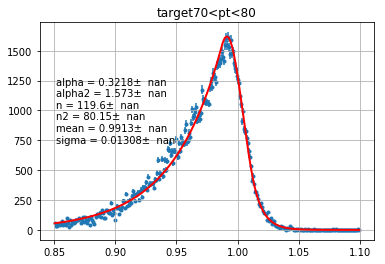

In [ ]:
tipe='target'
i=0
for para in feat_pt:
    if 23<i<26:
        rmin=0.93
        rmax=1.06
    if i>25:
        rmin=0.6
        rmax=1.3
    else:
        rmin=0.85
        rmax=1.1
    
    df=data.query(para).astype('double')
    df=df[tipe]
    bound_DCB=[rmin, rmax]
    normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(5):
        #first step
        if j==0: 
            pars_dcb = dict(mean  = 0.99, 
                        fix_mean = False,
                        sigma  = 0.013,
                        fix_sigma = True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
        
        elif j==1:
                pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = True,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = True
                        )
                
        elif j==3:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = True,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
                
        #optimize parameter withoptimized start parameter
        else:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
    
        minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_mean=(0.9,1.1), **pars_dcb)
        
        minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
    binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    if tipe=='target':
        mean_pt_un[i]=minuit.values['mean']
        mean_err_pt_un[i]=minuit.errors['mean']
        sigma_pt_un[i]=minuit.values['sigma']
        sigma_err_pt_un[i]=minuit.errors['sigma']
    if tipe=='z_default':
        mean_pt_de[i]=minuit.values['mean']
        mean_err_pt_de[i]=minuit.errors['mean']
        sigma_pt_de[i]=minuit.values['sigma']
        sigma_err_pt_de[i]=minuit.errors['sigma']       
    if tipe=='z_bo':
        mean_pt_bo[i]=minuit.values['mean']
        mean_err_pt_bo[i]=minuit.errors['mean']
        sigma_pt_bo[i]=minuit.values['sigma']
        sigma_err_pt_bo[i]=minuit.errors['sigma'] 
    print(para)
    print(i)
    i+=1
    if i==29:
        i=0
        
    plt.title(tipe+para)
    plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
    plt.show()
np.savetxt('pt_parameter_uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.4295034291958766, 1.745236675765589, -0.5060455052148924, 6.191494631614535, 1.0151214722676896, 0.015)


FCN = 624.062264682 
 TOTAL NCALL = 414 
 NCALLS = 414 
 
 
 EDM = 7.51169475804e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07552 
 0.0741399 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.2652 
 0.0997845 
 
 
 
 
 No 
 
 
 2 
 n 
 1.18529 
 0.1898 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.96879 
 0.276252 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0154 
 0.00018462 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07552 & 0.0741399 & & & & & No\\
\hline
1 & alpha2 & 2.2652 & 0.0997845 & & & & & No\\
\hline
2 & n & 1.18529 & 0.1898 & & & & & No\\
\hline
3 & n2 & 0.96879 & 0.276252 & & & & & No\\
\hline
4 & mean & 1.0154 & 0.00018462 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 235.155441127 
 TOTAL NCALL = 28 
 NCALLS = 28 
 
 
 EDM = 1.96682199845e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07552 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.2652 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.18529 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 0.96879 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0154 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0106745 
 0.000126007 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07552 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.2652 & 1 & & & & & Yes\\
\hline
2 & n & 1.18529 & 1 & & & & & Yes\\
\hline
3 & n2 & 0.96879 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0154 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0106745 & 0.000126007 & & & & & No\\
\hline
\end{tabular}

FCN = 123.472419189 
 TOTAL NCALL = 322 
 NCALLS = 322 
 
 
 EDM = 5.67886010262e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.78234 
 0.063574 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.15425 
 0.065296 
 
 
 
 
 No 
 
 
 2 
 n 
 1.35627 
 0.127918 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.08897 
 0.57885 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01437 
 0.000170746 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00896515 
 0.000186924 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.78234 & 0.063574 & & & & & No\\
\hline
1 & alpha2 & 1.15425 & 0.065296 & & & & & No\\
\hline
2 & n & 1.35627 & 0.127918 & & & & & No\\
\hline
3 & n2 & 4.08897 & 0.57885 & & & & & No\\
\hline
4 & mean & 1.01437 & 0.000170746 & & & & & No\\
\hline
5 & $\sigma$ & 0.00896515 & 0.000186924 & & & & & No\\
\hline
\end{tabular}

300<pt<310
0


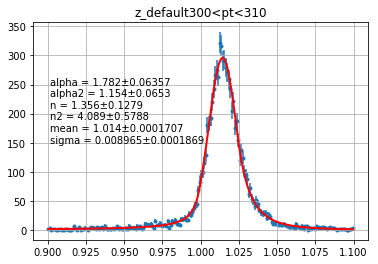

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (2.118214901896067, 2.413436694084509, -2.8613989156096444, 6.634576005322666, 1.0088039545171568, 0.015)


FCN = 4310.20000571 
 TOTAL NCALL = 296 
 NCALLS = 285 
 
 
 EDM = 164.88369186 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.62386 
 0.0141152 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.14589 
 0.065381 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00158 
 4.75931e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.99102 
 0.81047 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00783 
 5.06632e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.62386 & 0.0141152 & & & & & No\\
\hline
1 & alpha2 & 2.14589 & 0.065381 & & & & & No\\
\hline
2 & n & 1.00158 & 4.75931e-06 & & & & & No\\
\hline
3 & n2 & 3.99102 & 0.81047 & & & & & No\\
\hline
4 & mean & 1.00783 & 5.06632e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1200.3727388 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 1.11124243818e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.62386 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.14589 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00158 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.99102 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00783 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0119321 
 3.34568e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.62386 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.14589 & 1 & & & & & Yes\\
\hline
2 & n & 1.00158 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.99102 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00783 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0119321 & 3.34568e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 205.248020513 
 TOTAL NCALL = 455 
 NCALLS = 455 
 
 
 EDM = 1.29311924809e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.67707 
 0.0275617 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.38264 
 0.0244097 
 
 
 
 
 No 
 
 
 2 
 n 
 3.3137 
 0.151305 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.41002 
 0.414425 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00753 
 4.70506e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103965 
 5.99829e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.67707 & 0.0275617 & & & & & No\\
\hline
1 & alpha2 & 1.38264 & 0.0244097 & & & & & No\\
\hline
2 & n & 3.3137 & 0.151305 & & & & & No\\
\hline
3 & n2 & 6.41002 & 0.414425 & & & & & No\\
\hline
4 & mean & 1.00753 & 4.70506e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103965 & 5.99829e-05 & & & & & No\\
\hline
\end{tabular}

290<pt<300
1


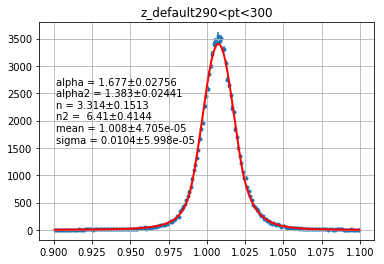

FCN = 3207.39058882 
 TOTAL NCALL = 398 
 NCALLS = 398 
 
 
 EDM = 1.88024279053e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.02274 
 0.0224578 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.44141 
 0.0350093 
 
 
 
 
 No 
 
 
 2 
 n 
 1.74817 
 0.0845742 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.6294 
 0.14172 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00634 
 4.89734e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.02274 & 0.0224578 & & & & & No\\
\hline
1 & alpha2 & 2.44141 & 0.0350093 & & & & & No\\
\hline
2 & n & 1.74817 & 0.0845742 & & & & & No\\
\hline
3 & n2 & 1.6294 & 0.14172 & & & & & No\\
\hline
4 & mean & 1.00634 & 4.89734e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (2.022740838917447, 2.441412613948892, 1.7481732647091386, 1.6294015681809337, 1.0063392844107002, -0.024110628348969654)


FCN = 1175.35376251 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 2.48398037909e-13 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.02274 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.44141 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.74817 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.6294 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00634 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0124881 
 3.53407e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.02274 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.44141 & 1 & & & & & Yes\\
\hline
2 & n & 1.74817 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.6294 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00634 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0124881 & 3.53407e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 172.163809185 
 TOTAL NCALL = 294 
 NCALLS = 294 
 
 
 EDM = 9.13742801076e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.31671 
 0.0189428 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.48168 
 0.0250527 
 
 
 
 
 No 
 
 
 2 
 n 
 3.61478 
 0.127405 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.16498 
 0.289879 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00682 
 4.76557e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0106559 
 6.39753e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.31671 & 0.0189428 & & & & & No\\
\hline
1 & alpha2 & 1.48168 & 0.0250527 & & & & & No\\
\hline
2 & n & 3.61478 & 0.127405 & & & & & No\\
\hline
3 & n2 & 5.16498 & 0.289879 & & & & & No\\
\hline
4 & mean & 1.00682 & 4.76557e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0106559 & 6.39753e-05 & & & & & No\\
\hline
\end{tabular}

280<pt<290
2


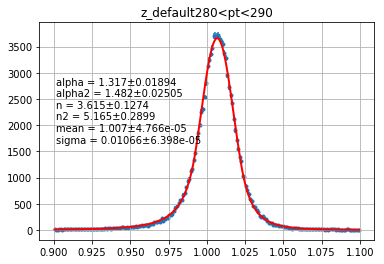

FCN = 2814.57239206 
 TOTAL NCALL = 401 
 NCALLS = 401 
 
 
 EDM = 3.4918192152e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.89625 
 0.0194638 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.3814 
 0.0349328 
 
 
 
 
 No 
 
 
 2 
 n 
 1.57436 
 0.0652018 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.69827 
 0.143957 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00628 
 4.96537e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.89625 & 0.0194638 & & & & & No\\
\hline
1 & alpha2 & 2.3814 & 0.0349328 & & & & & No\\
\hline
2 & n & 1.57436 & 0.0652018 & & & & & No\\
\hline
3 & n2 & 1.69827 & 0.143957 & & & & & No\\
\hline
4 & mean & 1.00628 & 4.96537e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.896250622001173, 2.3814010444929345, 1.5743631486127612, 1.6982656614745615, 1.0062817606994474, -0.02163783508269259)


FCN = 1007.32705115 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 4.54037299273e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.89625 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.3814 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.57436 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.69827 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00628 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0125508 
 3.65854e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.89625 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.3814 & 1 & & & & & Yes\\
\hline
2 & n & 1.57436 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.69827 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00628 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0125508 & 3.65854e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 154.32027772 
 TOTAL NCALL = 252 
 NCALLS = 252 
 
 
 EDM = 3.74044551611e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35855 
 0.0185711 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.54434 
 0.0270925 
 
 
 
 
 No 
 
 
 2 
 n 
 2.68165 
 0.0839943 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.51912 
 0.254678 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0068 
 4.82503e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109862 
 6.3777e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35855 & 0.0185711 & & & & & No\\
\hline
1 & alpha2 & 1.54434 & 0.0270925 & & & & & No\\
\hline
2 & n & 2.68165 & 0.0839943 & & & & & No\\
\hline
3 & n2 & 4.51912 & 0.254678 & & & & & No\\
\hline
4 & mean & 1.0068 & 4.82503e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109862 & 6.3777e-05 & & & & & No\\
\hline
\end{tabular}

270<pt<280
3


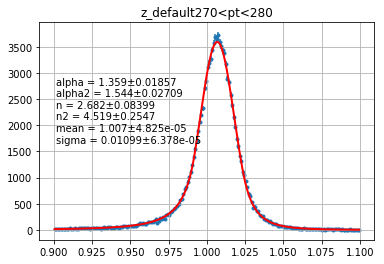

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.2913707308866431, 2.007128892706368, 0.20488412735830508, 7.872425310797523, 1.0066096810526375, 0.015)


FCN = 2868.60567146 
 TOTAL NCALL = 409 
 NCALLS = 409 
 
 
 EDM = 3.30458260421e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.0479 
 0.0201449 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.38735 
 0.0324598 
 
 
 
 
 No 
 
 
 2 
 n 
 1.12225 
 0.0505353 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.63544 
 0.13204 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00615 
 4.90454e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.0479 & 0.0201449 & & & & & No\\
\hline
1 & alpha2 & 2.38735 & 0.0324598 & & & & & No\\
\hline
2 & n & 1.12225 & 0.0505353 & & & & & No\\
\hline
3 & n2 & 1.63544 & 0.13204 & & & & & No\\
\hline
4 & mean & 1.00615 & 4.90454e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 898.047372787 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 3.70264201945e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.0479 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.38735 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.12225 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.63544 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00615 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0124667 
 3.60859e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.0479 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.38735 & 1 & & & & & Yes\\
\hline
2 & n & 1.12225 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.63544 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00615 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0124667 & 3.60859e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 189.123783286 
 TOTAL NCALL = 281 
 NCALLS = 281 
 
 
 EDM = 1.06158319782e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.49627 
 0.0197012 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.57754 
 0.0270056 
 
 
 
 
 No 
 
 
 2 
 n 
 2.15039 
 0.0667939 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.32017 
 0.240147 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00654 
 4.69522e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0111054 
 6.01546e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.49627 & 0.0197012 & & & & & No\\
\hline
1 & alpha2 & 1.57754 & 0.0270056 & & & & & No\\
\hline
2 & n & 2.15039 & 0.0667939 & & & & & No\\
\hline
3 & n2 & 4.32017 & 0.240147 & & & & & No\\
\hline
4 & mean & 1.00654 & 4.69522e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0111054 & 6.01546e-05 & & & & & No\\
\hline
\end{tabular}

260<pt<270
4


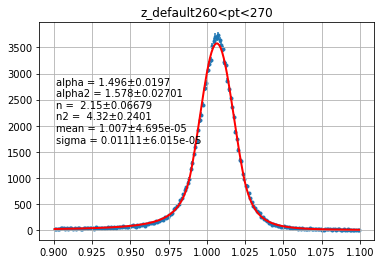

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.2677617786396147, 2.0063432444401896, -3.417450412882488, 7.992897513544548, 1.0068415891123632, 0.015)


FCN = 2596.83700929 
 TOTAL NCALL = 434 
 NCALLS = 434 
 
 
 EDM = 1.64110872765e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.97088 
 0.0194688 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.36337 
 0.0355096 
 
 
 
 
 No 
 
 
 2 
 n 
 1.18528 
 0.0503933 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.8552 
 0.158878 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00606 
 4.96762e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.97088 & 0.0194688 & & & & & No\\
\hline
1 & alpha2 & 2.36337 & 0.0355096 & & & & & No\\
\hline
2 & n & 1.18528 & 0.0503933 & & & & & No\\
\hline
3 & n2 & 1.8552 & 0.158878 & & & & & No\\
\hline
4 & mean & 1.00606 & 4.96762e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 944.328077655 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 8.76567111643e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.97088 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.36337 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.18528 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.8552 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00606 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0126455 
 3.68553e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.97088 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.36337 & 1 & & & & & Yes\\
\hline
2 & n & 1.18528 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.8552 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00606 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0126455 & 3.68553e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 184.022764735 
 TOTAL NCALL = 282 
 NCALLS = 282 
 
 
 EDM = 2.78309429932e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.41695 
 0.0194436 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.50463 
 0.0257522 
 
 
 
 
 No 
 
 
 2 
 n 
 2.24125 
 0.0687205 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.17662 
 0.303989 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00652 
 4.86746e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.011078 
 6.46829e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.41695 & 0.0194436 & & & & & No\\
\hline
1 & alpha2 & 1.50463 & 0.0257522 & & & & & No\\
\hline
2 & n & 2.24125 & 0.0687205 & & & & & No\\
\hline
3 & n2 & 5.17662 & 0.303989 & & & & & No\\
\hline
4 & mean & 1.00652 & 4.86746e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.011078 & 6.46829e-05 & & & & & No\\
\hline
\end{tabular}

250<pt<260
5


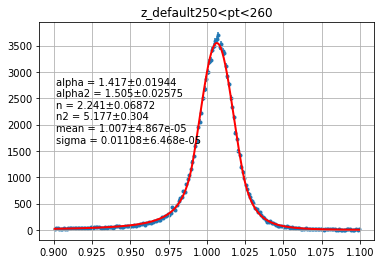

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.2645993565795803, 2.0125305246230933, 0.7086470659409159, 7.855799394300605, 1.0068105293522103, 0.015)


FCN = 2452.25513688 
 TOTAL NCALL = 300 
 NCALLS = 289 
 
 
 EDM = 7359.5970996 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.94825 
 0.0305704 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.2524 
 0.588614 
 
 
 
 
 No 
 
 
 2 
 n 
 1.5243 
 0.103212 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.55934 
 4.20854 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00633 
 6.62164e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.94825 & 0.0305704 & & & & & No\\
\hline
1 & alpha2 & 2.2524 & 0.588614 & & & & & No\\
\hline
2 & n & 1.5243 & 0.103212 & & & & & No\\
\hline
3 & n2 & 2.55934 & 4.20854 & & & & & No\\
\hline
4 & mean & 1.00633 & 6.62164e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1056.64200282 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 5.53093548188e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.94825 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.2524 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.5243 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.55934 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00633 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0128671 
 3.67467e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.94825 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.2524 & 1 & & & & & Yes\\
\hline
2 & n & 1.5243 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.55934 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00633 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0128671 & 3.67467e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 197.306786964 
 TOTAL NCALL = 316 
 NCALLS = 316 
 
 
 EDM = 1.89152675385e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38695 
 0.0197577 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.61869 
 0.0277954 
 
 
 
 
 No 
 
 
 2 
 n 
 2.60605 
 0.0854382 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.97513 
 0.219457 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00662 
 4.93734e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0113425 
 6.41496e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38695 & 0.0197577 & & & & & No\\
\hline
1 & alpha2 & 1.61869 & 0.0277954 & & & & & No\\
\hline
2 & n & 2.60605 & 0.0854382 & & & & & No\\
\hline
3 & n2 & 3.97513 & 0.219457 & & & & & No\\
\hline
4 & mean & 1.00662 & 4.93734e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0113425 & 6.41496e-05 & & & & & No\\
\hline
\end{tabular}

240<pt<250
6


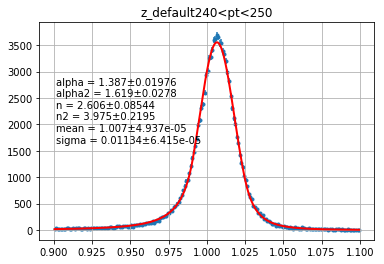

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.2670503282908123, 1.9535978250468693, -2.320611988499982, 7.800208462455182, 1.0067603428645289, 0.015)


FCN = 2391.00650245 
 TOTAL NCALL = 408 
 NCALLS = 408 
 
 
 EDM = 3.26122909e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.94209 
 0.0195104 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.36274 
 0.033246 
 
 
 
 
 No 
 
 
 2 
 n 
 1.24924 
 0.05241 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.66974 
 0.135479 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.006 
 4.99456e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.94209 & 0.0195104 & & & & & No\\
\hline
1 & alpha2 & 2.36274 & 0.033246 & & & & & No\\
\hline
2 & n & 1.24924 & 0.05241 & & & & & No\\
\hline
3 & n2 & 1.66974 & 0.135479 & & & & & No\\
\hline
4 & mean & 1.006 & 4.99456e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 843.625384374 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.33826056561e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.94209 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.36274 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.24924 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.66974 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.006 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0127031 
 3.73102e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.94209 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.36274 & 1 & & & & & Yes\\
\hline
2 & n & 1.24924 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.66974 & 1 & & & & & Yes\\
\hline
4 & mean & 1.006 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0127031 & 3.73102e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 159.734086015 
 TOTAL NCALL = 279 
 NCALLS = 279 
 
 
 EDM = 3.88149614562e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40492 
 0.0196045 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.5606 
 0.0260714 
 
 
 
 
 No 
 
 
 2 
 n 
 2.30052 
 0.0719742 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.40647 
 0.241135 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0065 
 4.93925e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0112161 
 6.43569e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40492 & 0.0196045 & & & & & No\\
\hline
1 & alpha2 & 1.5606 & 0.0260714 & & & & & No\\
\hline
2 & n & 2.30052 & 0.0719742 & & & & & No\\
\hline
3 & n2 & 4.40647 & 0.241135 & & & & & No\\
\hline
4 & mean & 1.0065 & 4.93925e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0112161 & 6.43569e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 159.734084157 
 TOTAL NCALL = 56 
 NCALLS = 56 
 
 
 EDM = 1.17056718859e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40493 
 0.014306 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.56061 
 0.0193521 
 
 
 
 
 No 
 
 
 2 
 n 
 2.30052 
 0.0628734 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.40655 
 0.218469 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0065 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0112161 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40493 & 0.014306 & & & & & No\\
\hline
1 & alpha2 & 1.56061 & 0.0193521 & & & & & No\\
\hline
2 & n & 2.30052 & 0.0628734 & & & & & No\\
\hline
3 & n2 & 4.40655 & 0.218469 & & & & & No\\
\hline
4 & mean & 1.0065 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0112161 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 159.734084157 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 2.02401793633e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40493 
 0.0196037 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.56061 
 0.0260735 
 
 
 
 
 No 
 
 
 2 
 n 
 2.30052 
 0.0719753 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.40655 
 0.241181 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0065 
 4.93922e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0112161 
 6.43481e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40493 & 0.0196037 & & & & & No\\
\hline
1 & alpha2 & 1.56061 & 0.0260735 & & & & & No\\
\hline
2 & n & 2.30052 & 0.0719753 & & & & & No\\
\hline
3 & n2 & 4.40655 & 0.241181 & & & & & No\\
\hline
4 & mean & 1.0065 & 4.93922e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0112161 & 6.43481e-05 & & & & & No\\
\hline
\end{tabular}

230<pt<240
7


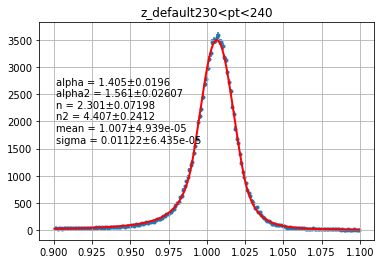

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.2323954053172375, 1.8842677800595957, -0.05899601455708137, 7.62843161350648, 1.0064297427822833, 0.015)


FCN = 2090.16836167 
 TOTAL NCALL = 379 
 NCALLS = 379 
 
 
 EDM = 7.46528474313e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.90339 
 0.0193336 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.32531 
 0.0324968 
 
 
 
 
 No 
 
 
 2 
 n 
 1.3232 
 0.0543273 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.67935 
 0.13239 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00606 
 4.98774e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.90339 & 0.0193336 & & & & & No\\
\hline
1 & alpha2 & 2.32531 & 0.0324968 & & & & & No\\
\hline
2 & n & 1.3232 & 0.0543273 & & & & & No\\
\hline
3 & n2 & 1.67935 & 0.13239 & & & & & No\\
\hline
4 & mean & 1.00606 & 4.98774e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 826.253667314 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 8.58981885476e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.90339 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.32531 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.3232 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.67935 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00606 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.012917 
 3.79256e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.90339 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.32531 & 1 & & & & & Yes\\
\hline
2 & n & 1.3232 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.67935 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00606 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.012917 & 3.79256e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 214.688716121 
 TOTAL NCALL = 280 
 NCALLS = 280 
 
 
 EDM = 4.8691943313e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.39037 
 0.020313 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.59728 
 0.0257802 
 
 
 
 
 No 
 
 
 2 
 n 
 2.38329 
 0.0785098 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.06997 
 0.216401 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00658 
 5.09703e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0115055 
 6.51824e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.39037 & 0.020313 & & & & & No\\
\hline
1 & alpha2 & 1.59728 & 0.0257802 & & & & & No\\
\hline
2 & n & 2.38329 & 0.0785098 & & & & & No\\
\hline
3 & n2 & 4.06997 & 0.216401 & & & & & No\\
\hline
4 & mean & 1.00658 & 5.09703e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0115055 & 6.51824e-05 & & & & & No\\
\hline
\end{tabular}

220<pt<230
8


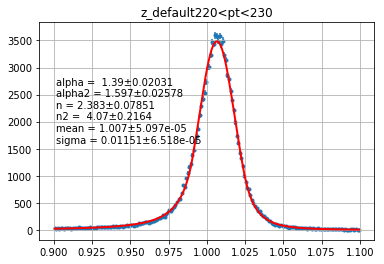

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.2502014648352622, 1.896967607256517, -0.877480787097948, 7.595330863511271, 1.0072184990269244, 0.015)


FCN = 2067.03493118 
 TOTAL NCALL = 355 
 NCALLS = 355 
 
 
 EDM = 1.75953141112e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.92023 
 0.0198445 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.3059 
 0.0331247 
 
 
 
 
 No 
 
 
 2 
 n 
 1.28147 
 0.0538711 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.65649 
 0.131522 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00651 
 5.02938e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.92023 & 0.0198445 & & & & & No\\
\hline
1 & alpha2 & 2.3059 & 0.0331247 & & & & & No\\
\hline
2 & n & 1.28147 & 0.0538711 & & & & & No\\
\hline
3 & n2 & 1.65649 & 0.131522 & & & & & No\\
\hline
4 & mean & 1.00651 & 5.02938e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 811.509971718 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.10705167555e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.92023 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.3059 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.28147 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.65649 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00651 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0129107 
 3.8173e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.92023 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.3059 & 1 & & & & & Yes\\
\hline
2 & n & 1.28147 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.65649 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00651 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0129107 & 3.8173e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 202.672759927 
 TOTAL NCALL = 251 
 NCALLS = 251 
 
 
 EDM = 5.96642842104e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40098 
 0.0194515 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.60676 
 0.0272335 
 
 
 
 
 No 
 
 
 2 
 n 
 2.33961 
 0.0740179 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.85131 
 0.20863 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00703 
 5.01825e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0115175 
 6.4919e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40098 & 0.0194515 & & & & & No\\
\hline
1 & alpha2 & 1.60676 & 0.0272335 & & & & & No\\
\hline
2 & n & 2.33961 & 0.0740179 & & & & & No\\
\hline
3 & n2 & 3.85131 & 0.20863 & & & & & No\\
\hline
4 & mean & 1.00703 & 5.01825e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0115175 & 6.4919e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 202.672739537 
 TOTAL NCALL = 56 
 NCALLS = 56 
 
 
 EDM = 1.55631192808e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40098 
 0.0142868 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.60674 
 0.0202613 
 
 
 
 
 No 
 
 
 2 
 n 
 2.33961 
 0.06497 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.85098 
 0.186613 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00703 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0115175 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40098 & 0.0142868 & & & & & No\\
\hline
1 & alpha2 & 1.60674 & 0.0202613 & & & & & No\\
\hline
2 & n & 2.33961 & 0.06497 & & & & & No\\
\hline
3 & n2 & 3.85098 & 0.186613 & & & & & No\\
\hline
4 & mean & 1.00703 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0115175 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 202.672739502 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 3.92013540626e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40098 
 0.0194503 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.60674 
 0.0272166 
 
 
 
 
 No 
 
 
 2 
 n 
 2.33961 
 0.0740178 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.85098 
 0.208465 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00703 
 5.01812e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0115175 
 6.49047e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40098 & 0.0194503 & & & & & No\\
\hline
1 & alpha2 & 1.60674 & 0.0272166 & & & & & No\\
\hline
2 & n & 2.33961 & 0.0740178 & & & & & No\\
\hline
3 & n2 & 3.85098 & 0.208465 & & & & & No\\
\hline
4 & mean & 1.00703 & 5.01812e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0115175 & 6.49047e-05 & & & & & No\\
\hline
\end{tabular}

210<pt<220
9


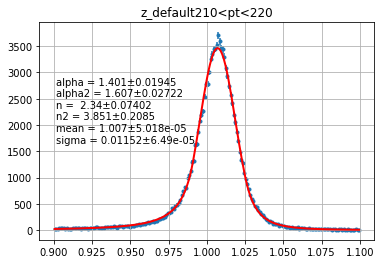

FCN = 1846.54147487 
 TOTAL NCALL = 367 
 NCALLS = 367 
 
 
 EDM = 1.69748911775e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.83528 
 0.0193107 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.27654 
 0.0307697 
 
 
 
 
 No 
 
 
 2 
 n 
 1.43902 
 0.0578148 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.72696 
 0.128723 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00682 
 5.0927e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.83528 & 0.0193107 & & & & & No\\
\hline
1 & alpha2 & 2.27654 & 0.0307697 & & & & & No\\
\hline
2 & n & 1.43902 & 0.0578148 & & & & & No\\
\hline
3 & n2 & 1.72696 & 0.128723 & & & & & No\\
\hline
4 & mean & 1.00682 & 5.0927e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.8352824448789435, 2.276540824221204, 1.439019527827658, 1.72695717313345, 1.0068190544075768, -0.014677228694204972)


FCN = 756.147796622 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.45461999735e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.83528 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.27654 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.43902 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.72696 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00682 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0130215 
 3.89495e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.83528 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.27654 & 1 & & & & & Yes\\
\hline
2 & n & 1.43902 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.72696 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00682 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0130215 & 3.89495e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 177.857019574 
 TOTAL NCALL = 254 
 NCALLS = 254 
 
 
 EDM = 3.47616158504e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.32314 
 0.0192196 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.63098 
 0.0265314 
 
 
 
 
 No 
 
 
 2 
 n 
 2.56939 
 0.0832281 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.66267 
 0.19274 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00749 
 5.27621e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0115845 
 6.64377e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.32314 & 0.0192196 & & & & & No\\
\hline
1 & alpha2 & 1.63098 & 0.0265314 & & & & & No\\
\hline
2 & n & 2.56939 & 0.0832281 & & & & & No\\
\hline
3 & n2 & 3.66267 & 0.19274 & & & & & No\\
\hline
4 & mean & 1.00749 & 5.27621e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0115845 & 6.64377e-05 & & & & & No\\
\hline
\end{tabular}

200<pt<210
10


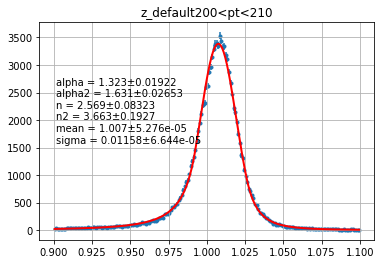

FCN = 1653.5963204 
 TOTAL NCALL = 338 
 NCALLS = 338 
 
 
 EDM = 3.03959436741e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.80847 
 0.0190627 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.16239 
 0.0279118 
 
 
 
 
 No 
 
 
 2 
 n 
 1.52096 
 0.0595971 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.80591 
 0.120295 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00707 
 5.15158e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.80847 & 0.0190627 & & & & & No\\
\hline
1 & alpha2 & 2.16239 & 0.0279118 & & & & & No\\
\hline
2 & n & 1.52096 & 0.0595971 & & & & & No\\
\hline
3 & n2 & 1.80591 & 0.120295 & & & & & No\\
\hline
4 & mean & 1.00707 & 5.15158e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.8084707323551892, 2.1623873669230935, 1.5209624397934092, 1.8059076060700832, 1.0070695303335109, -0.013084417294829311)


FCN = 772.911866539 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.5769207725e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.80847 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.16239 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.52096 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.80591 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00707 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0131871 
 4.005e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.80847 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.16239 & 1 & & & & & Yes\\
\hline
2 & n & 1.52096 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.80591 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00707 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0131871 & 4.005e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 206.208230663 
 TOTAL NCALL = 254 
 NCALLS = 254 
 
 
 EDM = 4.13387063622e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.283 
 0.0198065 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.57676 
 0.0239632 
 
 
 
 
 No 
 
 
 2 
 n 
 2.76024 
 0.0931358 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.48333 
 0.166098 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00773 
 5.53088e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0116316 
 7.05631e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.283 & 0.0198065 & & & & & No\\
\hline
1 & alpha2 & 1.57676 & 0.0239632 & & & & & No\\
\hline
2 & n & 2.76024 & 0.0931358 & & & & & No\\
\hline
3 & n2 & 3.48333 & 0.166098 & & & & & No\\
\hline
4 & mean & 1.00773 & 5.53088e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0116316 & 7.05631e-05 & & & & & No\\
\hline
\end{tabular}

190<pt<200
11


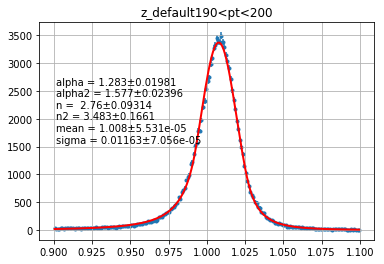

FCN = 1310.84479195 
 TOTAL NCALL = 346 
 NCALLS = 346 
 
 
 EDM = 4.31772846721e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.74083 
 0.0189634 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.09901 
 0.0282855 
 
 
 
 
 No 
 
 
 2 
 n 
 1.65637 
 0.064198 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.91463 
 0.127615 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00738 
 5.27076e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.74083 & 0.0189634 & & & & & No\\
\hline
1 & alpha2 & 2.09901 & 0.0282855 & & & & & No\\
\hline
2 & n & 1.65637 & 0.064198 & & & & & No\\
\hline
3 & n2 & 1.91463 & 0.127615 & & & & & No\\
\hline
4 & mean & 1.00738 & 5.27076e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.7408254172151134, 2.0990071404617474, 1.6563712234295356, 1.9146298579697554, 1.007376272125285, -0.010005956280013342)


FCN = 688.930467915 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.00550756938e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.74083 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.09901 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.65637 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.91463 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00738 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0134447 
 4.14349e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.74083 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.09901 & 1 & & & & & Yes\\
\hline
2 & n & 1.65637 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.91463 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00738 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0134447 & 4.14349e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 207.793429648 
 TOTAL NCALL = 252 
 NCALLS = 252 
 
 
 EDM = 4.28682221145e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24413 
 0.0197014 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.56387 
 0.025619 
 
 
 
 
 No 
 
 
 2 
 n 
 2.93728 
 0.102479 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.49951 
 0.177911 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00805 
 5.76815e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0118911 
 7.60615e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24413 & 0.0197014 & & & & & No\\
\hline
1 & alpha2 & 1.56387 & 0.025619 & & & & & No\\
\hline
2 & n & 2.93728 & 0.102479 & & & & & No\\
\hline
3 & n2 & 3.49951 & 0.177911 & & & & & No\\
\hline
4 & mean & 1.00805 & 5.76815e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0118911 & 7.60615e-05 & & & & & No\\
\hline
\end{tabular}

180<pt<190
12


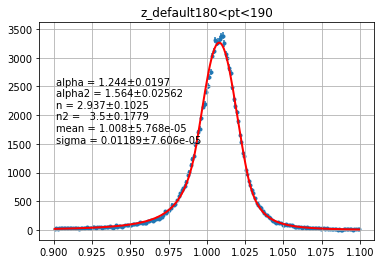

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.4746286544989293, 1.7855074865795708, 0.09018738439476515, 7.005817789974853, 1.0084797087912423, 0.015)


FCN = 1109.68184525 
 TOTAL NCALL = 328 
 NCALLS = 328 
 
 
 EDM = 1.68945597334e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.72557 
 0.019122 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.94738 
 0.0266969 
 
 
 
 
 No 
 
 
 2 
 n 
 1.64479 
 0.0636567 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.50329 
 0.159237 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00784 
 5.39766e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.72557 & 0.019122 & & & & & No\\
\hline
1 & alpha2 & 1.94738 & 0.0266969 & & & & & No\\
\hline
2 & n & 1.64479 & 0.0636567 & & & & & No\\
\hline
3 & n2 & 2.50329 & 0.159237 & & & & & No\\
\hline
4 & mean & 1.00784 & 5.39766e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 613.307535308 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.40281664553e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.72557 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.94738 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.64479 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.50329 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00784 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0135885 
 4.2233e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.72557 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.94738 & 1 & & & & & Yes\\
\hline
2 & n & 1.64479 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.50329 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00784 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0135885 & 4.2233e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 169.656524941 
 TOTAL NCALL = 270 
 NCALLS = 270 
 
 
 EDM = 3.60549188403e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.2652 
 0.0195067 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.45578 
 0.0245226 
 
 
 
 
 No 
 
 
 2 
 n 
 2.77787 
 0.0940357 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.1923 
 0.226108 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00835 
 5.72089e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0120154 
 7.8661e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.2652 & 0.0195067 & & & & & No\\
\hline
1 & alpha2 & 1.45578 & 0.0245226 & & & & & No\\
\hline
2 & n & 2.77787 & 0.0940357 & & & & & No\\
\hline
3 & n2 & 4.1923 & 0.226108 & & & & & No\\
\hline
4 & mean & 1.00835 & 5.72089e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0120154 & 7.8661e-05 & & & & & No\\
\hline
\end{tabular}

170<pt<180
13


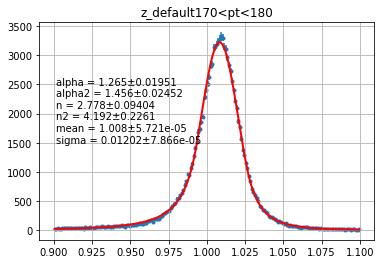

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.4920419610917501, 1.7114319706392414, 0.2754934675814793, 6.6205479950633705, 1.0090411868917053, 0.015)


FCN = 859.814163111 
 TOTAL NCALL = 343 
 NCALLS = 343 
 
 
 EDM = 1.35257754912e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.70834 
 0.0182078 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.01057 
 0.0271026 
 
 
 
 
 No 
 
 
 2 
 n 
 1.68021 
 0.0623684 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.96453 
 0.123999 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00853 
 5.32199e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.70834 & 0.0182078 & & & & & No\\
\hline
1 & alpha2 & 2.01057 & 0.0271026 & & & & & No\\
\hline
2 & n & 1.68021 & 0.0623684 & & & & & No\\
\hline
3 & n2 & 1.96453 & 0.123999 & & & & & No\\
\hline
4 & mean & 1.00853 & 5.32199e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 474.603717625 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 7.97586800267e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.70834 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.01057 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.68021 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.96453 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00853 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.013759 
 4.25265e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.70834 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.01057 & 1 & & & & & Yes\\
\hline
2 & n & 1.68021 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.96453 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00853 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.013759 & 4.25265e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 161.277735441 
 TOTAL NCALL = 236 
 NCALLS = 236 
 
 
 EDM = 6.89913089057e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.3367 
 0.0193909 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.50526 
 0.0266949 
 
 
 
 
 No 
 
 
 2 
 n 
 2.54795 
 0.0853579 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.75073 
 0.208188 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00885 
 5.59543e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0124493 
 7.66906e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.3367 & 0.0193909 & & & & & No\\
\hline
1 & alpha2 & 1.50526 & 0.0266949 & & & & & No\\
\hline
2 & n & 2.54795 & 0.0853579 & & & & & No\\
\hline
3 & n2 & 3.75073 & 0.208188 & & & & & No\\
\hline
4 & mean & 1.00885 & 5.59543e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0124493 & 7.66906e-05 & & & & & No\\
\hline
\end{tabular}

160<pt<170
14


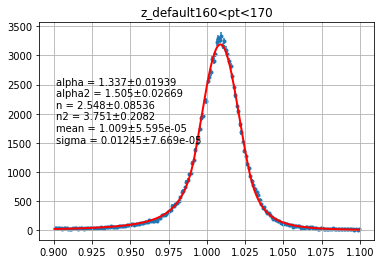

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.4363953801683973, 1.6405189460399372, 0.9187098775020002, 6.51108379412058, 1.0092603137522451, 0.015)


FCN = 614.805907079 
 TOTAL NCALL = 315 
 NCALLS = 315 
 
 
 EDM = 2.09696408227e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.62381 
 0.0182841 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.86457 
 0.0257428 
 
 
 
 
 No 
 
 
 2 
 n 
 1.79874 
 0.0662717 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.16667 
 0.129536 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00896 
 5.63802e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.62381 & 0.0182841 & & & & & No\\
\hline
1 & alpha2 & 1.86457 & 0.0257428 & & & & & No\\
\hline
2 & n & 1.79874 & 0.0662717 & & & & & No\\
\hline
3 & n2 & 2.16667 & 0.129536 & & & & & No\\
\hline
4 & mean & 1.00896 & 5.63802e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 408.469753082 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.54162638363e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.62381 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.86457 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.79874 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.16667 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00896 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0140465 
 4.52457e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.62381 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.86457 & 1 & & & & & Yes\\
\hline
2 & n & 1.79874 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.16667 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00896 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0140465 & 4.52457e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 182.397568006 
 TOTAL NCALL = 234 
 NCALLS = 234 
 
 
 EDM = 8.89019518635e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.30756 
 0.0190296 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.46328 
 0.0247481 
 
 
 
 
 No 
 
 
 2 
 n 
 2.56769 
 0.086427 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.59795 
 0.191125 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00923 
 5.87914e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.012812 
 7.94988e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.30756 & 0.0190296 & & & & & No\\
\hline
1 & alpha2 & 1.46328 & 0.0247481 & & & & & No\\
\hline
2 & n & 2.56769 & 0.086427 & & & & & No\\
\hline
3 & n2 & 3.59795 & 0.191125 & & & & & No\\
\hline
4 & mean & 1.00923 & 5.87914e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.012812 & 7.94988e-05 & & & & & No\\
\hline
\end{tabular}

150<pt<160
15


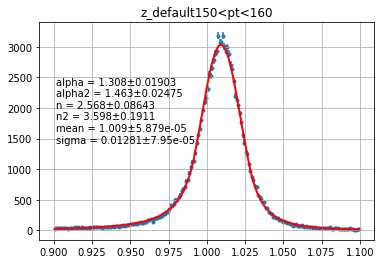

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.5764107821618434, 1.4810800683221323, 0.9988036556009781, 6.004019686247501, 1.0097039824856846, 0.015)


FCN = 329.756822652 
 TOTAL NCALL = 292 
 NCALLS = 292 
 
 
 EDM = 2.71679656875e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.57971 
 0.0181339 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.64306 
 0.0243576 
 
 
 
 
 No 
 
 
 2 
 n 
 1.95356 
 0.0722848 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.04014 
 0.185874 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00934 
 5.97096e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.57971 & 0.0181339 & & & & & No\\
\hline
1 & alpha2 & 1.64306 & 0.0243576 & & & & & No\\
\hline
2 & n & 1.95356 & 0.0722848 & & & & & No\\
\hline
3 & n2 & 3.04014 & 0.185874 & & & & & No\\
\hline
4 & mean & 1.00934 & 5.97096e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 270.833374169 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 2.62189345929e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.57971 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.64306 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.95356 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.04014 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00934 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0144804 
 4.69237e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.57971 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.64306 & 1 & & & & & Yes\\
\hline
2 & n & 1.95356 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.04014 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00934 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0144804 & 4.69237e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 178.305073456 
 TOTAL NCALL = 235 
 NCALLS = 235 
 
 
 EDM = 7.68407512445e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.36585 
 0.0210224 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.36265 
 0.0266489 
 
 
 
 
 No 
 
 
 2 
 n 
 2.50187 
 0.0926274 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.5302 
 0.297207 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00938 
 6.29013e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.013539 
 9.13947e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.36585 & 0.0210224 & & & & & No\\
\hline
1 & alpha2 & 1.36265 & 0.0266489 & & & & & No\\
\hline
2 & n & 2.50187 & 0.0926274 & & & & & No\\
\hline
3 & n2 & 4.5302 & 0.297207 & & & & & No\\
\hline
4 & mean & 1.00938 & 6.29013e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.013539 & 9.13947e-05 & & & & & No\\
\hline
\end{tabular}

140<pt<150
16


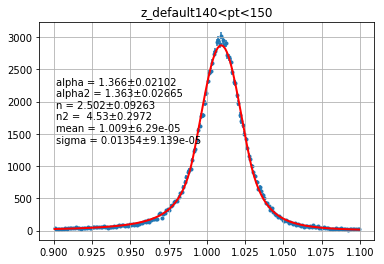

FCN = 277.799852582 
 TOTAL NCALL = 289 
 NCALLS = 289 
 
 
 EDM = 6.89798394194e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.53496 
 0.0179606 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.52191 
 0.0220084 
 
 
 
 
 No 
 
 
 2 
 n 
 1.96882 
 0.0721221 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.04543 
 0.172054 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00966 
 6.27509e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.53496 & 0.0179606 & & & & & No\\
\hline
1 & alpha2 & 1.52191 & 0.0220084 & & & & & No\\
\hline
2 & n & 1.96882 & 0.0721221 & & & & & No\\
\hline
3 & n2 & 3.04543 & 0.172054 & & & & & No\\
\hline
4 & mean & 1.00966 & 6.27509e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 248.076801667 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 4.2849127163e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.53496 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.52191 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.96882 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.04543 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00966 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0146144 
 4.93103e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.53496 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.52191 & 1 & & & & & Yes\\
\hline
2 & n & 1.96882 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.04543 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00966 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0146144 & 4.93103e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 187.308806292 
 TOTAL NCALL = 219 
 NCALLS = 219 
 
 
 EDM = 1.70630926741e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.36197 
 0.0218584 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.28402 
 0.0254128 
 
 
 
 
 No 
 
 
 2 
 n 
 2.39394 
 0.0904378 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.35345 
 0.273236 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0096 
 6.63384e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0137286 
 0.000100954 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.36197 & 0.0218584 & & & & & No\\
\hline
1 & alpha2 & 1.28402 & 0.0254128 & & & & & No\\
\hline
2 & n & 2.39394 & 0.0904378 & & & & & No\\
\hline
3 & n2 & 4.35345 & 0.273236 & & & & & No\\
\hline
4 & mean & 1.0096 & 6.63384e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0137286 & 0.000100954 & & & & & No\\
\hline
\end{tabular}

130<pt<140
17


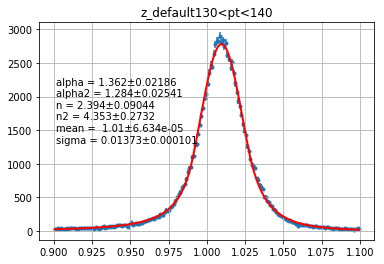

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.1055976722169754, 1.2545486057115274, 0.8150221648266305, 6.581790441204854, 1.010817653473018, 0.015)


FCN = 210.069042796 
 TOTAL NCALL = 272 
 NCALLS = 272 
 
 
 EDM = 4.05592788821e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40416 
 0.0172892 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.29966 
 0.0193647 
 
 
 
 
 No 
 
 
 2 
 n 
 2.35309 
 0.0877022 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.28711 
 0.377145 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01017 
 6.91886e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40416 & 0.0172892 & & & & & No\\
\hline
1 & alpha2 & 1.29966 & 0.0193647 & & & & & No\\
\hline
2 & n & 2.35309 & 0.0877022 & & & & & No\\
\hline
3 & n2 & 5.28711 & 0.377145 & & & & & No\\
\hline
4 & mean & 1.01017 & 6.91886e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 204.713164949 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 7.6197074637e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40416 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.29966 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.35309 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 5.28711 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01017 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0148353 
 5.0013e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40416 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.29966 & 1 & & & & & Yes\\
\hline
2 & n & 2.35309 & 1 & & & & & Yes\\
\hline
3 & n2 & 5.28711 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01017 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0148353 & 5.0013e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 186.450630342 
 TOTAL NCALL = 222 
 NCALLS = 222 
 
 
 EDM = 6.55936026002e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.31024 
 0.021548 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.1673 
 0.0260715 
 
 
 
 
 No 
 
 
 2 
 n 
 2.60467 
 0.101183 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.86346 
 0.615878 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01008 
 7.35859e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0142326 
 0.000117283 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.31024 & 0.021548 & & & & & No\\
\hline
1 & alpha2 & 1.1673 & 0.0260715 & & & & & No\\
\hline
2 & n & 2.60467 & 0.101183 & & & & & No\\
\hline
3 & n2 & 6.86346 & 0.615878 & & & & & No\\
\hline
4 & mean & 1.01008 & 7.35859e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0142326 & 0.000117283 & & & & & No\\
\hline
\end{tabular}

120<pt<130
18


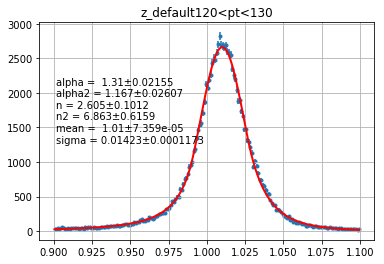

FCN = 212.816407913 
 TOTAL NCALL = 254 
 NCALLS = 254 
 
 
 EDM = 1.04916441724e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.28326 
 0.016165 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18893 
 0.0176178 
 
 
 
 
 No 
 
 
 2 
 n 
 2.7617 
 0.105043 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.77754 
 0.425249 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00993 
 7.47613e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.28326 & 0.016165 & & & & & No\\
\hline
1 & alpha2 & 1.18893 & 0.0176178 & & & & & No\\
\hline
2 & n & 2.7617 & 0.105043 & & & & & No\\
\hline
3 & n2 & 5.77754 & 0.425249 & & & & & No\\
\hline
4 & mean & 1.00993 & 7.47613e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 211.597899273 
 TOTAL NCALL = 17 
 NCALLS = 17 
 
 
 EDM = 2.49102902238e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.28326 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.18893 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.7617 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 5.77754 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00993 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0149194 
 5.12059e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.28326 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.18893 & 1 & & & & & Yes\\
\hline
2 & n & 2.7617 & 1 & & & & & Yes\\
\hline
3 & n2 & 5.77754 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00993 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0149194 & 5.12059e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 205.413303628 
 TOTAL NCALL = 205 
 NCALLS = 205 
 
 
 EDM = 1.90807554419e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.2239 
 0.0219511 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.11466 
 0.025017 
 
 
 
 
 No 
 
 
 2 
 n 
 2.95174 
 0.121913 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.70871 
 0.585969 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00988 
 7.72056e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0145002 
 0.000132875 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.2239 & 0.0219511 & & & & & No\\
\hline
1 & alpha2 & 1.11466 & 0.025017 & & & & & No\\
\hline
2 & n & 2.95174 & 0.121913 & & & & & No\\
\hline
3 & n2 & 6.70871 & 0.585969 & & & & & No\\
\hline
4 & mean & 1.00988 & 7.72056e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0145002 & 0.000132875 & & & & & No\\
\hline
\end{tabular}

110<pt<120
19


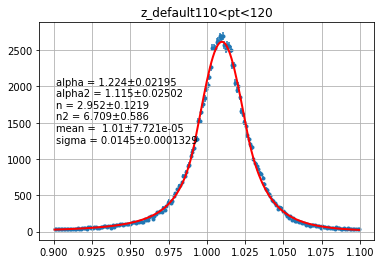

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.0310761304552294, 1.0520022053620863, -1.0724238405331707, 5.665608791243927, 1.0095514491522424, 0.015)


FCN = 178.196349464 
 TOTAL NCALL = 236 
 NCALLS = 236 
 
 
 EDM = 6.94358769368e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.17037 
 0.0158613 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.13525 
 0.0175739 
 
 
 
 
 No 
 
 
 2 
 n 
 3.40964 
 0.147472 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.06255 
 0.351121 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00907 
 8.30338e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.17037 & 0.0158613 & & & & & No\\
\hline
1 & alpha2 & 1.13525 & 0.0175739 & & & & & No\\
\hline
2 & n & 3.40964 & 0.147472 & & & & & No\\
\hline
3 & n2 & 5.06255 & 0.351121 & & & & & No\\
\hline
4 & mean & 1.00907 & 8.30338e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 175.59504247 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 1.00183131152e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.17037 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.13525 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.40964 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 5.06255 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00907 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151216 
 5.3602e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.17037 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.13525 & 1 & & & & & Yes\\
\hline
2 & n & 3.40964 & 1 & & & & & Yes\\
\hline
3 & n2 & 5.06255 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00907 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151216 & 5.3602e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 160.823537603 
 TOTAL NCALL = 221 
 NCALLS = 221 
 
 
 EDM = 1.03071833769e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26229 
 0.0221871 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.24985 
 0.0275435 
 
 
 
 
 No 
 
 
 2 
 n 
 3.04142 
 0.140951 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.11527 
 0.304487 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0091 
 7.93646e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0157685 
 0.000123845 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26229 & 0.0221871 & & & & & No\\
\hline
1 & alpha2 & 1.24985 & 0.0275435 & & & & & No\\
\hline
2 & n & 3.04142 & 0.140951 & & & & & No\\
\hline
3 & n2 & 4.11527 & 0.304487 & & & & & No\\
\hline
4 & mean & 1.0091 & 7.93646e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0157685 & 0.000123845 & & & & & No\\
\hline
\end{tabular}

100<pt<110
20


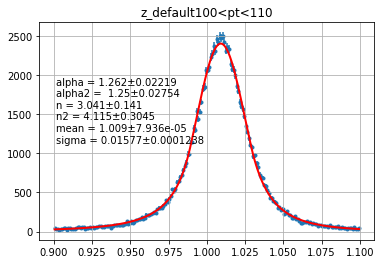

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.0264019276713119, 0.925492458512698, -4.556443043302583, 4.881665491112852, 1.0073889477930453, 0.015)


FCN = 188.120785198 
 TOTAL NCALL = 305 
 NCALLS = 305 
 
 
 EDM = 2.79238181363e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.13696 
 0.0161033 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.813445 
 0.0120998 
 
 
 
 
 No 
 
 
 2 
 n 
 3.50502 
 0.161551 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.1534 
 2.19183 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00665 
 9.75871e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.13696 & 0.0161033 & & & & & No\\
\hline
1 & alpha2 & 0.813445 & 0.0120998 & & & & & No\\
\hline
2 & n & 3.50502 & 0.161551 & & & & & No\\
\hline
3 & n2 & 14.1534 & 2.19183 & & & & & No\\
\hline
4 & mean & 1.00665 & 9.75871e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 183.793060831 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 7.3149970135e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.13696 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.813445 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.50502 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 14.1534 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00665 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151578 
 5.40306e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.13696 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.813445 & 1 & & & & & Yes\\
\hline
2 & n & 3.50502 & 1 & & & & & Yes\\
\hline
3 & n2 & 14.1534 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00665 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151578 & 5.40306e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 138.16396069 
 TOTAL NCALL = 316 
 NCALLS = 316 
 
 
 EDM = 4.28167160868e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.30834 
 0.0237397 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.991117 
 0.0235779 
 
 
 
 
 No 
 
 
 2 
 n 
 2.88134 
 0.143359 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.44878 
 0.828276 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0071 
 9.83558e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0166564 
 0.000150464 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.30834 & 0.0237397 & & & & & No\\
\hline
1 & alpha2 & 0.991117 & 0.0235779 & & & & & No\\
\hline
2 & n & 2.88134 & 0.143359 & & & & & No\\
\hline
3 & n2 & 7.44878 & 0.828276 & & & & & No\\
\hline
4 & mean & 1.0071 & 9.83558e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0166564 & 0.000150464 & & & & & No\\
\hline
\end{tabular}

90<pt<100
21


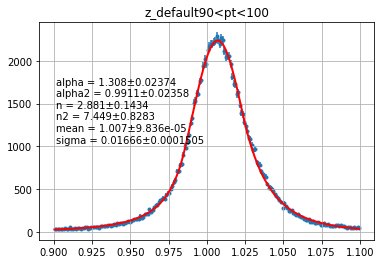

FCN = 1468.62290146 
 TOTAL NCALL = 104 
 NCALLS = 93 
 
 
 EDM = 3337.21538065 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0.00380956 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0.0616921 
 
 
 
 
 No 
 
 
 2 
 n 
 5.52719 
 0.0961179 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 1.98321 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.004 
 9.65115e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0.00380956 & & & & & No\\
\hline
1 & alpha2 & 1 & 0.0616921 & & & & & No\\
\hline
2 & n & 5.52719 & 0.0961179 & & & & & No\\
\hline
3 & n2 & 4 & 1.98321 & & & & & No\\
\hline
4 & mean & 1.004 & 9.65115e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.0, 1.0, 5.527194289516518, 4.0, 1.004, -0.011467570834424099)


FCN = 998.511828537 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 4.83314485114e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 5.52719 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.004 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.016821 
 6.37986e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1 & 1 & & & & & Yes\\
\hline
2 & n & 5.52719 & 1 & & & & & Yes\\
\hline
3 & n2 & 4 & 1 & & & & & Yes\\
\hline
4 & mean & 1.004 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.016821 & 6.37986e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 170.42991931 
 TOTAL NCALL = 473 
 NCALLS = 462 
 
 
 EDM = 0.409934947329 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.31462 
 0.0257328 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.784036 
 0.0120716 
 
 
 
 
 No 
 
 
 2 
 n 
 2.82537 
 0.157739 
 
 
 
 
 No 
 
 
 3 
 n2 
 128.564 
 55.6611 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00477 
 0.000114101 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0175473 
 0.000177979 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.31462 & 0.0257328 & & & & & No\\
\hline
1 & alpha2 & 0.784036 & 0.0120716 & & & & & No\\
\hline
2 & n & 2.82537 & 0.157739 & & & & & No\\
\hline
3 & n2 & 128.564 & 55.6611 & & & & & No\\
\hline
4 & mean & 1.00477 & 0.000114101 & & & & & No\\
\hline
5 & $\sigma$ & 0.0175473 & 0.000177979 & & & & & No\\
\hline
\end{tabular}

FCN = 170.42991931 
 TOTAL NCALL = 64 
 NCALLS = 53 
 
 
 EDM = 0.407706668797 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.31462 
 0.0179344 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.784036 
 0.00491529 
 
 
 
 
 No 
 
 
 2 
 n 
 2.82537 
 0.141531 
 
 
 
 
 No 
 
 
 3 
 n2 
 128.564 
 54.845 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00477 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0175473 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.31462 & 0.0179344 & & & & & No\\
\hline
1 & alpha2 & 0.784036 & 0.00491529 & & & & & No\\
\hline
2 & n & 2.82537 & 0.141531 & & & & & No\\
\hline
3 & n2 & 128.564 & 54.845 & & & & & No\\
\hline
4 & mean & 1.00477 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0175473 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 170.42991931 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 0.410956190519 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.31462 
 0.0252605 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.784036 
 0.0115658 
 
 
 
 
 No 
 
 
 2 
 n 
 2.82537 
 0.157231 
 
 
 
 
 No 
 
 
 3 
 n2 
 128.564 
 55.7379 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00477 
 0.000112314 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0175473 
 0.000169478 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.31462 & 0.0252605 & & & & & No\\
\hline
1 & alpha2 & 0.784036 & 0.0115658 & & & & & No\\
\hline
2 & n & 2.82537 & 0.157231 & & & & & No\\
\hline
3 & n2 & 128.564 & 55.7379 & & & & & No\\
\hline
4 & mean & 1.00477 & 0.000112314 & & & & & No\\
\hline
5 & $\sigma$ & 0.0175473 & 0.000169478 & & & & & No\\
\hline
\end{tabular}

80<pt<90
22


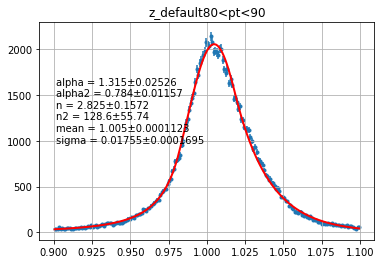

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.0, 1.0, -1.4126639150517324, 4.0, 1.004, 0.015)


FCN = 307.401563761 
 TOTAL NCALL = 662 
 NCALLS = 651 
 
 
 EDM = 2.01749938918 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.808549 
 0.0134442 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.604235 
 0.00395084 
 
 
 
 
 No 
 
 
 2 
 n 
 6.21746 
 0.485817 
 
 
 
 
 No 
 
 
 3 
 n2 
 124.852 
 33.7878 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00538 
 0.000132473 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.808549 & 0.0134442 & & & & & No\\
\hline
1 & alpha2 & 0.604235 & 0.00395084 & & & & & No\\
\hline
2 & n & 6.21746 & 0.485817 & & & & & No\\
\hline
3 & n2 & 124.852 & 33.7878 & & & & & No\\
\hline
4 & mean & 1.00538 & 0.000132473 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 303.029253644 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 1.50908594109e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.808549 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.604235 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 6.21746 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 124.852 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00538 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151672 
 5.70561e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.808549 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.604235 & 1 & & & & & Yes\\
\hline
2 & n & 6.21746 & 1 & & & & & Yes\\
\hline
3 & n2 & 124.852 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00538 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151672 & 5.70561e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 196.142577369 
 TOTAL NCALL = 111 
 NCALLS = 100 
 
 
 EDM = 39.4536256975 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.04281 
 0.0197874 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.763816 
 0.0145892 
 
 
 
 
 No 
 
 
 2 
 n 
 4.36545 
 0.312317 
 
 
 
 
 No 
 
 
 3 
 n2 
 130.304 
 27.826 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00583 
 0.000133782 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0186742 
 0.000302275 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.04281 & 0.0197874 & & & & & No\\
\hline
1 & alpha2 & 0.763816 & 0.0145892 & & & & & No\\
\hline
2 & n & 4.36545 & 0.312317 & & & & & No\\
\hline
3 & n2 & 130.304 & 27.826 & & & & & No\\
\hline
4 & mean & 1.00583 & 0.000133782 & & & & & No\\
\hline
5 & $\sigma$ & 0.0186742 & 0.000302275 & & & & & No\\
\hline
\end{tabular}

70<pt<80
23


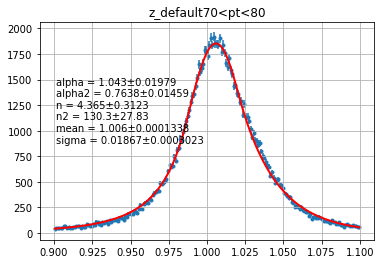

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.0, 1.0, 0.33880526226218954, 4.0, 1.004, 0.015)


FCN = 713.964470501 
 TOTAL NCALL = 321 
 NCALLS = 321 
 
 
 EDM = 2.33145448837e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.768104 
 0.00936882 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.604462 
 0.00703239 
 
 
 
 
 No 
 
 
 2 
 n 
 4.21535 
 0.126776 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.43208 
 0.198563 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0058 
 0.000151362 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.768104 & 0.00936882 & & & & & No\\
\hline
1 & alpha2 & 0.604462 & 0.00703239 & & & & & No\\
\hline
2 & n & 4.21535 & 0.126776 & & & & & No\\
\hline
3 & n2 & 5.43208 & 0.198563 & & & & & No\\
\hline
4 & mean & 1.0058 & 0.000151362 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 709.673464628 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 5.05394261534e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.768104 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.604462 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.21535 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 5.43208 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0058 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151667 
 5.73188e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.768104 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.604462 & 1 & & & & & Yes\\
\hline
2 & n & 4.21535 & 1 & & & & & Yes\\
\hline
3 & n2 & 5.43208 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0058 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151667 & 5.73188e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 376.998127687 
 TOTAL NCALL = 347 
 NCALLS = 347 
 
 
 EDM = 4.03796050081e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.27371 
 0.0199334 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.15942 
 0.0233102 
 
 
 
 
 No 
 
 
 2 
 n 
 2.84433 
 0.0950519 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.69745 
 0.107275 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00771 
 0.000128811 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0233034 
 0.000216156 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.27371 & 0.0199334 & & & & & No\\
\hline
1 & alpha2 & 1.15942 & 0.0233102 & & & & & No\\
\hline
2 & n & 2.84433 & 0.0950519 & & & & & No\\
\hline
3 & n2 & 2.69745 & 0.107275 & & & & & No\\
\hline
4 & mean & 1.00771 & 0.000128811 & & & & & No\\
\hline
5 & $\sigma$ & 0.0233034 & 0.000216156 & & & & & No\\
\hline
\end{tabular}

60<pt<70
24


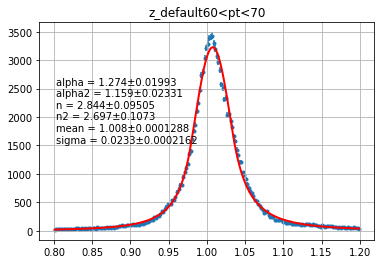

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.0, 1.0, -1.829385418337548, 4.0, 1.004, 0.015)


FCN = 496.965301192 
 TOTAL NCALL = 467 
 NCALLS = 467 
 
 
 EDM = 2.60142274304e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.670252 
 0.00866317 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.449929 
 0.00572631 
 
 
 
 
 No 
 
 
 2 
 n 
 5.36232 
 0.208342 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.99057 
 0.379609 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00384 
 0.000186722 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.670252 & 0.00866317 & & & & & No\\
\hline
1 & alpha2 & 0.449929 & 0.00572631 & & & & & No\\
\hline
2 & n & 5.36232 & 0.208342 & & & & & No\\
\hline
3 & n2 & 6.99057 & 0.379609 & & & & & No\\
\hline
4 & mean & 1.00384 & 0.000186722 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 495.788069107 
 TOTAL NCALL = 17 
 NCALLS = 17 
 
 
 EDM = 2.75775352365e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.670252 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.449929 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 5.36232 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 6.99057 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00384 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150882 
 5.76772e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.670252 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.449929 & 1 & & & & & Yes\\
\hline
2 & n & 5.36232 & 1 & & & & & Yes\\
\hline
3 & n2 & 6.99057 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00384 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150882 & 5.76772e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 281.423902172 
 TOTAL NCALL = 394 
 NCALLS = 394 
 
 
 EDM = 3.60552435449e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.21711 
 0.0273788 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.860048 
 0.0220951 
 
 
 
 
 No 
 
 
 2 
 n 
 3.35097 
 0.149069 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.84884 
 0.195895 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00626 
 0.000184607 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0248037 
 0.000350701 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.21711 & 0.0273788 & & & & & No\\
\hline
1 & alpha2 & 0.860048 & 0.0220951 & & & & & No\\
\hline
2 & n & 3.35097 & 0.149069 & & & & & No\\
\hline
3 & n2 & 3.84884 & 0.195895 & & & & & No\\
\hline
4 & mean & 1.00626 & 0.000184607 & & & & & No\\
\hline
5 & $\sigma$ & 0.0248037 & 0.000350701 & & & & & No\\
\hline
\end{tabular}

50<pt<60
25


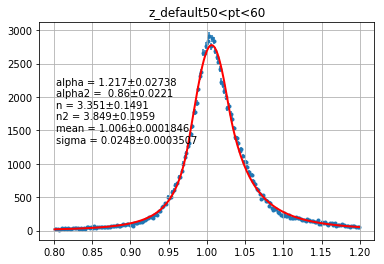

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.0, 1.0, -4.805414060768198, 4.0, 1.004, 0.015)


FCN = 998.336042767 
 TOTAL NCALL = 391 
 NCALLS = 391 
 
 
 EDM = 5.64499973586e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.617022 
 0.00759328 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.320207 
 0.00311024 
 
 
 
 
 No 
 
 
 2 
 n 
 3.61007 
 0.076561 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.88279 
 0.213464 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0011 
 0.000243537 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.617022 & 0.00759328 & & & & & No\\
\hline
1 & alpha2 & 0.320207 & 0.00311024 & & & & & No\\
\hline
2 & n & 3.61007 & 0.076561 & & & & & No\\
\hline
3 & n2 & 6.88279 & 0.213464 & & & & & No\\
\hline
4 & mean & 1.0011 & 0.000243537 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 997.699724221 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 4.89629168139e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.617022 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.320207 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.61007 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 6.88279 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0011 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150622 
 5.52174e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.617022 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.320207 & 1 & & & & & Yes\\
\hline
2 & n & 3.61007 & 1 & & & & & Yes\\
\hline
3 & n2 & 6.88279 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0011 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150622 & 5.52174e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 489.731503474 
 TOTAL NCALL = 429 
 NCALLS = 429 
 
 
 EDM = 9.10621474643e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.46428 
 0.0204408 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.96498 
 0.0195556 
 
 
 
 
 No 
 
 
 2 
 n 
 2.37169 
 0.0654364 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.40358 
 0.108626 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00988 
 0.000257849 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0359089 
 0.000362192 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.46428 & 0.0204408 & & & & & No\\
\hline
1 & alpha2 & 0.96498 & 0.0195556 & & & & & No\\
\hline
2 & n & 2.37169 & 0.0654364 & & & & & No\\
\hline
3 & n2 & 3.40358 & 0.108626 & & & & & No\\
\hline
4 & mean & 1.00988 & 0.000257849 & & & & & No\\
\hline
5 & $\sigma$ & 0.0359089 & 0.000362192 & & & & & No\\
\hline
\end{tabular}

40<pt<50
26


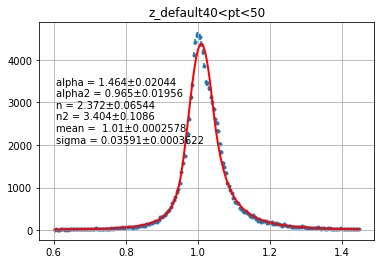

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.0, 1.0, -11.190917268121293, 4.0, 1.004, 0.015)


FCN = 604.607214186 
 TOTAL NCALL = 449 
 NCALLS = 449 
 
 
 EDM = 1.45822891614e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.269971 
 0.00269524 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.423091 
 0.00624617 
 
 
 
 
 No 
 
 
 2 
 n 
 16.6227 
 1.28694 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.74878 
 0.0587721 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03973 
 0.000332136 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.269971 & 0.00269524 & & & & & No\\
\hline
1 & alpha2 & 0.423091 & 0.00624617 & & & & & No\\
\hline
2 & n & 16.6227 & 1.28694 & & & & & No\\
\hline
3 & n2 & 2.74878 & 0.0587721 & & & & & No\\
\hline
4 & mean & 1.03973 & 0.000332136 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 604.546597481 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 5.91468803864e-12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.269971 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.423091 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 16.6227 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.74878 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.03973 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150193 
 5.55201e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.269971 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.423091 & 1 & & & & & Yes\\
\hline
2 & n & 16.6227 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.74878 & 1 & & & & & Yes\\
\hline
4 & mean & 1.03973 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150193 & 5.55201e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 356.530043376 
 TOTAL NCALL = 462 
 NCALLS = 462 
 
 
 EDM = 6.58814771742e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.812455 
 0.0205428 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.01319 
 0.0172204 
 
 
 
 
 No 
 
 
 2 
 n 
 7.18938 
 0.39014 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.24907 
 0.0549369 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03402 
 0.000306869 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0385556 
 0.000593033 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.812455 & 0.0205428 & & & & & No\\
\hline
1 & alpha2 & 1.01319 & 0.0172204 & & & & & No\\
\hline
2 & n & 7.18938 & 0.39014 & & & & & No\\
\hline
3 & n2 & 2.24907 & 0.0549369 & & & & & No\\
\hline
4 & mean & 1.03402 & 0.000306869 & & & & & No\\
\hline
5 & $\sigma$ & 0.0385556 & 0.000593033 & & & & & No\\
\hline
\end{tabular}

30<pt<40
27


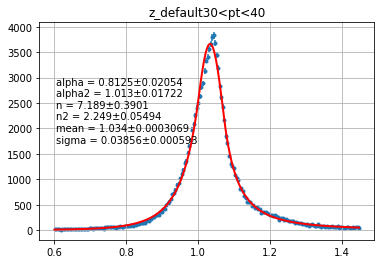

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:95: SmallIntegralWarning: (1.0, 1.0, -0.20754621001894158, 4.0, 1.004, 0.015)


FCN = 654.74690604 
 TOTAL NCALL = 437 
 NCALLS = 437 
 
 
 EDM = 4.07128286476e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.291073 
 0.00327739 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.258204 
 0.00314976 
 
 
 
 
 No 
 
 
 2 
 n 
 6.02598 
 0.175172 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.45098 
 0.0643086 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03269 
 0.000434122 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.291073 & 0.00327739 & & & & & No\\
\hline
1 & alpha2 & 0.258204 & 0.00314976 & & & & & No\\
\hline
2 & n & 6.02598 & 0.175172 & & & & & No\\
\hline
3 & n2 & 3.45098 & 0.0643086 & & & & & No\\
\hline
4 & mean & 1.03269 & 0.000434122 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 654.724008123 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 7.64262319681e-12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.291073 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.258204 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 6.02598 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.45098 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.03269 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150123 
 5.74387e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.291073 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.258204 & 1 & & & & & Yes\\
\hline
2 & n & 6.02598 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.45098 & 1 & & & & & Yes\\
\hline
4 & mean & 1.03269 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150123 & 5.74387e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 224.090611288 
 TOTAL NCALL = 385 
 NCALLS = 385 
 
 
 EDM = 6.35604696471e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08552 
 0.0195769 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.879253 
 0.0146278 
 
 
 
 
 No 
 
 
 2 
 n 
 3.75044 
 0.112197 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.68091 
 0.0556431 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03462 
 0.00031679 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0503869 
 0.000604325 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08552 & 0.0195769 & & & & & No\\
\hline
1 & alpha2 & 0.879253 & 0.0146278 & & & & & No\\
\hline
2 & n & 3.75044 & 0.112197 & & & & & No\\
\hline
3 & n2 & 2.68091 & 0.0556431 & & & & & No\\
\hline
4 & mean & 1.03462 & 0.00031679 & & & & & No\\
\hline
5 & $\sigma$ & 0.0503869 & 0.000604325 & & & & & No\\
\hline
\end{tabular}

FCN = 224.090607529 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 2.30779397459e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08552 
 0.0104226 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.879257 
 0.0081917 
 
 
 
 
 No 
 
 
 2 
 n 
 3.75045 
 0.0970067 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.68094 
 0.0485472 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03462 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0503869 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08552 & 0.0104226 & & & & & No\\
\hline
1 & alpha2 & 0.879257 & 0.0081917 & & & & & No\\
\hline
2 & n & 3.75045 & 0.0970067 & & & & & No\\
\hline
3 & n2 & 2.68094 & 0.0485472 & & & & & No\\
\hline
4 & mean & 1.03462 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0503869 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 224.090606691 
 TOTAL NCALL = 94 
 NCALLS = 94 
 
 
 EDM = 1.76000977446e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08552 
 0.0195757 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.879257 
 0.0146289 
 
 
 
 
 No 
 
 
 2 
 n 
 3.75049 
 0.112194 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.68094 
 0.0556489 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03462 
 0.000316802 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0503871 
 0.000604326 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08552 & 0.0195757 & & & & & No\\
\hline
1 & alpha2 & 0.879257 & 0.0146289 & & & & & No\\
\hline
2 & n & 3.75049 & 0.112194 & & & & & No\\
\hline
3 & n2 & 2.68094 & 0.0556489 & & & & & No\\
\hline
4 & mean & 1.03462 & 0.000316802 & & & & & No\\
\hline
5 & $\sigma$ & 0.0503871 & 0.000604326 & & & & & No\\
\hline
\end{tabular}

20<pt<30
28


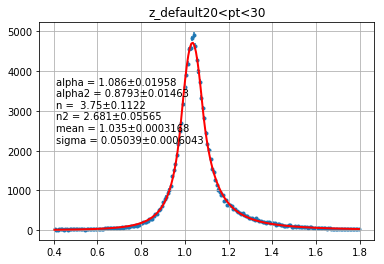

In [34]:
tipe='z_default'
i=0
for para in feat_pt:
  
    if i>23:
        if i>25 and i!=28:
            rmin=0.6
            rmax=1.45
        elif i==28:
            rmin=0.4
            rmax=1.8
        else:
            rmin=0.8
            rmax=1.2
    
        
    else:
        rmin = 0.9
        rmax = 1.1
    
    df=data.query(para).astype('double')
    df=df[tipe]
    bound_DCB=[rmin, rmax]
    normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(5):
        #first step
        if j==0: 
            pars_dcb = dict(mean  = 1.004, 
                        fix_mean = False,
                        sigma  = 0.015,
                        fix_sigma = True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
        
        elif j==1:
                pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = True,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = True
                        )
                
        elif j==3:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = True,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
                
        #optimize parameter withoptimized start parameter
        else:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
        minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
        minuit.migrad() #optimized parameter
        if i!=7 and i !=9 and i!=22 and i!=28:
            if j==2:
                break
            else:
                pass
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
    binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    if tipe=='target':
        mean_pt_un[i]=minuit.values['mean']
        mean_err_pt_un[i]=minuit.errors['mean']
        sigma_pt_un[i]=minuit.values['sigma']
        sigma_err_pt_un[i]=minuit.errors['sigma']
    if tipe=='z_default':
        mean_pt_de[i]=minuit.values['mean']
        mean_err_pt_de[i]=minuit.errors['mean']
        sigma_pt_de[i]=minuit.values['sigma']
        sigma_err_pt_de[i]=minuit.errors['sigma']       
    if tipe=='z_bo':
        mean_pt_bo[i]=minuit.values['mean']
        mean_err_pt_bo[i]=minuit.errors['mean']
        sigma_pt_bo[i]=minuit.values['sigma']
        sigma_err_pt_bo[i]=minuit.errors['sigma'] 
    print(para)
    print(i)
    i+=1
    if i==29:
        i=0
        
    plt.title(tipe+para)
    plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
    plt.show()
np.savetxt('pt_parameter_uncorrected.csv', (mean_pt_de,sigma_pt_de), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.4980826803366547, 2.151948894762791, -0.6542714700333789, 6.8944670973113995, 1.0151428525038804, 0.015)


FCN = 1322.91071663 
 TOTAL NCALL = 484 
 NCALLS = 484 
 
 
 EDM = 4.89616544175e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.10499 
 0.0703206 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.60808 
 0.113556 
 
 
 
 
 No 
 
 
 2 
 n 
 1.22133 
 0.18679 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.94861 
 0.350198 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01578 
 0.000179186 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.10499 & 0.0703206 & & & & & No\\
\hline
1 & alpha2 & 2.60808 & 0.113556 & & & & & No\\
\hline
2 & n & 1.22133 & 0.18679 & & & & & No\\
\hline
3 & n2 & 0.94861 & 0.350198 & & & & & No\\
\hline
4 & mean & 1.01578 & 0.000179186 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 331.083850372 
 TOTAL NCALL = 30 
 NCALLS = 30 
 
 
 EDM = 7.61940767566e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.10499 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.60808 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.22133 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 0.94861 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01578 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.00893177 
 9.59132e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.10499 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.60808 & 1 & & & & & Yes\\
\hline
2 & n & 1.22133 & 1 & & & & & Yes\\
\hline
3 & n2 & 0.94861 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01578 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.00893177 & 9.59132e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 171.706545292 
 TOTAL NCALL = 861 
 NCALLS = 861 
 
 
 EDM = 7.61753662844e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.95076 
 0.0655446 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.26769 
 0.0706668 
 
 
 
 
 No 
 
 
 2 
 n 
 1.09143 
 0.104237 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.38264 
 0.606586 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0152 
 0.000132931 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00755155 
 0.000144689 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.95076 & 0.0655446 & & & & & No\\
\hline
1 & alpha2 & 1.26769 & 0.0706668 & & & & & No\\
\hline
2 & n & 1.09143 & 0.104237 & & & & & No\\
\hline
3 & n2 & 4.38264 & 0.606586 & & & & & No\\
\hline
4 & mean & 1.0152 & 0.000132931 & & & & & No\\
\hline
5 & $\sigma$ & 0.00755155 & 0.000144689 & & & & & No\\
\hline
\end{tabular}

300<pt<310
0


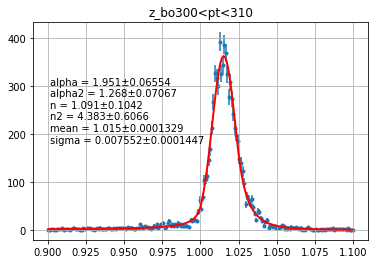

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (2.0236771439326144, 2.576832012375736, -2.567849851222089, 7.3428167959574555, 1.0085727021417914, 0.015)


FCN = 10040.2559998 
 TOTAL NCALL = 455 
 NCALLS = 444 
 
 
 EDM = 1636.41065184 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.75137 
 0.0154923 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.6919 
 0.385606 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00284 
 7.58367e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.21204 
 2.92371 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00861 
 4.68754e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.75137 & 0.0154923 & & & & & No\\
\hline
1 & alpha2 & 2.6919 & 0.385606 & & & & & No\\
\hline
2 & n & 1.00284 & 7.58367e-06 & & & & & No\\
\hline
3 & n2 & 2.21204 & 2.92371 & & & & & No\\
\hline
4 & mean & 1.00861 & 4.68754e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2314.08396489 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 5.94932436026e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.75137 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.6919 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00284 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.21204 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00861 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0104068 
 2.88963e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.75137 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.6919 & 1 & & & & & Yes\\
\hline
2 & n & 1.00284 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.21204 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00861 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0104068 & 2.88963e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 258.32651286 
 TOTAL NCALL = 484 
 NCALLS = 484 
 
 
 EDM = 8.66468346526e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.49139 
 0.0247568 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.42125 
 0.0260803 
 
 
 
 
 No 
 
 
 2 
 n 
 3.79143 
 0.148565 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.47675 
 0.299751 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0084 
 3.98729e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00855338 
 5.80011e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.49139 & 0.0247568 & & & & & No\\
\hline
1 & alpha2 & 1.42125 & 0.0260803 & & & & & No\\
\hline
2 & n & 3.79143 & 0.148565 & & & & & No\\
\hline
3 & n2 & 5.47675 & 0.299751 & & & & & No\\
\hline
4 & mean & 1.0084 & 3.98729e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00855338 & 5.80011e-05 & & & & & No\\
\hline
\end{tabular}

290<pt<300
1


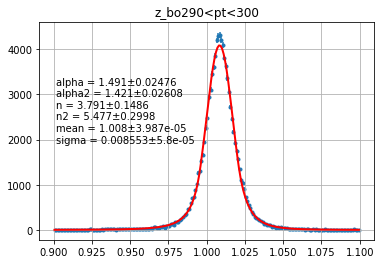

FCN = 7725.27943152 
 TOTAL NCALL = 431 
 NCALLS = 431 
 
 
 EDM = 3.94423120959e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.124 
 0.0234644 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.63911 
 0.0390118 
 
 
 
 
 No 
 
 
 2 
 n 
 1.64336 
 0.084479 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.44368 
 0.151548 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00674 
 4.78854e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.124 & 0.0234644 & & & & & No\\
\hline
1 & alpha2 & 2.63911 & 0.0390118 & & & & & No\\
\hline
2 & n & 1.64336 & 0.084479 & & & & & No\\
\hline
3 & n2 & 1.44368 & 0.151548 & & & & & No\\
\hline
4 & mean & 1.00674 & 4.78854e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (2.1239965695519607, 2.6391096158469893, 1.6433602200871302, 1.4436783947995637, 1.006736120481595, -0.04569545510063198)


FCN = 1997.8154294 
 TOTAL NCALL = 29 
 NCALLS = 29 
 
 
 EDM = 1.55811586759e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.124 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.63911 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.64336 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.44368 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00674 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0109853 
 3.05056e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.124 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.63911 & 1 & & & & & Yes\\
\hline
2 & n & 1.64336 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.44368 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00674 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0109853 & 3.05056e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 211.753370758 
 TOTAL NCALL = 323 
 NCALLS = 323 
 
 
 EDM = 8.66167727019e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24921 
 0.0179278 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.52161 
 0.0261771 
 
 
 
 
 No 
 
 
 2 
 n 
 3.55243 
 0.108669 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.58982 
 0.227125 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00761 
 4.1924e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00901807 
 5.90721e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24921 & 0.0179278 & & & & & No\\
\hline
1 & alpha2 & 1.52161 & 0.0261771 & & & & & No\\
\hline
2 & n & 3.55243 & 0.108669 & & & & & No\\
\hline
3 & n2 & 4.58982 & 0.227125 & & & & & No\\
\hline
4 & mean & 1.00761 & 4.1924e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00901807 & 5.90721e-05 & & & & & No\\
\hline
\end{tabular}

280<pt<290
2


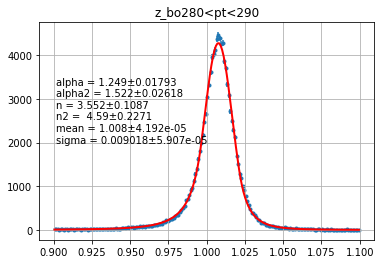

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (2.067514116248919, 2.171974751837672, 0.9364408549869008, 7.640284936151623, 1.0066896081305419, 0.015)


FCN = 7188.32662076 
 TOTAL NCALL = 374 
 NCALLS = 374 
 
 
 EDM = 1.37161575841e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.01885 
 0.0203674 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.61569 
 0.0388014 
 
 
 
 
 No 
 
 
 2 
 n 
 1.36636 
 0.0607301 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.43849 
 0.148361 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00655 
 4.8208e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.01885 & 0.0203674 & & & & & No\\
\hline
1 & alpha2 & 2.61569 & 0.0388014 & & & & & No\\
\hline
2 & n & 1.36636 & 0.0607301 & & & & & No\\
\hline
3 & n2 & 1.43849 & 0.148361 & & & & & No\\
\hline
4 & mean & 1.00655 & 4.8208e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1975.41770706 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 2.51254293913e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.01885 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.61569 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.36636 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.43849 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00655 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0110524 
 3.18956e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.01885 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.61569 & 1 & & & & & Yes\\
\hline
2 & n & 1.36636 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.43849 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00655 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0110524 & 3.18956e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 183.042295366 
 TOTAL NCALL = 283 
 NCALLS = 283 
 
 
 EDM = 1.82601069857e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26796 
 0.0166049 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.51301 
 0.0249906 
 
 
 
 
 No 
 
 
 2 
 n 
 2.70062 
 0.0696979 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.48337 
 0.21459 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0075 
 4.1728e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00909501 
 5.68077e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26796 & 0.0166049 & & & & & No\\
\hline
1 & alpha2 & 1.51301 & 0.0249906 & & & & & No\\
\hline
2 & n & 2.70062 & 0.0696979 & & & & & No\\
\hline
3 & n2 & 4.48337 & 0.21459 & & & & & No\\
\hline
4 & mean & 1.0075 & 4.1728e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00909501 & 5.68077e-05 & & & & & No\\
\hline
\end{tabular}

270<pt<280
3


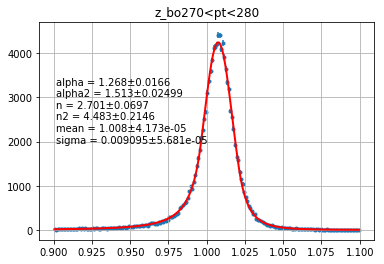

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.9703056246957968, 2.4075029359286315, 0.34901329792807356, 8.353412257414304, 1.0063983480370207, 0.015)


FCN = 6865.75792119 
 TOTAL NCALL = 634 
 NCALLS = 623 
 
 
 EDM = 4.39434806643e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.14966 
 0.00818401 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.59238 
 0.0352179 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00108 
 1.42848e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.30228 
 0.124002 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00644 
 4.78874e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.14966 & 0.00818401 & & & & & No\\
\hline
1 & alpha2 & 2.59238 & 0.0352179 & & & & & No\\
\hline
2 & n & 1.00108 & 1.42848e-06 & & & & & No\\
\hline
3 & n2 & 1.30228 & 0.124002 & & & & & No\\
\hline
4 & mean & 1.00644 & 4.78874e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1735.17450052 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 1.34892101265e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.14966 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.59238 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00108 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.30228 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00644 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0110674 
 3.20678e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.14966 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.59238 & 1 & & & & & Yes\\
\hline
2 & n & 1.00108 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.30228 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00644 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0110674 & 3.20678e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 257.106230631 
 TOTAL NCALL = 353 
 NCALLS = 353 
 
 
 EDM = 5.62663018046e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38011 
 0.0171809 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.59283 
 0.0231907 
 
 
 
 
 No 
 
 
 2 
 n 
 2.33142 
 0.0586287 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.82629 
 0.141683 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00726 
 4.02462e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00939338 
 5.07665e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38011 & 0.0171809 & & & & & No\\
\hline
1 & alpha2 & 1.59283 & 0.0231907 & & & & & No\\
\hline
2 & n & 2.33142 & 0.0586287 & & & & & No\\
\hline
3 & n2 & 3.82629 & 0.141683 & & & & & No\\
\hline
4 & mean & 1.00726 & 4.02462e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00939338 & 5.07665e-05 & & & & & No\\
\hline
\end{tabular}

260<pt<270
4


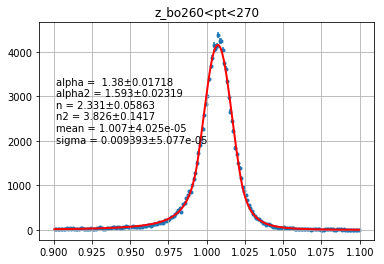

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.315621207452366, 2.1556972010012454, -1.9506682137574387, 8.23238874184578, 1.006626983816969, 0.015)


FCN = 6206.48161935 
 TOTAL NCALL = 415 
 NCALLS = 415 
 
 
 EDM = 4.04654763437e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.06661 
 0.0200005 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.62723 
 0.040557 
 
 
 
 
 No 
 
 
 2 
 n 
 1.04874 
 0.0476413 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.33825 
 0.144872 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00628 
 4.84109e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.06661 & 0.0200005 & & & & & No\\
\hline
1 & alpha2 & 2.62723 & 0.040557 & & & & & No\\
\hline
2 & n & 1.04874 & 0.0476413 & & & & & No\\
\hline
3 & n2 & 1.33825 & 0.144872 & & & & & No\\
\hline
4 & mean & 1.00628 & 4.84109e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1711.50368675 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 3.66595904089e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.06661 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.62723 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.04874 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.33825 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00628 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0112959 
 3.27284e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.06661 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.62723 & 1 & & & & & Yes\\
\hline
2 & n & 1.04874 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.33825 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00628 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0112959 & 3.27284e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 246.225796423 
 TOTAL NCALL = 335 
 NCALLS = 335 
 
 
 EDM = 6.70776125591e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.32977 
 0.0175573 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.48238 
 0.0253345 
 
 
 
 
 No 
 
 
 2 
 n 
 2.31036 
 0.0591613 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.89567 
 0.249654 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00711 
 4.28434e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00938162 
 6.0382e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.32977 & 0.0175573 & & & & & No\\
\hline
1 & alpha2 & 1.48238 & 0.0253345 & & & & & No\\
\hline
2 & n & 2.31036 & 0.0591613 & & & & & No\\
\hline
3 & n2 & 4.89567 & 0.249654 & & & & & No\\
\hline
4 & mean & 1.00711 & 4.28434e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00938162 & 6.0382e-05 & & & & & No\\
\hline
\end{tabular}

250<pt<260
5


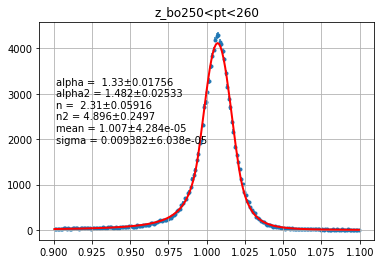

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.349807835116029, 2.2905392134419498, -2.1320588163907725, 8.57745520977812, 1.0069742364452217, 0.015)


FCN = 5799.13355517 
 TOTAL NCALL = 409 
 NCALLS = 409 
 
 
 EDM = 6.427918439e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.09631 
 0.0212623 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.56392 
 0.0393176 
 
 
 
 
 No 
 
 
 2 
 n 
 1.08938 
 0.0521284 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.60246 
 0.160901 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00621 
 4.8061e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.09631 & 0.0212623 & & & & & No\\
\hline
1 & alpha2 & 2.56392 & 0.0393176 & & & & & No\\
\hline
2 & n & 1.08938 & 0.0521284 & & & & & No\\
\hline
3 & n2 & 1.60246 & 0.160901 & & & & & No\\
\hline
4 & mean & 1.00621 & 4.8061e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1719.92247538 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 6.78281477204e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.09631 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.56392 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.08938 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.60246 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00621 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0114962 
 3.27744e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.09631 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.56392 & 1 & & & & & Yes\\
\hline
2 & n & 1.08938 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.60246 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00621 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0114962 & 3.27744e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 220.090753558 
 TOTAL NCALL = 339 
 NCALLS = 339 
 
 
 EDM = 1.60076671864e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.31955 
 0.0178543 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.48623 
 0.0254711 
 
 
 
 
 No 
 
 
 2 
 n 
 2.53257 
 0.0680452 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.01213 
 0.263304 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00702 
 4.34231e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00957691 
 6.11586e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.31955 & 0.0178543 & & & & & No\\
\hline
1 & alpha2 & 1.48623 & 0.0254711 & & & & & No\\
\hline
2 & n & 2.53257 & 0.0680452 & & & & & No\\
\hline
3 & n2 & 5.01213 & 0.263304 & & & & & No\\
\hline
4 & mean & 1.00702 & 4.34231e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00957691 & 6.11586e-05 & & & & & No\\
\hline
\end{tabular}

240<pt<250
6


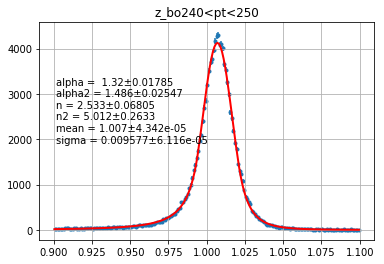

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.3090711785415567, 2.107506443430818, -2.1055572695264075, 8.121635091957572, 1.006707525726308, 0.015)


FCN = 5425.51319872 
 TOTAL NCALL = 919 
 NCALLS = 919 
 
 
 EDM = 1.58201686178e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.05849 
 0.0206809 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.55099 
 0.0378809 
 
 
 
 
 No 
 
 
 2 
 n 
 1.06081 
 0.0490452 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.42456 
 0.138941 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00634 
 4.8744e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.05849 & 0.0206809 & & & & & No\\
\hline
1 & alpha2 & 2.55099 & 0.0378809 & & & & & No\\
\hline
2 & n & 1.06081 & 0.0490452 & & & & & No\\
\hline
3 & n2 & 1.42456 & 0.138941 & & & & & No\\
\hline
4 & mean & 1.00634 & 4.8744e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1627.64655925 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 1.05216819645e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.05849 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.55099 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.06081 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.42456 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00634 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0115267 
 3.38617e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.05849 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.55099 & 1 & & & & & Yes\\
\hline
2 & n & 1.06081 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.42456 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00634 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0115267 & 3.38617e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 207.263478388 
 TOTAL NCALL = 301 
 NCALLS = 301 
 
 
 EDM = 1.46086131093e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35868 
 0.0177428 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.42655 
 0.0239957 
 
 
 
 
 No 
 
 
 2 
 n 
 2.24927 
 0.0585795 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.10801 
 0.259856 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00696 
 4.35949e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00959119 
 6.14137e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35868 & 0.0177428 & & & & & No\\
\hline
1 & alpha2 & 1.42655 & 0.0239957 & & & & & No\\
\hline
2 & n & 2.24927 & 0.0585795 & & & & & No\\
\hline
3 & n2 & 5.10801 & 0.259856 & & & & & No\\
\hline
4 & mean & 1.00696 & 4.35949e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00959119 & 6.14137e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 207.263471853 
 TOTAL NCALL = 56 
 NCALLS = 56 
 
 
 EDM = 6.84166646843e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35869 
 0.0128666 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.42656 
 0.0163224 
 
 
 
 
 No 
 
 
 2 
 n 
 2.24929 
 0.0518223 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.10811 
 0.230391 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00696 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.00959119 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35869 & 0.0128666 & & & & & No\\
\hline
1 & alpha2 & 1.42656 & 0.0163224 & & & & & No\\
\hline
2 & n & 2.24929 & 0.0518223 & & & & & No\\
\hline
3 & n2 & 5.10811 & 0.230391 & & & & & No\\
\hline
4 & mean & 1.00696 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.00959119 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 207.263471853 
 TOTAL NCALL = 88 
 NCALLS = 88 
 
 
 EDM = 8.06127275847e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.35869 
 0.0174986 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.42656 
 0.0236773 
 
 
 
 
 No 
 
 
 2 
 n 
 2.24929 
 0.0583403 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.10811 
 0.259314 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00696 
 4.35593e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00959119 
 5.96667e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.35869 & 0.0174986 & & & & & No\\
\hline
1 & alpha2 & 1.42656 & 0.0236773 & & & & & No\\
\hline
2 & n & 2.24929 & 0.0583403 & & & & & No\\
\hline
3 & n2 & 5.10811 & 0.259314 & & & & & No\\
\hline
4 & mean & 1.00696 & 4.35593e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00959119 & 5.96667e-05 & & & & & No\\
\hline
\end{tabular}

230<pt<240
7


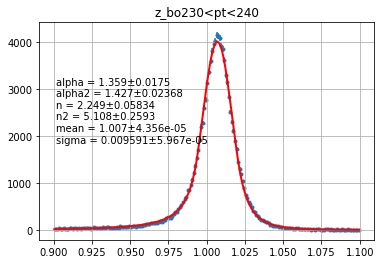

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.3007725948043438, 2.099890932308928, -1.492869489332147, 8.08705398752687, 1.0068976732962516, 0.015)


FCN = 5041.64981624 
 TOTAL NCALL = 428 
 NCALLS = 428 
 
 
 EDM = 4.42545410319e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.03063 
 0.0199853 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.57215 
 0.0398312 
 
 
 
 
 No 
 
 
 2 
 n 
 1.12385 
 0.0498224 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.29765 
 0.134575 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00645 
 4.84766e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.03063 & 0.0199853 & & & & & No\\
\hline
1 & alpha2 & 2.57215 & 0.0398312 & & & & & No\\
\hline
2 & n & 1.12385 & 0.0498224 & & & & & No\\
\hline
3 & n2 & 1.29765 & 0.134575 & & & & & No\\
\hline
4 & mean & 1.00645 & 4.84766e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1622.48522943 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 1.4541760265e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.03063 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.57215 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.12385 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.29765 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00645 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0117196 
 3.40607e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.03063 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.57215 & 1 & & & & & Yes\\
\hline
2 & n & 1.12385 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.29765 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00645 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0117196 & 3.40607e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 253.095244038 
 TOTAL NCALL = 297 
 NCALLS = 297 
 
 
 EDM = 6.30615295517e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.32333 
 0.0174013 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.44234 
 0.0243579 
 
 
 
 
 No 
 
 
 2 
 n 
 2.39183 
 0.062597 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.98708 
 0.25336 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00713 
 4.42362e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00974467 
 6.26839e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.32333 & 0.0174013 & & & & & No\\
\hline
1 & alpha2 & 1.44234 & 0.0243579 & & & & & No\\
\hline
2 & n & 2.39183 & 0.062597 & & & & & No\\
\hline
3 & n2 & 4.98708 & 0.25336 & & & & & No\\
\hline
4 & mean & 1.00713 & 4.42362e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.00974467 & 6.26839e-05 & & & & & No\\
\hline
\end{tabular}

220<pt<230
8


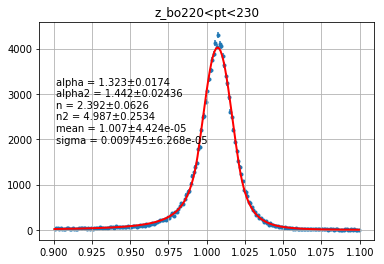

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.341761871864162, 2.1562963258187993, -4.176153691499314, 8.229344896264859, 1.0075747792511074, 0.015)


FCN = 4556.70361704 
 TOTAL NCALL = 686 
 NCALLS = 686 
 
 
 EDM = 4.63064109364e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.06104 
 0.0193855 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.42896 
 0.0360241 
 
 
 
 
 No 
 
 
 2 
 n 
 1.04731 
 0.0460326 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.67381 
 0.149401 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00683 
 4.85679e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.06104 & 0.0193855 & & & & & No\\
\hline
1 & alpha2 & 2.42896 & 0.0360241 & & & & & No\\
\hline
2 & n & 1.04731 & 0.0460326 & & & & & No\\
\hline
3 & n2 & 1.67381 & 0.149401 & & & & & No\\
\hline
4 & mean & 1.00683 & 4.85679e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1435.58050081 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 4.37754820458e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.06104 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.42896 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.04731 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.67381 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00683 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0118375 
 3.48073e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.06104 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.42896 & 1 & & & & & Yes\\
\hline
2 & n & 1.04731 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.67381 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00683 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0118375 & 3.48073e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 219.148149396 
 TOTAL NCALL = 312 
 NCALLS = 312 
 
 
 EDM = 2.31041067868e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.42411 
 0.0190028 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.41065 
 0.0245118 
 
 
 
 
 No 
 
 
 2 
 n 
 2.12123 
 0.0588109 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.2598 
 0.284084 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00723 
 4.49288e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0100329 
 6.40832e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.42411 & 0.0190028 & & & & & No\\
\hline
1 & alpha2 & 1.41065 & 0.0245118 & & & & & No\\
\hline
2 & n & 2.12123 & 0.0588109 & & & & & No\\
\hline
3 & n2 & 5.2598 & 0.284084 & & & & & No\\
\hline
4 & mean & 1.00723 & 4.49288e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0100329 & 6.40832e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 219.148149354 
 TOTAL NCALL = 56 
 NCALLS = 56 
 
 
 EDM = 1.09899766122e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.42411 
 0.0137014 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.41065 
 0.0163731 
 
 
 
 
 No 
 
 
 2 
 n 
 2.12123 
 0.0512146 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.2598 
 0.248533 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00723 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0100329 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.42411 & 0.0137014 & & & & & No\\
\hline
1 & alpha2 & 1.41065 & 0.0163731 & & & & & No\\
\hline
2 & n & 2.12123 & 0.0512146 & & & & & No\\
\hline
3 & n2 & 5.2598 & 0.248533 & & & & & No\\
\hline
4 & mean & 1.00723 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0100329 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 219.14814935 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 1.85015807661e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.42411 
 0.0190029 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.41065 
 0.0245114 
 
 
 
 
 No 
 
 
 2 
 n 
 2.12123 
 0.0588114 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.2598 
 0.284078 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00723 
 4.49286e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0100329 
 6.40829e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.42411 & 0.0190029 & & & & & No\\
\hline
1 & alpha2 & 1.41065 & 0.0245114 & & & & & No\\
\hline
2 & n & 2.12123 & 0.0588114 & & & & & No\\
\hline
3 & n2 & 5.2598 & 0.284078 & & & & & No\\
\hline
4 & mean & 1.00723 & 4.49286e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0100329 & 6.40829e-05 & & & & & No\\
\hline
\end{tabular}

210<pt<220
9


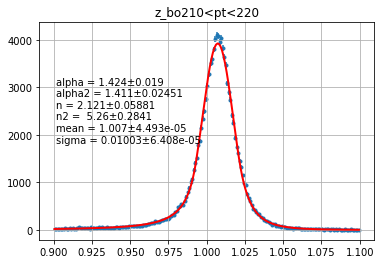

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.603613083653265, 2.149170688174836, -1.2144685611909232, 8.06786847975376, 1.0083226593022474, 0.015)


FCN = 4010.89357784 
 TOTAL NCALL = 250 
 NCALLS = 239 
 
 
 EDM = 38305.3237223 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.05591 
 0.00549267 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.96789 
 0.190487 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00022 
 1.56252e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.77525 
 10.6407 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00714 
 5.45226e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.05591 & 0.00549267 & & & & & No\\
\hline
1 & alpha2 & 1.96789 & 0.190487 & & & & & No\\
\hline
2 & n & 1.00022 & 1.56252e-06 & & & & & No\\
\hline
3 & n2 & 6.77525 & 10.6407 & & & & & No\\
\hline
4 & mean & 1.00714 & 5.45226e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1624.55727646 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 4.15955932515e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.05591 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.96789 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00022 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 6.77525 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00714 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0122204 
 3.54408e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.05591 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.96789 & 1 & & & & & Yes\\
\hline
2 & n & 1.00022 & 1 & & & & & Yes\\
\hline
3 & n2 & 6.77525 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00714 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0122204 & 3.54408e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 208.857163785 
 TOTAL NCALL = 451 
 NCALLS = 451 
 
 
 EDM = 2.90196467659e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38224 
 0.0185275 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.38519 
 0.023655 
 
 
 
 
 No 
 
 
 2 
 n 
 2.19801 
 0.06037 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.32005 
 0.284765 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00748 
 4.63708e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0101774 
 6.62108e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38224 & 0.0185275 & & & & & No\\
\hline
1 & alpha2 & 1.38519 & 0.023655 & & & & & No\\
\hline
2 & n & 2.19801 & 0.06037 & & & & & No\\
\hline
3 & n2 & 5.32005 & 0.284765 & & & & & No\\
\hline
4 & mean & 1.00748 & 4.63708e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0101774 & 6.62108e-05 & & & & & No\\
\hline
\end{tabular}

200<pt<210
10


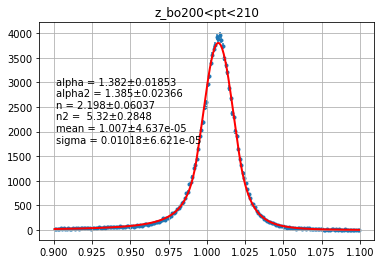

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.2919991294997866, 1.972195237269891, -0.47401400036942576, 7.843352188780168, 1.0082969208501809, 0.015)


FCN = 3201.06455039 
 TOTAL NCALL = 400 
 NCALLS = 400 
 
 
 EDM = 1.6034596154e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.9979 
 0.0197658 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.23273 
 0.0327782 
 
 
 
 
 No 
 
 
 2 
 n 
 1.15611 
 0.0497684 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.13602 
 0.167219 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0076 
 4.97519e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.9979 & 0.0197658 & & & & & No\\
\hline
1 & alpha2 & 2.23273 & 0.0327782 & & & & & No\\
\hline
2 & n & 1.15611 & 0.0497684 & & & & & No\\
\hline
3 & n2 & 2.13602 & 0.167219 & & & & & No\\
\hline
4 & mean & 1.0076 & 4.97519e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1284.94638928 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.61092820794e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.9979 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.23273 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.15611 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.13602 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0076 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0124339 
 3.71265e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.9979 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.23273 & 1 & & & & & Yes\\
\hline
2 & n & 1.15611 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.13602 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0076 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0124339 & 3.71265e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 193.728436979 
 TOTAL NCALL = 313 
 NCALLS = 313 
 
 
 EDM = 3.67321783237e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38722 
 0.018623 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.27175 
 0.022026 
 
 
 
 
 No 
 
 
 2 
 n 
 2.23791 
 0.0624476 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.62135 
 0.397645 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00775 
 4.83612e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0103689 
 7.03835e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38722 & 0.018623 & & & & & No\\
\hline
1 & alpha2 & 1.27175 & 0.022026 & & & & & No\\
\hline
2 & n & 2.23791 & 0.0624476 & & & & & No\\
\hline
3 & n2 & 6.62135 & 0.397645 & & & & & No\\
\hline
4 & mean & 1.00775 & 4.83612e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0103689 & 7.03835e-05 & & & & & No\\
\hline
\end{tabular}

190<pt<200
11


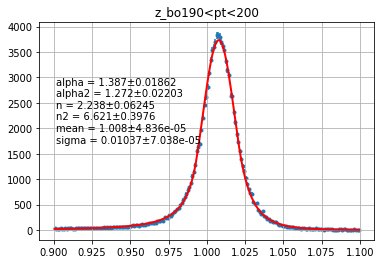

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (2.0627207218486743, 1.8604600247120568, 0.9564538691638065, 5.558644350742752, 1.007858225800117, 0.015)


FCN = 2535.22616172 
 TOTAL NCALL = 436 
 NCALLS = 436 
 
 
 EDM = 8.68774448912e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.98412 
 0.0200588 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.20273 
 0.029786 
 
 
 
 
 No 
 
 
 2 
 n 
 1.14784 
 0.0497949 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.97383 
 0.141905 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00795 
 5.00281e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.98412 & 0.0200588 & & & & & No\\
\hline
1 & alpha2 & 2.20273 & 0.029786 & & & & & No\\
\hline
2 & n & 1.14784 & 0.0497949 & & & & & No\\
\hline
3 & n2 & 1.97383 & 0.141905 & & & & & No\\
\hline
4 & mean & 1.00795 & 5.00281e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1081.24167564 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 6.1372914619e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.98412 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.20273 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.14784 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.97383 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00795 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0127388 
 3.81074e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.98412 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.20273 & 1 & & & & & Yes\\
\hline
2 & n & 1.14784 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.97383 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00795 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0127388 & 3.81074e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 249.943720616 
 TOTAL NCALL = 296 
 NCALLS = 296 
 
 
 EDM = 1.11800379035e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.39164 
 0.0193795 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.30244 
 0.0240476 
 
 
 
 
 No 
 
 
 2 
 n 
 2.2516 
 0.065751 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.08151 
 0.370152 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00811 
 5.04511e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0107772 
 7.5763e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.39164 & 0.0193795 & & & & & No\\
\hline
1 & alpha2 & 1.30244 & 0.0240476 & & & & & No\\
\hline
2 & n & 2.2516 & 0.065751 & & & & & No\\
\hline
3 & n2 & 6.08151 & 0.370152 & & & & & No\\
\hline
4 & mean & 1.00811 & 5.04511e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0107772 & 7.5763e-05 & & & & & No\\
\hline
\end{tabular}

180<pt<190
12


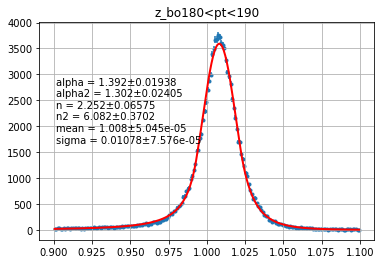

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.5520584345341133, 1.9128248559586014, -0.2727749766601324, 7.462617967563679, 1.0090927924801045, 0.015)


FCN = 2080.37836303 
 TOTAL NCALL = 381 
 NCALLS = 381 
 
 
 EDM = 3.36207793084e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.92295 
 0.0197831 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.11458 
 0.0307783 
 
 
 
 
 No 
 
 
 2 
 n 
 1.27091 
 0.052873 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.25061 
 0.163311 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00813 
 5.11476e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.92295 & 0.0197831 & & & & & No\\
\hline
1 & alpha2 & 2.11458 & 0.0307783 & & & & & No\\
\hline
2 & n & 1.27091 & 0.052873 & & & & & No\\
\hline
3 & n2 & 2.25061 & 0.163311 & & & & & No\\
\hline
4 & mean & 1.00813 & 5.11476e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1016.05651274 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.38289030016e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.92295 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.11458 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.27091 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.25061 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00813 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0130286 
 3.94056e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.92295 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.11458 & 1 & & & & & Yes\\
\hline
2 & n & 1.27091 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.25061 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00813 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0130286 & 3.94056e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 238.83323641 
 TOTAL NCALL = 285 
 NCALLS = 285 
 
 
 EDM = 6.88716022907e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.34626 
 0.0199079 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.26059 
 0.0252036 
 
 
 
 
 No 
 
 
 2 
 n 
 2.40668 
 0.0724293 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.64781 
 0.446701 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00827 
 5.31074e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109563 
 8.55336e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.34626 & 0.0199079 & & & & & No\\
\hline
1 & alpha2 & 1.26059 & 0.0252036 & & & & & No\\
\hline
2 & n & 2.40668 & 0.0724293 & & & & & No\\
\hline
3 & n2 & 6.64781 & 0.446701 & & & & & No\\
\hline
4 & mean & 1.00827 & 5.31074e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109563 & 8.55336e-05 & & & & & No\\
\hline
\end{tabular}

170<pt<180
13


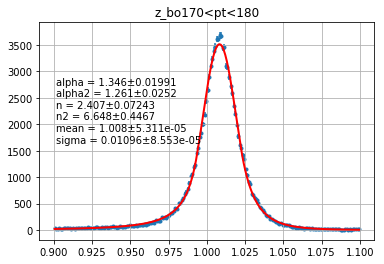

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.693092911731409, 1.8359147841314105, 0.8717332083934153, 7.011744611916566, 1.00848198291852, 0.015)


FCN = 1770.9064741 
 TOTAL NCALL = 354 
 NCALLS = 354 
 
 
 EDM = 1.14391905723e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.87482 
 0.0193716 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.07321 
 0.0287007 
 
 
 
 
 No 
 
 
 2 
 n 
 1.39113 
 0.0556122 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.31688 
 0.159138 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00867 
 5.11195e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.87482 & 0.0193716 & & & & & No\\
\hline
1 & alpha2 & 2.07321 & 0.0287007 & & & & & No\\
\hline
2 & n & 1.39113 & 0.0556122 & & & & & No\\
\hline
3 & n2 & 2.31688 & 0.159138 & & & & & No\\
\hline
4 & mean & 1.00867 & 5.11195e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 869.605377114 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.45166009128e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.87482 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.07321 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.39113 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.31688 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00867 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0131937 
 3.94495e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.87482 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.07321 & 1 & & & & & Yes\\
\hline
2 & n & 1.39113 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.31688 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00867 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0131937 & 3.94495e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 265.849559631 
 TOTAL NCALL = 265 
 NCALLS = 265 
 
 
 EDM = 3.77748001725e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.42847 
 0.0186626 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.30694 
 0.0241337 
 
 
 
 
 No 
 
 
 2 
 n 
 2.21746 
 0.0659064 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.41155 
 0.426883 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00868 
 5.2621e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0114928 
 7.41297e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.42847 & 0.0186626 & & & & & No\\
\hline
1 & alpha2 & 1.30694 & 0.0241337 & & & & & No\\
\hline
2 & n & 2.21746 & 0.0659064 & & & & & No\\
\hline
3 & n2 & 6.41155 & 0.426883 & & & & & No\\
\hline
4 & mean & 1.00868 & 5.2621e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0114928 & 7.41297e-05 & & & & & No\\
\hline
\end{tabular}

160<pt<170
14


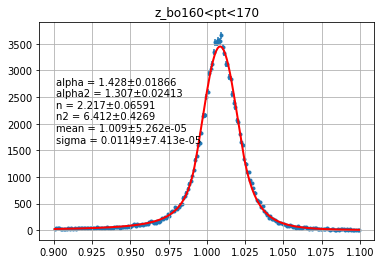

FCN = 1129.95635082 
 TOTAL NCALL = 329 
 NCALLS = 329 
 
 
 EDM = 5.83225299882e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.82308 
 0.01849 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.88871 
 0.0258128 
 
 
 
 
 No 
 
 
 2 
 n 
 1.39577 
 0.0530175 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.66458 
 0.167415 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0088 
 5.28875e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.82308 & 0.01849 & & & & & No\\
\hline
1 & alpha2 & 1.88871 & 0.0258128 & & & & & No\\
\hline
2 & n & 1.39577 & 0.0530175 & & & & & No\\
\hline
3 & n2 & 2.66458 & 0.167415 & & & & & No\\
\hline
4 & mean & 1.0088 & 5.28875e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.8230783332609637, 1.8887088775779004, 1.3957689124671633, 2.66458394059043, 1.008800700972433, -0.008217310988514897)


FCN = 658.25204453 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.11140507082e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.82308 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.88871 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.39577 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.66458 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0088 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.013636 
 4.20843e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.82308 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.88871 & 1 & & & & & Yes\\
\hline
2 & n & 1.39577 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.66458 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0088 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.013636 & 4.20843e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 232.436234944 
 TOTAL NCALL = 250 
 NCALLS = 250 
 
 
 EDM = 1.85612156229e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40249 
 0.0202765 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.24318 
 0.0235401 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22243 
 0.0707907 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.57024 
 0.448268 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00872 
 5.67198e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0118961 
 8.53056e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40249 & 0.0202765 & & & & & No\\
\hline
1 & alpha2 & 1.24318 & 0.0235401 & & & & & No\\
\hline
2 & n & 2.22243 & 0.0707907 & & & & & No\\
\hline
3 & n2 & 6.57024 & 0.448268 & & & & & No\\
\hline
4 & mean & 1.00872 & 5.67198e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0118961 & 8.53056e-05 & & & & & No\\
\hline
\end{tabular}

150<pt<160
15


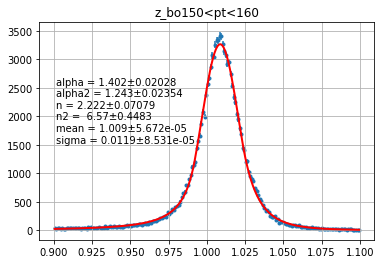

FCN = 853.984673319 
 TOTAL NCALL = 323 
 NCALLS = 323 
 
 
 EDM = 4.36637755383e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.75362 
 0.0190971 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.71572 
 0.023098 
 
 
 
 
 No 
 
 
 2 
 n 
 1.59138 
 0.0616226 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.14427 
 0.18597 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00883 
 5.52115e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.75362 & 0.0190971 & & & & & No\\
\hline
1 & alpha2 & 1.71572 & 0.023098 & & & & & No\\
\hline
2 & n & 1.59138 & 0.0616226 & & & & & No\\
\hline
3 & n2 & 3.14427 & 0.18597 & & & & & No\\
\hline
4 & mean & 1.00883 & 5.52115e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.7536212571477674, 1.7157215049458183, 1.5913847574805502, 3.1442736407936356, 1.0088290097699553, -0.005185390627426675)


FCN = 548.731141984 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 4.6904840785e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.75362 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.71572 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.59138 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.14427 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00883 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.013868 
 4.37947e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.75362 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.71572 & 1 & & & & & Yes\\
\hline
2 & n & 1.59138 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.14427 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00883 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.013868 & 4.37947e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 204.728014394 
 TOTAL NCALL = 266 
 NCALLS = 266 
 
 
 EDM = 8.50397463567e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37613 
 0.0207899 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.21764 
 0.0233566 
 
 
 
 
 No 
 
 
 2 
 n 
 2.39716 
 0.0808506 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.1204 
 0.409943 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00872 
 5.95519e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0122396 
 9.04716e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37613 & 0.0207899 & & & & & No\\
\hline
1 & alpha2 & 1.21764 & 0.0233566 & & & & & No\\
\hline
2 & n & 2.39716 & 0.0808506 & & & & & No\\
\hline
3 & n2 & 6.1204 & 0.409943 & & & & & No\\
\hline
4 & mean & 1.00872 & 5.95519e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0122396 & 9.04716e-05 & & & & & No\\
\hline
\end{tabular}

140<pt<150
16


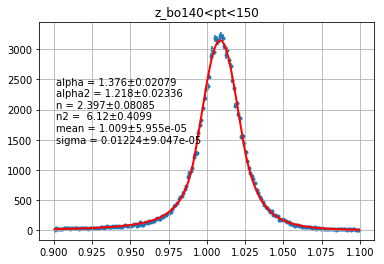

FCN = 539.688108175 
 TOTAL NCALL = 296 
 NCALLS = 296 
 
 
 EDM = 9.07676336927e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.69204 
 0.0181656 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.54569 
 0.0211788 
 
 
 
 
 No 
 
 
 2 
 n 
 1.67521 
 0.061714 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.53822 
 0.206593 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00891 
 5.78493e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.69204 & 0.0181656 & & & & & No\\
\hline
1 & alpha2 & 1.54569 & 0.0211788 & & & & & No\\
\hline
2 & n & 1.67521 & 0.061714 & & & & & No\\
\hline
3 & n2 & 3.53822 & 0.206593 & & & & & No\\
\hline
4 & mean & 1.00891 & 5.78493e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.692042433572986, 1.54569246319444, 1.6752138409925532, 3.538222645826574, 1.0089134346552389, -0.0010493529991505816)


FCN = 375.294155982 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 9.5445932045e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.69204 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.54569 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.67521 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.53822 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00891 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0141385 
 4.59552e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.69204 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.54569 & 1 & & & & & Yes\\
\hline
2 & n & 1.67521 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.53822 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00891 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0141385 & 4.59552e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 158.141107724 
 TOTAL NCALL = 240 
 NCALLS = 240 
 
 
 EDM = 5.27621904164e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.42577 
 0.0199394 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.16697 
 0.0227259 
 
 
 
 
 No 
 
 
 2 
 n 
 2.19828 
 0.0731955 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.14719 
 0.432883 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00864 
 6.40969e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0127825 
 9.08534e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.42577 & 0.0199394 & & & & & No\\
\hline
1 & alpha2 & 1.16697 & 0.0227259 & & & & & No\\
\hline
2 & n & 2.19828 & 0.0731955 & & & & & No\\
\hline
3 & n2 & 6.14719 & 0.432883 & & & & & No\\
\hline
4 & mean & 1.00864 & 6.40969e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0127825 & 9.08534e-05 & & & & & No\\
\hline
\end{tabular}

130<pt<140
17


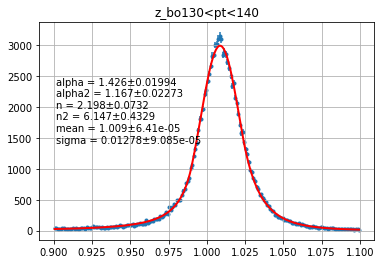

FCN = 323.054660302 
 TOTAL NCALL = 249 
 NCALLS = 249 
 
 
 EDM = 1.66899734893e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.57769 
 0.0180252 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.33349 
 0.0194631 
 
 
 
 
 No 
 
 
 2 
 n 
 1.88968 
 0.0693151 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.67537 
 0.422388 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00934 
 6.34448e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.57769 & 0.0180252 & & & & & No\\
\hline
1 & alpha2 & 1.33349 & 0.0194631 & & & & & No\\
\hline
2 & n & 1.88968 & 0.0693151 & & & & & No\\
\hline
3 & n2 & 5.67537 & 0.422388 & & & & & No\\
\hline
4 & mean & 1.00934 & 6.34448e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 290.157123166 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 7.67860348185e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.57769 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.33349 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.88968 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 5.67537 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00934 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0146071 
 4.76989e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.57769 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.33349 & 1 & & & & & Yes\\
\hline
2 & n & 1.88968 & 1 & & & & & Yes\\
\hline
3 & n2 & 5.67537 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00934 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0146071 & 4.76989e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 208.636138412 
 TOTAL NCALL = 250 
 NCALLS = 250 
 
 
 EDM = 4.47871553977e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38997 
 0.0212905 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.07335 
 0.0242325 
 
 
 
 
 No 
 
 
 2 
 n 
 2.30303 
 0.0823511 
 
 
 
 
 No 
 
 
 3 
 n2 
 10.0673 
 1.14231 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00905 
 7.44857e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0134789 
 0.000112794 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38997 & 0.0212905 & & & & & No\\
\hline
1 & alpha2 & 1.07335 & 0.0242325 & & & & & No\\
\hline
2 & n & 2.30303 & 0.0823511 & & & & & No\\
\hline
3 & n2 & 10.0673 & 1.14231 & & & & & No\\
\hline
4 & mean & 1.00905 & 7.44857e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0134789 & 0.000112794 & & & & & No\\
\hline
\end{tabular}

120<pt<130
18


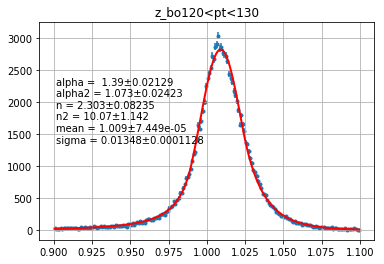

FCN = 205.530743249 
 TOTAL NCALL = 264 
 NCALLS = 264 
 
 
 EDM = 1.394390902e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.50066 
 0.0170374 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18507 
 0.0174686 
 
 
 
 
 No 
 
 
 2 
 n 
 2.11181 
 0.0756601 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.19087 
 0.618466 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00923 
 6.7482e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.50066 & 0.0170374 & & & & & No\\
\hline
1 & alpha2 & 1.18507 & 0.0174686 & & & & & No\\
\hline
2 & n & 2.11181 & 0.0756601 & & & & & No\\
\hline
3 & n2 & 7.19087 & 0.618466 & & & & & No\\
\hline
4 & mean & 1.00923 & 6.7482e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 197.617884838 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 2.43886890088e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.50066 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.18507 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.11181 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 7.19087 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00923 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0148058 
 4.84591e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.50066 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.18507 & 1 & & & & & Yes\\
\hline
2 & n & 2.11181 & 1 & & & & & Yes\\
\hline
3 & n2 & 7.19087 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00923 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0148058 & 4.84591e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 172.266873081 
 TOTAL NCALL = 236 
 NCALLS = 236 
 
 
 EDM = 2.30385361911e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40694 
 0.0210689 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.04409 
 0.0223746 
 
 
 
 
 No 
 
 
 2 
 n 
 2.31172 
 0.0861065 
 
 
 
 
 No 
 
 
 3 
 n2 
 10.5294 
 1.24858 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00898 
 7.7504e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0141338 
 0.000110918 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40694 & 0.0210689 & & & & & No\\
\hline
1 & alpha2 & 1.04409 & 0.0223746 & & & & & No\\
\hline
2 & n & 2.31172 & 0.0861065 & & & & & No\\
\hline
3 & n2 & 10.5294 & 1.24858 & & & & & No\\
\hline
4 & mean & 1.00898 & 7.7504e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0141338 & 0.000110918 & & & & & No\\
\hline
\end{tabular}

110<pt<120
19


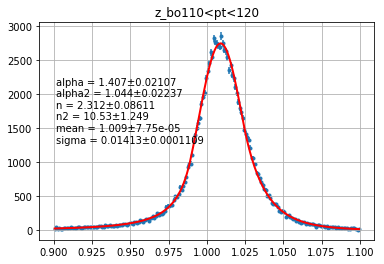

FCN = 187.489450823 
 TOTAL NCALL = 288 
 NCALLS = 288 
 
 
 EDM = 3.58142712205e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.3828 
 0.0172821 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.08067 
 0.0162193 
 
 
 
 
 No 
 
 
 2 
 n 
 2.59463 
 0.100623 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.05394 
 0.602058 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00905 
 7.55937e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.3828 & 0.0172821 & & & & & No\\
\hline
1 & alpha2 & 1.08067 & 0.0162193 & & & & & No\\
\hline
2 & n & 2.59463 & 0.100623 & & & & & No\\
\hline
3 & n2 & 7.05394 & 0.602058 & & & & & No\\
\hline
4 & mean & 1.00905 & 7.55937e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 187.47214653 
 TOTAL NCALL = 18 
 NCALLS = 18 
 
 
 EDM = 3.07032240186e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.3828 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.08067 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.59463 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 7.05394 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00905 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0149909 
 5.10354e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.3828 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.08067 & 1 & & & & & Yes\\
\hline
2 & n & 2.59463 & 1 & & & & & Yes\\
\hline
3 & n2 & 7.05394 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00905 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0149909 & 5.10354e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 187.393640394 
 TOTAL NCALL = 175 
 NCALLS = 175 
 
 
 EDM = 2.14848640469e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37677 
 0.0220348 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.0728 
 0.0241357 
 
 
 
 
 No 
 
 
 2 
 n 
 2.61076 
 0.107512 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.19367 
 0.698284 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00904 
 8.20668e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0149472 
 0.000120924 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37677 & 0.0220348 & & & & & No\\
\hline
1 & alpha2 & 1.0728 & 0.0241357 & & & & & No\\
\hline
2 & n & 2.61076 & 0.107512 & & & & & No\\
\hline
3 & n2 & 7.19367 & 0.698284 & & & & & No\\
\hline
4 & mean & 1.00904 & 8.20668e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0149472 & 0.000120924 & & & & & No\\
\hline
\end{tabular}

100<pt<110
20


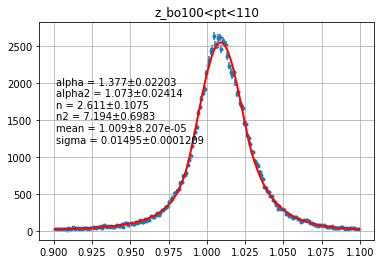

FCN = 178.189027315 
 TOTAL NCALL = 286 
 NCALLS = 286 
 
 
 EDM = 6.47206597687e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23843 
 0.0163679 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.890769 
 0.0131154 
 
 
 
 
 No 
 
 
 2 
 n 
 3.26513 
 0.13896 
 
 
 
 
 No 
 
 
 3 
 n2 
 10.7453 
 1.29125 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0086 
 8.65595e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23843 & 0.0163679 & & & & & No\\
\hline
1 & alpha2 & 0.890769 & 0.0131154 & & & & & No\\
\hline
2 & n & 3.26513 & 0.13896 & & & & & No\\
\hline
3 & n2 & 10.7453 & 1.29125 & & & & & No\\
\hline
4 & mean & 1.0086 & 8.65595e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 177.326471053 
 TOTAL NCALL = 17 
 NCALLS = 17 
 
 
 EDM = 5.58140680484e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23843 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.890769 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.26513 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 10.7453 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0086 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150684 
 5.23528e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23843 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.890769 & 1 & & & & & Yes\\
\hline
2 & n & 3.26513 & 1 & & & & & Yes\\
\hline
3 & n2 & 10.7453 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0086 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150684 & 5.23528e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 170.697854281 
 TOTAL NCALL = 236 
 NCALLS = 236 
 
 
 EDM = 2.74222969669e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.29911 
 0.0227999 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.956962 
 0.0224907 
 
 
 
 
 No 
 
 
 2 
 n 
 3.06664 
 0.139977 
 
 
 
 
 No 
 
 
 3 
 n2 
 8.61991 
 1.00583 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00877 
 9.43974e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0155757 
 0.000144825 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.29911 & 0.0227999 & & & & & No\\
\hline
1 & alpha2 & 0.956962 & 0.0224907 & & & & & No\\
\hline
2 & n & 3.06664 & 0.139977 & & & & & No\\
\hline
3 & n2 & 8.61991 & 1.00583 & & & & & No\\
\hline
4 & mean & 1.00877 & 9.43974e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0155757 & 0.000144825 & & & & & No\\
\hline
\end{tabular}

90<pt<100
21


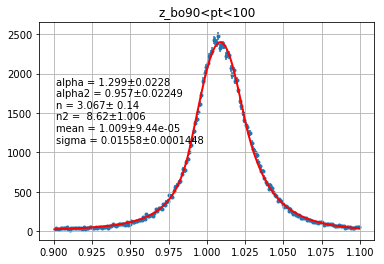

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (0.5418609765016033, 16.616417295798687, -9.965296614970441, -781.2487911550213, 0.9681512541276022, 0.015)


FCN = 3375.52940955 
 TOTAL NCALL = 76 
 NCALLS = 65 
 
 
 EDM = 45418.3305415 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0.00303012 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0.0527073 
 
 
 
 
 No 
 
 
 2 
 n 
 10 
 0.211976 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 2.63508 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.004 
 0.0001296 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0.00303012 & & & & & No\\
\hline
1 & alpha2 & 1 & 0.0527073 & & & & & No\\
\hline
2 & n & 10 & 0.211976 & & & & & No\\
\hline
3 & n2 & 4 & 2.63508 & & & & & No\\
\hline
4 & mean & 1.004 & 0.0001296 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 3071.79673474 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 3.03972066979e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 10 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.004 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0163768 
 5.90662e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1 & 1 & & & & & Yes\\
\hline
2 & n & 10 & 1 & & & & & Yes\\
\hline
3 & n2 & 4 & 1 & & & & & Yes\\
\hline
4 & mean & 1.004 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0163768 & 5.90662e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 181.888694736 
 TOTAL NCALL = 398 
 NCALLS = 398 
 
 
 EDM = 1.33981439652e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.30264 
 0.024014 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.862134 
 0.0201677 
 
 
 
 
 No 
 
 
 2 
 n 
 3.02829 
 0.15181 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.0967 
 2.65521 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00831 
 0.000106919 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0165402 
 0.000158651 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.30264 & 0.024014 & & & & & No\\
\hline
1 & alpha2 & 0.862134 & 0.0201677 & & & & & No\\
\hline
2 & n & 3.02829 & 0.15181 & & & & & No\\
\hline
3 & n2 & 14.0967 & 2.65521 & & & & & No\\
\hline
4 & mean & 1.00831 & 0.000106919 & & & & & No\\
\hline
5 & $\sigma$ & 0.0165402 & 0.000158651 & & & & & No\\
\hline
\end{tabular}

FCN = 181.888692436 
 TOTAL NCALL = 54 
 NCALLS = 54 
 
 
 EDM = 1.717989381e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.30265 
 0.0166241 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.862137 
 0.0114253 
 
 
 
 
 No 
 
 
 2 
 n 
 3.02833 
 0.136522 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.0975 
 2.27683 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00831 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0165402 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.30265 & 0.0166241 & & & & & No\\
\hline
1 & alpha2 & 0.862137 & 0.0114253 & & & & & No\\
\hline
2 & n & 3.02833 & 0.136522 & & & & & No\\
\hline
3 & n2 & 14.0975 & 2.27683 & & & & & No\\
\hline
4 & mean & 1.00831 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0165402 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 181.888692436 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = 1.06894521428e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.30265 
 0.0236139 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.862137 
 0.0198479 
 
 
 
 
 No 
 
 
 2 
 n 
 3.02833 
 0.151419 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.0975 
 2.65868 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00831 
 0.00010614 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0165402 
 0.000152681 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.30265 & 0.0236139 & & & & & No\\
\hline
1 & alpha2 & 0.862137 & 0.0198479 & & & & & No\\
\hline
2 & n & 3.02833 & 0.151419 & & & & & No\\
\hline
3 & n2 & 14.0975 & 2.65868 & & & & & No\\
\hline
4 & mean & 1.00831 & 0.00010614 & & & & & No\\
\hline
5 & $\sigma$ & 0.0165402 & 0.000152681 & & & & & No\\
\hline
\end{tabular}

80<pt<90
22


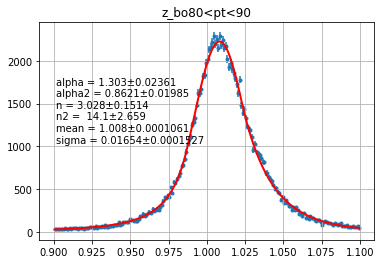

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (0.9943126054553924, 0.7504858897718707, -23.149333298828722, 1.2272605409988742, 1.00900514525709, 0.015)


FCN = 251.180481241 
 TOTAL NCALL = 554 
 NCALLS = 543 
 
 
 EDM = 0.801940048768 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.954672 
 0.0139262 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.604929 
 0.00402844 
 
 
 
 
 No 
 
 
 2 
 n 
 5.00246 
 0.285057 
 
 
 
 
 No 
 
 
 3 
 n2 
 129.294 
 46.2939 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0082 
 0.000112138 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.954672 & 0.0139262 & & & & & No\\
\hline
1 & alpha2 & 0.604929 & 0.00402844 & & & & & No\\
\hline
2 & n & 5.00246 & 0.285057 & & & & & No\\
\hline
3 & n2 & 129.294 & 46.2939 & & & & & No\\
\hline
4 & mean & 1.0082 & 0.000112138 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 248.717331951 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 2.13234378899e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.954672 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.604929 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 5.00246 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 129.294 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0082 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151231 
 5.58129e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.954672 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.604929 & 1 & & & & & Yes\\
\hline
2 & n & 5.00246 & 1 & & & & & Yes\\
\hline
3 & n2 & 129.294 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0082 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151231 & 5.58129e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 182.416609425 
 TOTAL NCALL = 116 
 NCALLS = 116 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.15899 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.735507 
 nan 
 
 
 
 
 No 
 
 
 2 
 n 
 4.18138 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 135.507 
 nan 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00895 
 nan 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0176785 
 nan 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.15899 & nan & & & & & No\\
\hline
1 & alpha2 & 0.735507 & nan & & & & & No\\
\hline
2 & n & 4.18138 & nan & & & & & No\\
\hline
3 & n2 & 135.507 & nan & & & & & No\\
\hline
4 & mean & 1.00895 & nan & & & & & No\\
\hline
5 & $\sigma$ & 0.0176785 & nan & & & & & No\\
\hline
\end{tabular}

70<pt<80
23


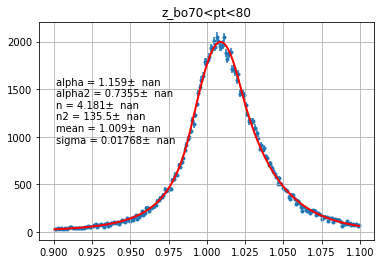

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.0, 1.0, -3.8061956509206176, 4.0, 1.004, 0.015)


FCN = 475.63777799 
 TOTAL NCALL = 380 
 NCALLS = 380 
 
 
 EDM = 1.4036111654e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.931363 
 0.0113023 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.561175 
 0.0059502 
 
 
 
 
 No 
 
 
 2 
 n 
 3.40848 
 0.088732 
 
 
 
 
 No 
 
 
 3 
 n2 
 17.6752 
 1.75433 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00956 
 0.000136618 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.931363 & 0.0113023 & & & & & No\\
\hline
1 & alpha2 & 0.561175 & 0.0059502 & & & & & No\\
\hline
2 & n & 3.40848 & 0.088732 & & & & & No\\
\hline
3 & n2 & 17.6752 & 1.75433 & & & & & No\\
\hline
4 & mean & 1.00956 & 0.000136618 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 468.766284171 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 2.05489331225e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.931363 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.561175 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.40848 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 17.6752 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00956 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151913 
 5.20412e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.931363 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.561175 & 1 & & & & & Yes\\
\hline
2 & n & 3.40848 & 1 & & & & & Yes\\
\hline
3 & n2 & 17.6752 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00956 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151913 & 5.20412e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 183.769150424 
 TOTAL NCALL = 412 
 NCALLS = 412 
 
 
 EDM = 7.56135008205e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.36375 
 0.0197394 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.897354 
 0.0167806 
 
 
 
 
 No 
 
 
 2 
 n 
 2.45113 
 0.0714917 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.694 
 0.473636 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01137 
 0.000128655 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0208366 
 0.000190796 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.36375 & 0.0197394 & & & & & No\\
\hline
1 & alpha2 & 0.897354 & 0.0167806 & & & & & No\\
\hline
2 & n & 2.45113 & 0.0714917 & & & & & No\\
\hline
3 & n2 & 7.694 & 0.473636 & & & & & No\\
\hline
4 & mean & 1.01137 & 0.000128655 & & & & & No\\
\hline
5 & $\sigma$ & 0.0208366 & 0.000190796 & & & & & No\\
\hline
\end{tabular}

60<pt<70
24


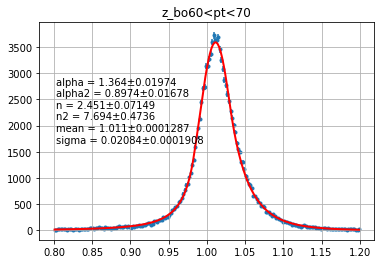

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (0.8620829005428416, 0.5360612671722331, 0.3529931108350306, 9.985242971080885, 1.0110599580490136, 0.015)


FCN = 455.703971919 
 TOTAL NCALL = 416 
 NCALLS = 416 
 
 
 EDM = 3.13210643801e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.743493 
 0.00895721 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.518775 
 0.00613519 
 
 
 
 
 No 
 
 
 2 
 n 
 5.18611 
 0.17724 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.4088 
 1.35761 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01233 
 0.000162656 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.743493 & 0.00895721 & & & & & No\\
\hline
1 & alpha2 & 0.518775 & 0.00613519 & & & & & No\\
\hline
2 & n & 5.18611 & 0.17724 & & & & & No\\
\hline
3 & n2 & 14.4088 & 1.35761 & & & & & No\\
\hline
4 & mean & 1.01233 & 0.000162656 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 453.065038583 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 8.52060714143e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.743493 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.518775 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 5.18611 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 14.4088 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01233 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151198 
 5.24326e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.743493 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.518775 & 1 & & & & & Yes\\
\hline
2 & n & 5.18611 & 1 & & & & & Yes\\
\hline
3 & n2 & 14.4088 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01233 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151198 & 5.24326e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 196.732510583 
 TOTAL NCALL = 403 
 NCALLS = 403 
 
 
 EDM = 1.35035531092e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24046 
 0.0229358 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.883954 
 0.0176059 
 
 
 
 
 No 
 
 
 2 
 n 
 3.30762 
 0.122774 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.84462 
 0.427401 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01368 
 0.000137265 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0224912 
 0.000239762 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24046 & 0.0229358 & & & & & No\\
\hline
1 & alpha2 & 0.883954 & 0.0176059 & & & & & No\\
\hline
2 & n & 3.30762 & 0.122774 & & & & & No\\
\hline
3 & n2 & 6.84462 & 0.427401 & & & & & No\\
\hline
4 & mean & 1.01368 & 0.000137265 & & & & & No\\
\hline
5 & $\sigma$ & 0.0224912 & 0.000239762 & & & & & No\\
\hline
\end{tabular}

50<pt<60
25


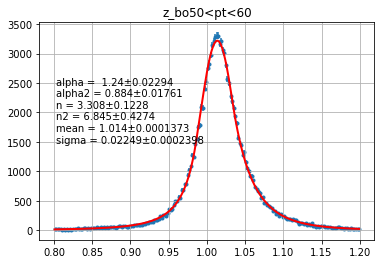

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.0, 1.0, -2.322886097130871, 4.0, 1.004, 0.015)


FCN = 816.714585573 
 TOTAL NCALL = 361 
 NCALLS = 361 
 
 
 EDM = 4.50222280936e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.692566 
 0.00721927 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.531101 
 0.00518846 
 
 
 
 
 No 
 
 
 2 
 n 
 3.5862 
 0.0642083 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.44574 
 0.0875041 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01321 
 0.000175475 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.692566 & 0.00721927 & & & & & No\\
\hline
1 & alpha2 & 0.531101 & 0.00518846 & & & & & No\\
\hline
2 & n & 3.5862 & 0.0642083 & & & & & No\\
\hline
3 & n2 & 4.44574 & 0.0875041 & & & & & No\\
\hline
4 & mean & 1.01321 & 0.000175475 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 812.802704304 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 2.19641571186e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.692566 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.531101 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.5862 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4.44574 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01321 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151587 
 5.70817e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.692566 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.531101 & 1 & & & & & Yes\\
\hline
2 & n & 3.5862 & 1 & & & & & Yes\\
\hline
3 & n2 & 4.44574 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01321 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151587 & 5.70817e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 307.373203778 
 TOTAL NCALL = 286 
 NCALLS = 286 
 
 
 EDM = 3.63175972999e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26461 
 0.0169682 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.99983 
 0.0143117 
 
 
 
 
 No 
 
 
 2 
 n 
 2.59555 
 0.0543746 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.27666 
 0.0683295 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01489 
 0.000144125 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.02604 
 0.000237699 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26461 & 0.0169682 & & & & & No\\
\hline
1 & alpha2 & 0.99983 & 0.0143117 & & & & & No\\
\hline
2 & n & 2.59555 & 0.0543746 & & & & & No\\
\hline
3 & n2 & 3.27666 & 0.0683295 & & & & & No\\
\hline
4 & mean & 1.01489 & 0.000144125 & & & & & No\\
\hline
5 & $\sigma$ & 0.02604 & 0.000237699 & & & & & No\\
\hline
\end{tabular}

40<pt<50
26


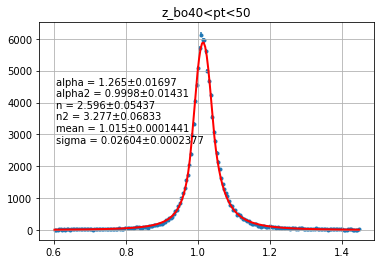

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.0, 1.0, -5.52766635032439, 4.0, 1.004, 0.015)


FCN = 634.200649313 
 TOTAL NCALL = 358 
 NCALLS = 358 
 
 
 EDM = 1.74082175357e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.498133 
 0.00540207 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.463832 
 0.00515005 
 
 
 
 
 No 
 
 
 2 
 n 
 4.84205 
 0.115299 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.75476 
 0.0736661 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01822 
 0.000232589 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.498133 & 0.00540207 & & & & & No\\
\hline
1 & alpha2 & 0.463832 & 0.00515005 & & & & & No\\
\hline
2 & n & 4.84205 & 0.115299 & & & & & No\\
\hline
3 & n2 & 3.75476 & 0.0736661 & & & & & No\\
\hline
4 & mean & 1.01822 & 0.000232589 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 633.255380733 
 TOTAL NCALL = 17 
 NCALLS = 17 
 
 
 EDM = 3.08897974416e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.498133 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.463832 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.84205 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.75476 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01822 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150792 
 5.7441e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.498133 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.463832 & 1 & & & & & Yes\\
\hline
2 & n & 4.84205 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.75476 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01822 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150792 & 5.7441e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 267.168664521 
 TOTAL NCALL = 301 
 NCALLS = 301 
 
 
 EDM = 2.64055292421e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.05268 
 0.018245 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.957087 
 0.0158287 
 
 
 
 
 No 
 
 
 2 
 n 
 3.49147 
 0.0900198 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.88127 
 0.062144 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01889 
 0.000176821 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0296433 
 0.000355175 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.05268 & 0.018245 & & & & & No\\
\hline
1 & alpha2 & 0.957087 & 0.0158287 & & & & & No\\
\hline
2 & n & 3.49147 & 0.0900198 & & & & & No\\
\hline
3 & n2 & 2.88127 & 0.062144 & & & & & No\\
\hline
4 & mean & 1.01889 & 0.000176821 & & & & & No\\
\hline
5 & $\sigma$ & 0.0296433 & 0.000355175 & & & & & No\\
\hline
\end{tabular}

30<pt<40
27


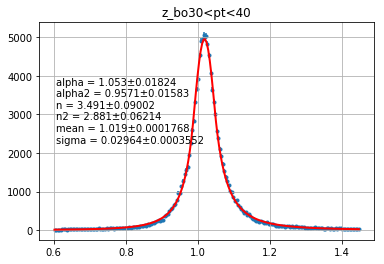

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SmallIntegralWarning: (1.0, 1.0, 0.11545972595141585, 4.0, 1.004, 0.015)


FCN = 918.98738103 
 TOTAL NCALL = 382 
 NCALLS = 382 
 
 
 EDM = 4.64217531124e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.386565 
 0.00407042 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.363932 
 0.00392823 
 
 
 
 
 No 
 
 
 2 
 n 
 4.75613 
 0.0992619 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.15244 
 0.0447961 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.02696 
 0.000314932 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.386565 & 0.00407042 & & & & & No\\
\hline
1 & alpha2 & 0.363932 & 0.00392823 & & & & & No\\
\hline
2 & n & 4.75613 & 0.0992619 & & & & & No\\
\hline
3 & n2 & 3.15244 & 0.0447961 & & & & & No\\
\hline
4 & mean & 1.02696 & 0.000314932 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 918.771958346 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 1.15172341399e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.386565 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.363932 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.75613 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.15244 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.02696 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150383 
 5.84253e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.386565 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.363932 & 1 & & & & & Yes\\
\hline
2 & n & 4.75613 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.15244 & 1 & & & & & Yes\\
\hline
4 & mean & 1.02696 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150383 & 5.84253e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 336.993118304 
 TOTAL NCALL = 352 
 NCALLS = 352 
 
 
 EDM = 1.07086611202e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.17046 
 0.0193416 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.01409 
 0.0141348 
 
 
 
 
 No 
 
 
 2 
 n 
 3.12062 
 0.0766561 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.43287 
 0.0400439 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.02798 
 0.000231336 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0415982 
 0.000444782 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.17046 & 0.0193416 & & & & & No\\
\hline
1 & alpha2 & 1.01409 & 0.0141348 & & & & & No\\
\hline
2 & n & 3.12062 & 0.0766561 & & & & & No\\
\hline
3 & n2 & 2.43287 & 0.0400439 & & & & & No\\
\hline
4 & mean & 1.02798 & 0.000231336 & & & & & No\\
\hline
5 & $\sigma$ & 0.0415982 & 0.000444782 & & & & & No\\
\hline
\end{tabular}

FCN = 336.993116651 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 4.4795349172e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.17046 
 0.0104017 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.01408 
 0.00829675 
 
 
 
 
 No 
 
 
 2 
 n 
 3.12065 
 0.0641425 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.43289 
 0.035465 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.02798 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0415982 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.17046 & 0.0104017 & & & & & No\\
\hline
1 & alpha2 & 1.01408 & 0.00829675 & & & & & No\\
\hline
2 & n & 3.12065 & 0.0641425 & & & & & No\\
\hline
3 & n2 & 2.43289 & 0.035465 & & & & & No\\
\hline
4 & mean & 1.02798 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0415982 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 336.993110263 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 2.66883861294e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.17045 
 0.0193405 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.01408 
 0.0141341 
 
 
 
 
 No 
 
 
 2 
 n 
 3.12064 
 0.0766519 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.43292 
 0.0400435 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.02798 
 0.000231335 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0415986 
 0.000444776 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.17045 & 0.0193405 & & & & & No\\
\hline
1 & alpha2 & 1.01408 & 0.0141341 & & & & & No\\
\hline
2 & n & 3.12064 & 0.0766519 & & & & & No\\
\hline
3 & n2 & 2.43292 & 0.0400435 & & & & & No\\
\hline
4 & mean & 1.02798 & 0.000231335 & & & & & No\\
\hline
5 & $\sigma$ & 0.0415986 & 0.000444776 & & & & & No\\
\hline
\end{tabular}

20<pt<30
28


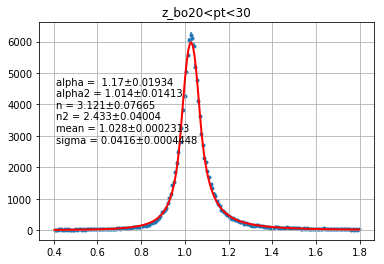

In [37]:
tipe='z_bo'
i=0
for para in feat_pt:
    if i>23:
        if i>25 and i!=28:
            rmin=0.6
            rmax=1.45
        elif i==28:
            rmin=0.4
            rmax=1.8
        else:
            rmin=0.8
            rmax=1.2
    
        
    else:
        rmin = 0.9
        rmax = 1.1
    
    df=data.query(para).astype('double')
    df=df[tipe]
    bound_DCB=[rmin, rmax]
    normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(5):
        #first step
        if j==0: 
            pars_dcb = dict(mean  = 1.004, 
                        fix_mean = False,
                        sigma  = 0.015,
                        fix_sigma = True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
        
        elif j==1:
                pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = True,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = True
                        )
                
        elif j==3:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = True,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
                
        #optimize parameter withoptimized start parameter
        else:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
        minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
        minuit.migrad() #optimized parameter
        if i!=7 and i !=9 and i!=22 and i!=28:
            if j==2:
                break
            else:
                pass
     
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
    binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    if tipe=='target':
        mean_pt_un[i]=minuit.values['mean']
        mean_err_pt_un[i]=minuit.errors['mean']
        sigma_pt_un[i]=minuit.values['sigma']
        sigma_err_pt_un[i]=minuit.errors['sigma']
    if tipe=='z_default':
        mean_pt_de[i]=minuit.values['mean']
        mean_err_pt_de[i]=minuit.errors['mean']
        sigma_pt_de[i]=minuit.values['sigma']
        sigma_err_pt_de[i]=minuit.errors['sigma']       
    if tipe=='z_bo':
        mean_pt_bo[i]=minuit.values['mean']
        mean_err_pt_bo[i]=minuit.errors['mean']
        sigma_pt_bo[i]=minuit.values['sigma']
        sigma_err_pt_bo[i]=minuit.errors['sigma'] 
    print(para)
    print(i)
    i+=1
    if i==29:
        i=0
        
    plt.title(tipe+para)
    plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
    plt.show()
#np.savetxt('pt_parameter_bo.csv', (mean_pt_bo,sigma_pt_bo), delimiter=',')

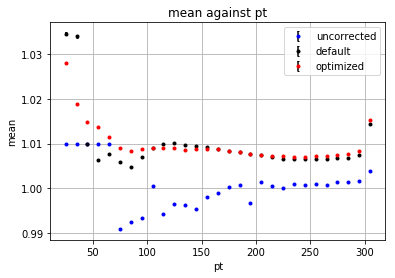

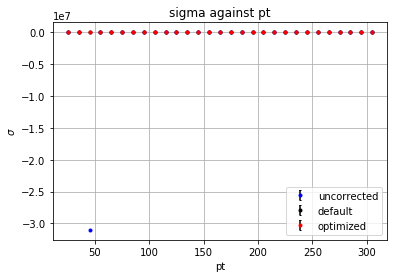

In [38]:
plt.figure()
plt.errorbar(pt,mean_pt_un, yerr=mean_err_pt_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(pt,mean_pt_de, yerr=mean_err_pt_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(pt,mean_pt_bo, yerr=mean_err_pt_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('mean against pt')
plt.xlabel('pt')
plt.ylabel('mean')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','mean_against_pt'+'.png'))
plt.show()

plt.figure()
plt.errorbar(pt,sigma_pt_un, yerr=sigma_err_pt_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(pt,sigma_pt_de, yerr=sigma_err_pt_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(pt,sigma_pt_bo, yerr=sigma_err_pt_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('sigma against pt')
plt.xlabel('pt')
plt.ylabel('$\sigma$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','sigma_against_pt'+'.png'))
plt.show()